# For Creating Simple Training Data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import random

In [25]:
def save_pgm(image, filename, max_val=255):
    """
    Save an array to a PGM file.
    
    Parameters:
    - image: 2D numpy array of pixel values.
    - filename: String, the name of the file to save the image to.
    - max_val: Integer, the maximum pixel value (typically 255 for 8-bit images).
    """
    # Ensure the pixel values are within the correct range
    image = np.clip(image, 0, max_val)
    
    # Open the file for writing
    with open(filename, 'wb') as f:
        # Write the PGM header
        f.write(bytes(f"P5\n{image.shape[1]} {image.shape[0]}\n{max_val}\n", 'ascii'))
        
        # Write the pixel data
        if image.dtype != np.uint8:
            image = image.astype(np.uint8)
        image.tofile(f)

In [26]:
def forward_difference_x(image):
    rows, cols = image.shape
    d = np.zeros((rows,cols))
    d[:,1:cols-1] = image[:,1:cols-1] - image[:,0:cols-2];
    d[:,0] = image[:,0] - image[:,cols-1];
    return d

def forward_difference_y(image):
    rows, cols = image.shape
    d = np.zeros((rows,cols))
    d[1:rows-1, :] = image[1:rows-1, :] - image[0:rows-2, :];
    d[0,:] = image[0,:] - image[rows-1,:];
    return d

def compute_gradient(image):
    #finds the gradient of each pixel in both x and y directions
    gradient_x = forward_difference_x(image)
    gradient_y = forward_difference_y(image)
    return gradient_x, gradient_y

def compute_divergence(gradient_x, gradient_y):
    #finds the divergence in each pixel
    div_x = -forward_difference_x(gradient_x)
    div_y = -forward_difference_y(gradient_y)
    return div_x + div_y

In [27]:
def convert_pgm_to_tiff(pgm_path, tiff_path):
    # Open the PGM file using Pillow
    with Image.open(pgm_path) as img:
        # Save the image as a TIFF file
        img.save(tiff_path, format='TIFF')

In [28]:
def find_center(elevation):
    gradient_x, gradient_y = compute_gradient(elevation)
    divergence = compute_divergence(gradient_x, gradient_y)
    
    # Find the point with the minimum divergence (assumed to be the center)
    center_idx = np.unravel_index(np.argmin(divergence), divergence.shape)
    return center_idx

def find_crater(elevation):
    gradient_x, gradient_y = compute_gradient(elevation)
    magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    
    # Define crater as regions where the gradient magnitude is significantly above the threshold
    threshold = np.percentile(magnitude, 5)  # Adjust threshold as necessary
    rim = magnitude > threshold
    return rim

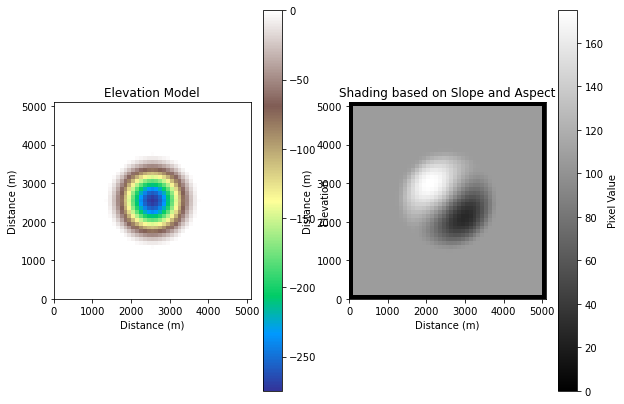

Image saved to TestHoles/hole_mx51_my51_slope20_el25_az45_xrad1250_yrad1250.pgm
Label image saved to TestHoles/hole_mx51_my51_slope20_el25_az45_xrad1250_yrad1250LABEL.pgm


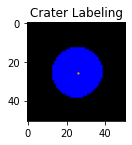

In [33]:
def make_hole(mx=51, my=51, pixel_size=100.0, max_slope_deg=20, sun_elevation_deg=25,
              sun_azimuth_deg=45,radius_x=None, radius_y=None, output_dir='.'):

    # Constants
    radian = np.pi / 180.0
    pi = np.pi

    # Set default radii if not specified
    if radius_x is None:
        radius_x = pixel_size * 0.25 * (mx - 1)
    if radius_y is None:
        radius_y = pixel_size * 0.25 * (my - 1)
    
    xmid = pixel_size * 0.5 * (mx - 1)
    ymid = pixel_size * 0.5 * (my - 1)
    max_slope = np.tan(radian * max_slope_deg)
    sun_elevation = radian * sun_elevation_deg
    sun_azimuth = radian * sun_azimuth_deg
    zenith = radian * 90

    # Allocate elevation array
    elevation = np.zeros((mx, my), dtype=np.float32)

    # Create an elliptical hole
    for j in range(my):
        y = j * pixel_size
        for i in range(mx):
            x = i * pixel_size
            # Elliptical distance calculation
            ellipse_dist = ((x - xmid) ** 2 / radius_x ** 2) + ((y - ymid) ** 2 / radius_y ** 2)
            if ellipse_dist <= 1.0:
                rad_radius = pi * np.sqrt(ellipse_dist) / 2.0
                elevation[i, j] -= pixel_size * (1.0 - np.cos((pi / 2.0 - rad_radius)) ** 2) / max_slope

    # Allocate pixel array
    pixel = np.zeros((mx, my), dtype=np.int32)

    # Calculate pixel values based on slope and aspect
    for j in range(1, my - 1):
        for i in range(1, mx - 1):
            aa, bb, cc = elevation[i-1, j-1:j+2]
            dd, ee, ff = elevation[i, j-1:j+2]
            gg, hh, ii = elevation[i+1, j-1:j+2]
            dzdx = (-(gg + 2.0 * hh + ii) + (aa + 2 * bb + cc)) / (8.0 * pixel_size)
            dzdy = (-(cc + 2.0 * ff + ii) + (aa + 2 * dd + gg)) / (8.0 * pixel_size)
            slope = np.arctan(np.sqrt(dzdx ** 2 + dzdy ** 2))
            aspect = np.arctan2(dzdy, dzdx)
            pixel[i, j] = int(255.0 * ((np.cos(zenith - sun_elevation) * np.cos(slope)) +
                                       (np.sin(zenith - sun_elevation) * np.sin(slope) * np.cos(sun_azimuth - aspect))))

    
    # Find the crater center and rim
    center = find_center(elevation)
    crater = find_crater(elevation)

    # Create a label image
    label_image = np.zeros((elevation.shape[0], elevation.shape[1], 3), dtype=np.uint8)
    label_image[crater] = [0, 0, 255]  # Blue
    label_image[center] = [255, 165, 0]  # Orange
    
    # Visualization
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 3, 1)
    plt.imshow(elevation, cmap='terrain', extent=[0, mx * pixel_size, 0, my * pixel_size])
    plt.colorbar(label='Elevation')
    plt.title('Elevation Model')
    plt.xlabel('Distance (m)')
    plt.ylabel('Distance (m)')

    plt.subplot(1, 3, 2)
    plt.imshow(pixel, cmap='gray', extent=[0, mx * pixel_size, 0, my * pixel_size])
    plt.colorbar(label='Pixel Value')
    plt.title('Shading based on Slope and Aspect')
    plt.xlabel('Distance (m)')
    plt.ylabel('Distance (m)')
    plt.show()

    plt.subplot(1, 3, 3)
    plt.imshow(label_image)
    plt.title('Crater Labeling')

    # Check if output directory exists, create if not
    os.makedirs(output_dir, exist_ok=True)

    # Save the PGM image using PIL
    pgm_path = os.path.join(output_dir, f'hole_mx{mx}_my{my}_slope{max_slope_deg}_el{sun_elevation_deg}_az{sun_azimuth_deg}_xrad{int(radius_x)}_yrad{int(radius_y)}.pgm')
    image = Image.fromarray(pixel.astype('uint8'), 'L')
    image.save(pgm_path)
    convert_pgm_to_tiff(pgm_path, os.path.join(output_dir, f'hole_mx{mx}_my{my}_slope{max_slope_deg}_el{sun_elevation_deg}_az{sun_azimuth_deg}_xrad{int(radius_x)}_yrad{int(radius_y)}.tif'))
    print(f"Image saved to {pgm_path}")
    
    # Save the label image as PGM using PIL
    label_path = os.path.join(output_dir, f'hole_mx{mx}_my{my}_slope{max_slope_deg}_el{sun_elevation_deg}_az{sun_azimuth_deg}_xrad{int(radius_x)}_yrad{int(radius_y)}LABEL.pgm')
    label_pgm = Image.fromarray(label_image, 'RGB')
    label_pgm.save(label_path)
    convert_pgm_to_tiff(label_path, os.path.join(output_dir, f'hole_mx{mx}_my{my}_slope{max_slope_deg}_el{sun_elevation_deg}_az{sun_azimuth_deg}_xrad{int(radius_x)}_yrad{int(radius_y)}LABEL.tif'))
    print(f"Label image saved to {label_path}")

# Example usage
make_hole(output_dir='TestHoles')

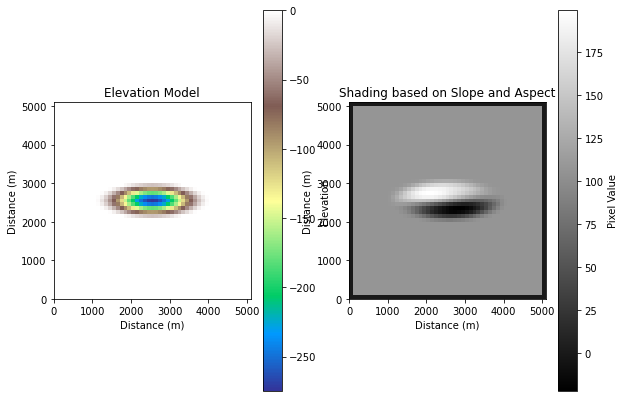

Image saved to TestHoles/hole_mx51_my51_slope20_el25_az45_xrad500_yrad1500.pgm
Label image saved to TestHoles/hole_mx51_my51_slope20_el25_az45_xrad500_yrad1500LABEL.pgm


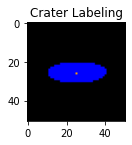

In [34]:
make_hole(radius_x = 500, radius_y = 1500, output_dir='TestHoles')

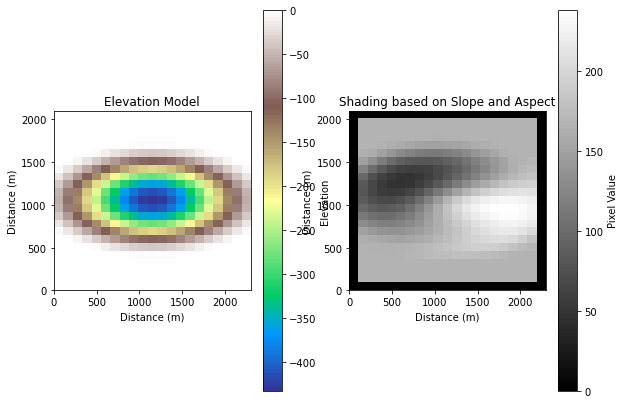

Image saved to TestHoles/hole_mx23_my21_slope13_el41_az248_xrad741_yrad1301.pgm
Label image saved to TestHoles/hole_mx23_my21_slope13_el41_az248_xrad741_yrad1301LABEL.pgm


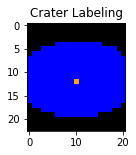

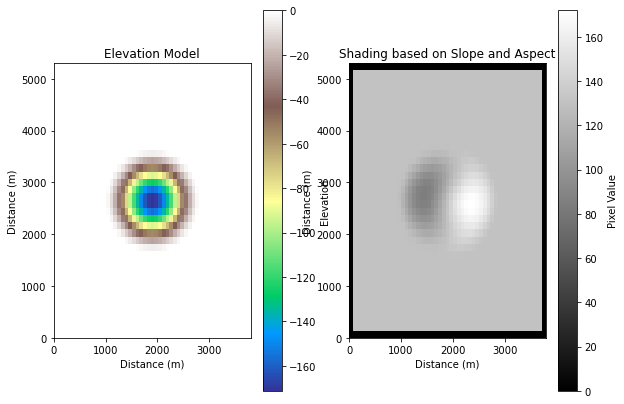

Image saved to TestHoles/hole_mx38_my53_slope30_el31_az264_xrad727_yrad1301.pgm
Label image saved to TestHoles/hole_mx38_my53_slope30_el31_az264_xrad727_yrad1301LABEL.pgm


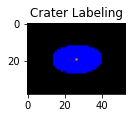

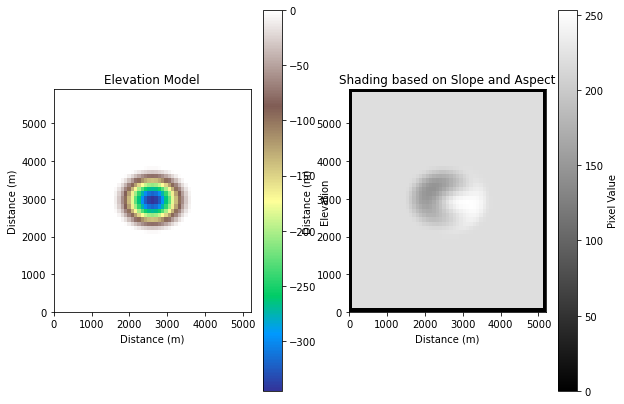

Image saved to TestHoles/hole_mx52_my59_slope16_el60_az255_xrad798_yrad1240.pgm
Label image saved to TestHoles/hole_mx52_my59_slope16_el60_az255_xrad798_yrad1240LABEL.pgm


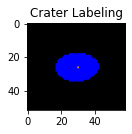

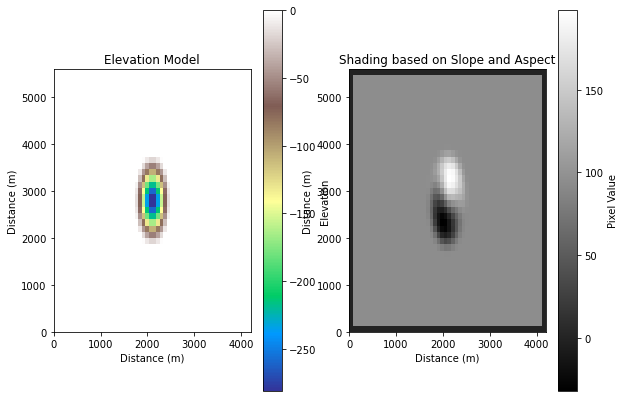

Image saved to TestHoles/hole_mx42_my56_slope19_el22_az343_xrad781_yrad529.pgm
Label image saved to TestHoles/hole_mx42_my56_slope19_el22_az343_xrad781_yrad529LABEL.pgm


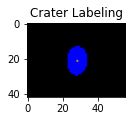

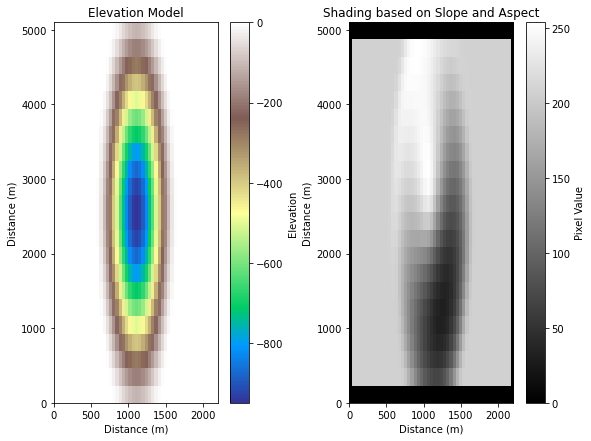

Image saved to TestHoles/hole_mx22_my51_slope6_el55_az29_xrad1345_yrad1268.pgm
Label image saved to TestHoles/hole_mx22_my51_slope6_el55_az29_xrad1345_yrad1268LABEL.pgm


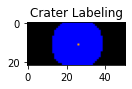

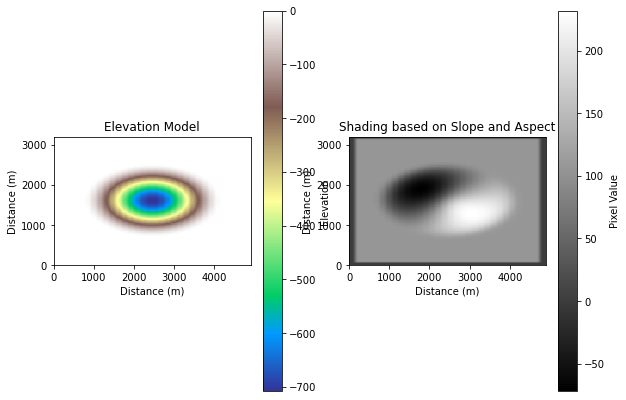

Image saved to TestHoles/hole_mx49_my32_slope8_el25_az227_xrad1407_yrad1124.pgm
Label image saved to TestHoles/hole_mx49_my32_slope8_el25_az227_xrad1407_yrad1124LABEL.pgm


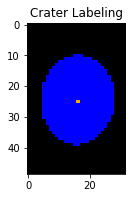

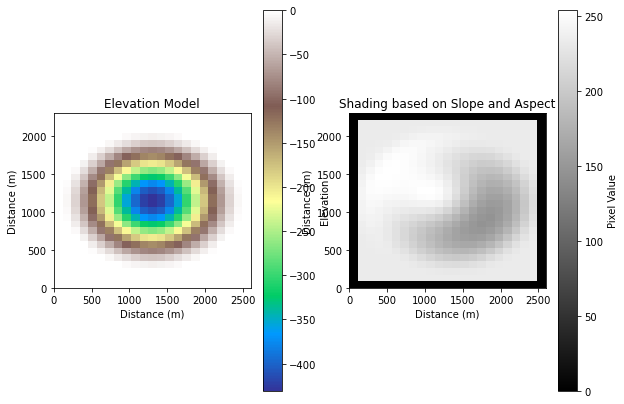

Image saved to TestHoles/hole_mx26_my23_slope13_el67_az57_xrad1056_yrad1085.pgm
Label image saved to TestHoles/hole_mx26_my23_slope13_el67_az57_xrad1056_yrad1085LABEL.pgm


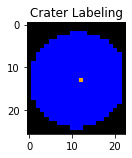

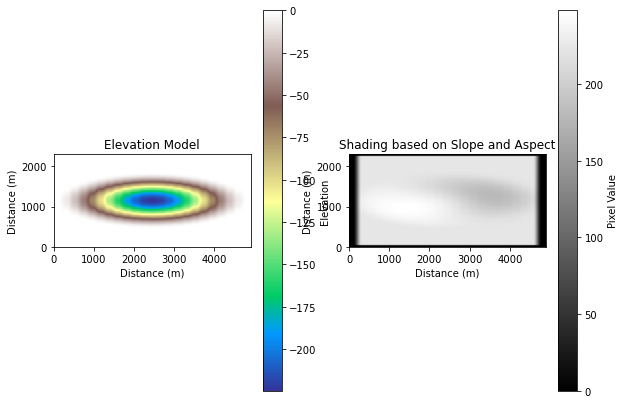

Image saved to TestHoles/hole_mx49_my23_slope24_el61_az122_xrad1478_yrad1132.pgm
Label image saved to TestHoles/hole_mx49_my23_slope24_el61_az122_xrad1478_yrad1132LABEL.pgm


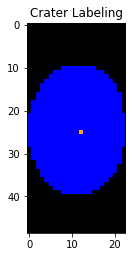

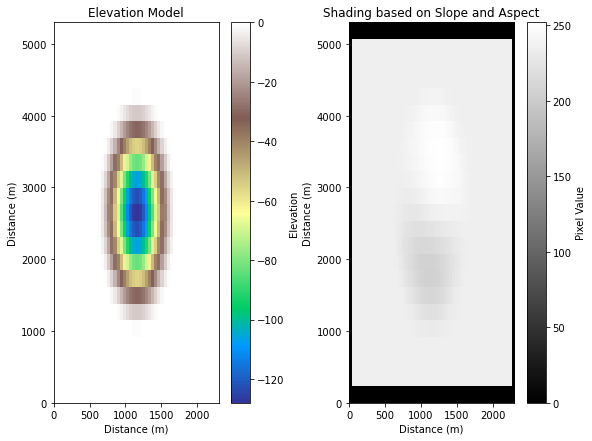

Image saved to TestHoles/hole_mx23_my53_slope38_el68_az338_xrad738_yrad1266.pgm
Label image saved to TestHoles/hole_mx23_my53_slope38_el68_az338_xrad738_yrad1266LABEL.pgm


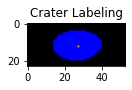

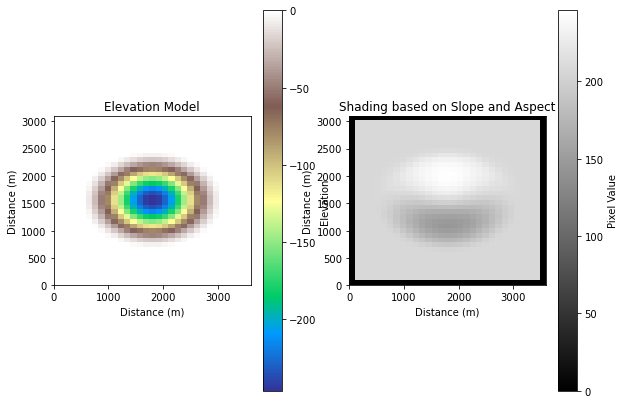

Image saved to TestHoles/hole_mx36_my31_slope22_el55_az1_xrad1049_yrad1137.pgm
Label image saved to TestHoles/hole_mx36_my31_slope22_el55_az1_xrad1049_yrad1137LABEL.pgm


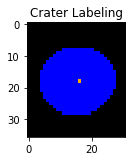

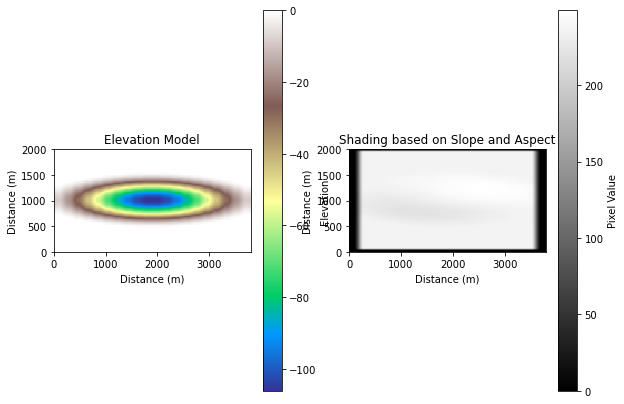

Image saved to TestHoles/hole_mx38_my20_slope43_el69_az320_xrad1019_yrad1160.pgm
Label image saved to TestHoles/hole_mx38_my20_slope43_el69_az320_xrad1019_yrad1160LABEL.pgm


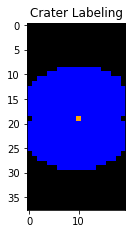

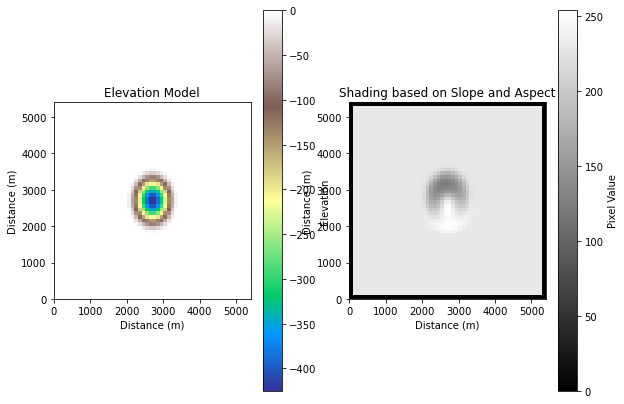

Image saved to TestHoles/hole_mx54_my54_slope13_el65_az187_xrad920_yrad725.pgm
Label image saved to TestHoles/hole_mx54_my54_slope13_el65_az187_xrad920_yrad725LABEL.pgm


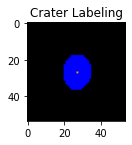

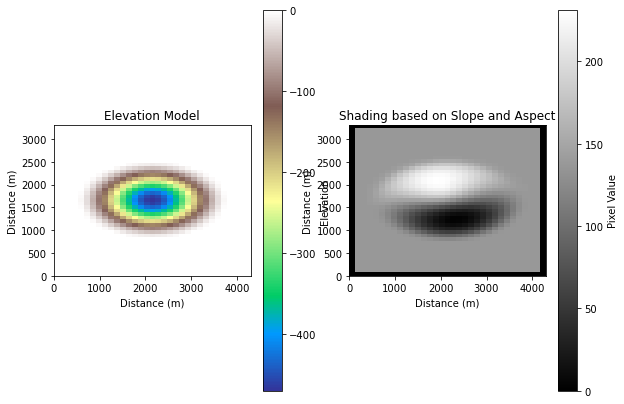

Image saved to TestHoles/hole_mx43_my33_slope12_el33_az15_xrad1130_yrad1294.pgm
Label image saved to TestHoles/hole_mx43_my33_slope12_el33_az15_xrad1130_yrad1294LABEL.pgm


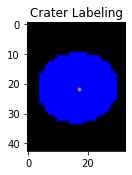

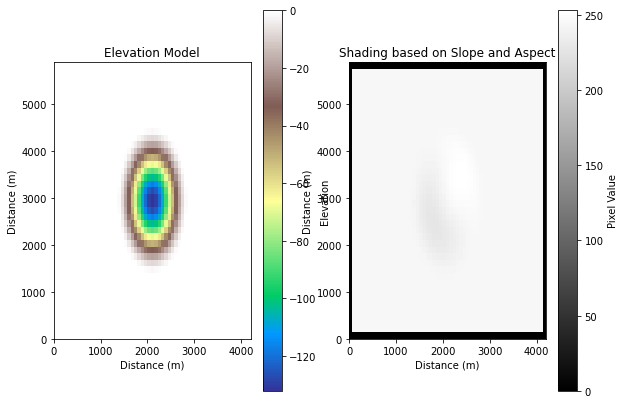

Image saved to TestHoles/hole_mx42_my59_slope37_el74_az312_xrad1128_yrad1064.pgm
Label image saved to TestHoles/hole_mx42_my59_slope37_el74_az312_xrad1128_yrad1064LABEL.pgm


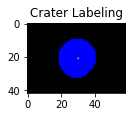

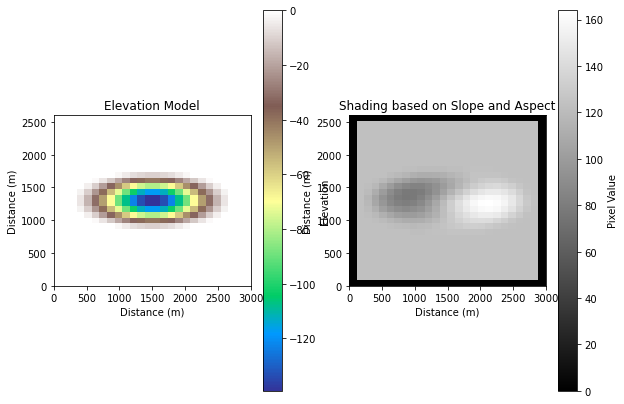

Image saved to TestHoles/hole_mx30_my26_slope35_el29_az262_xrad545_yrad1095.pgm
Label image saved to TestHoles/hole_mx30_my26_slope35_el29_az262_xrad545_yrad1095LABEL.pgm


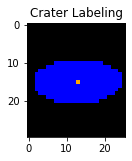

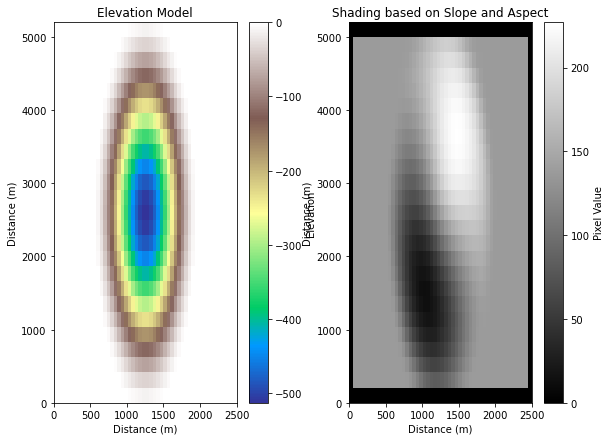

Image saved to TestHoles/hole_mx25_my52_slope11_el33_az321_xrad1325_yrad1474.pgm
Label image saved to TestHoles/hole_mx25_my52_slope11_el33_az321_xrad1325_yrad1474LABEL.pgm


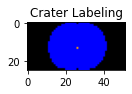

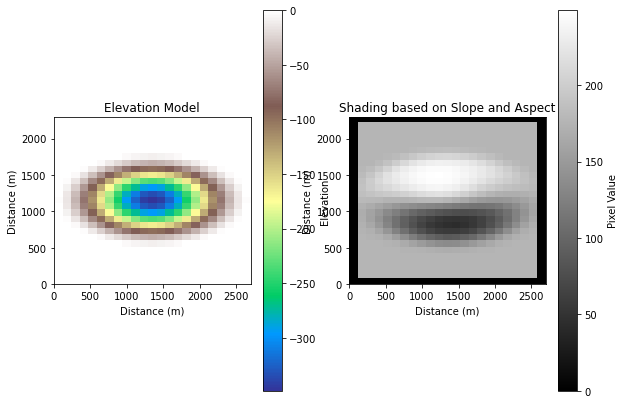

Image saved to TestHoles/hole_mx27_my23_slope16_el44_az11_xrad776_yrad1153.pgm
Label image saved to TestHoles/hole_mx27_my23_slope16_el44_az11_xrad776_yrad1153LABEL.pgm


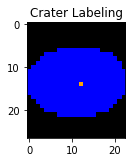

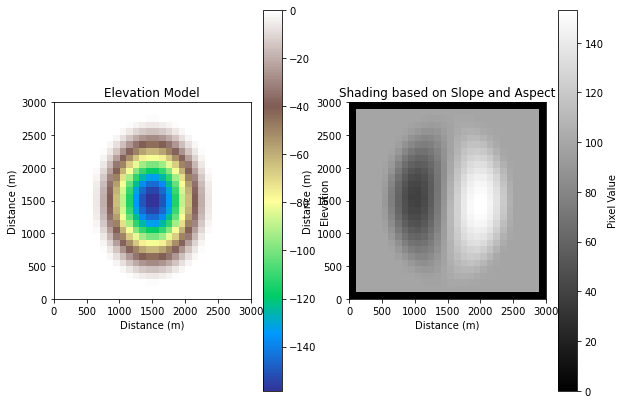

Image saved to TestHoles/hole_mx30_my30_slope32_el23_az264_xrad1315_yrad973.pgm
Label image saved to TestHoles/hole_mx30_my30_slope32_el23_az264_xrad1315_yrad973LABEL.pgm


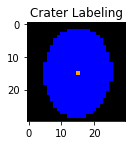

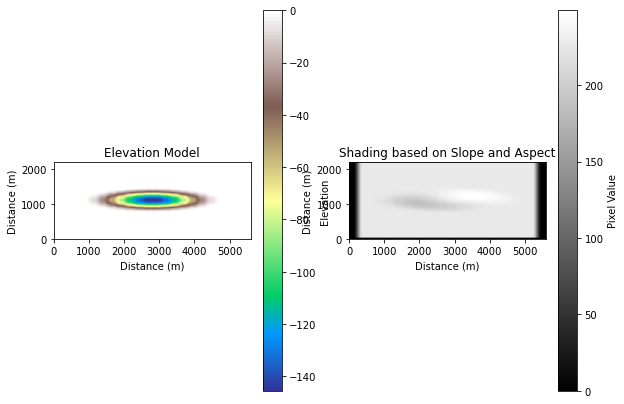

Image saved to TestHoles/hole_mx56_my22_slope34_el63_az312_xrad901_yrad767.pgm
Label image saved to TestHoles/hole_mx56_my22_slope34_el63_az312_xrad901_yrad767LABEL.pgm


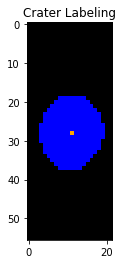

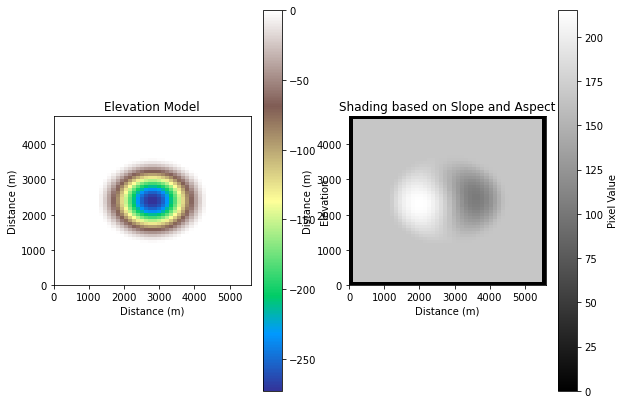

Image saved to TestHoles/hole_mx56_my48_slope20_el41_az98_xrad1435_yrad1396.pgm
Label image saved to TestHoles/hole_mx56_my48_slope20_el41_az98_xrad1435_yrad1396LABEL.pgm


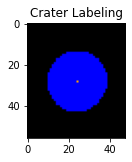

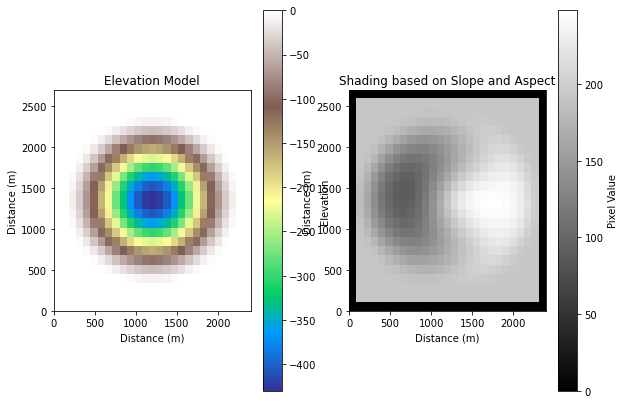

Image saved to TestHoles/hole_mx24_my27_slope13_el49_az265_xrad941_yrad1226.pgm
Label image saved to TestHoles/hole_mx24_my27_slope13_el49_az265_xrad941_yrad1226LABEL.pgm


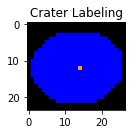

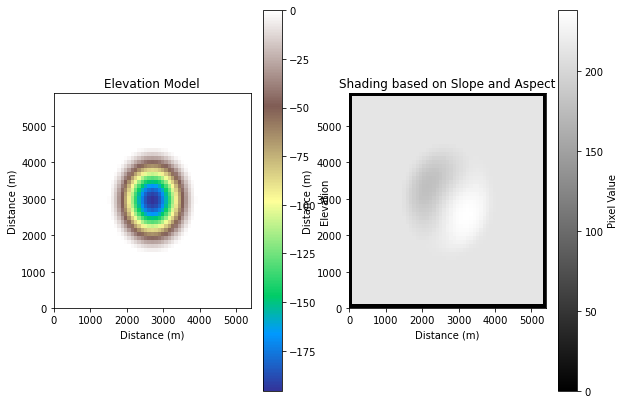

Image saved to TestHoles/hole_mx54_my59_slope27_el57_az237_xrad1396_yrad1357.pgm
Label image saved to TestHoles/hole_mx54_my59_slope27_el57_az237_xrad1396_yrad1357LABEL.pgm


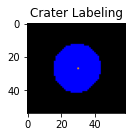

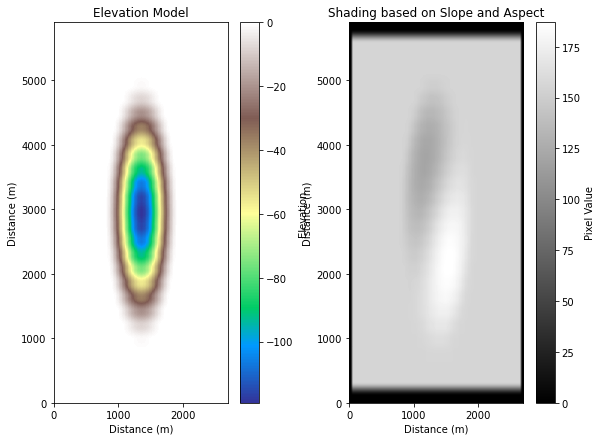

Image saved to TestHoles/hole_mx27_my59_slope40_el38_az227_xrad961_yrad1237.pgm
Label image saved to TestHoles/hole_mx27_my59_slope40_el38_az227_xrad961_yrad1237LABEL.pgm


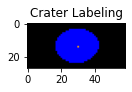

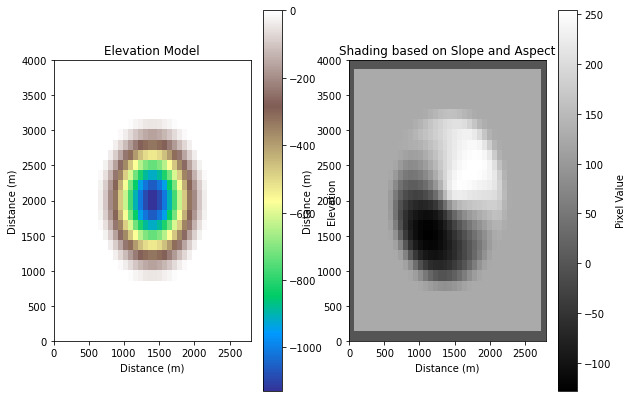

Image saved to TestHoles/hole_mx28_my40_slope5_el30_az318_xrad861_yrad1178.pgm
Label image saved to TestHoles/hole_mx28_my40_slope5_el30_az318_xrad861_yrad1178LABEL.pgm


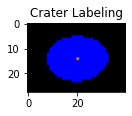

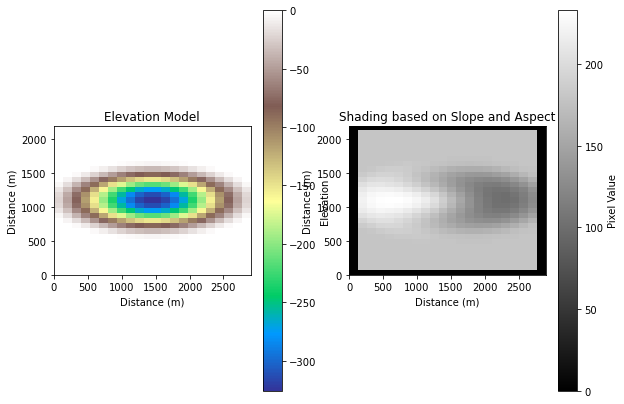

Image saved to TestHoles/hole_mx29_my22_slope17_el45_az92_xrad764_yrad1260.pgm
Label image saved to TestHoles/hole_mx29_my22_slope17_el45_az92_xrad764_yrad1260LABEL.pgm


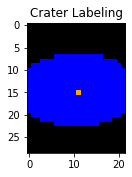

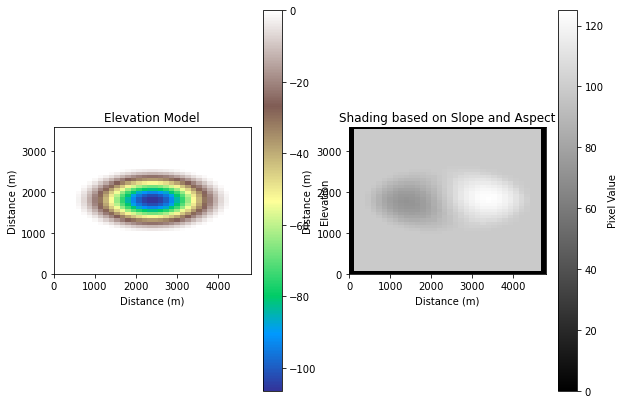

Image saved to TestHoles/hole_mx48_my36_slope43_el23_az276_xrad1083_yrad1488.pgm
Label image saved to TestHoles/hole_mx48_my36_slope43_el23_az276_xrad1083_yrad1488LABEL.pgm


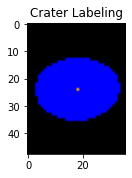

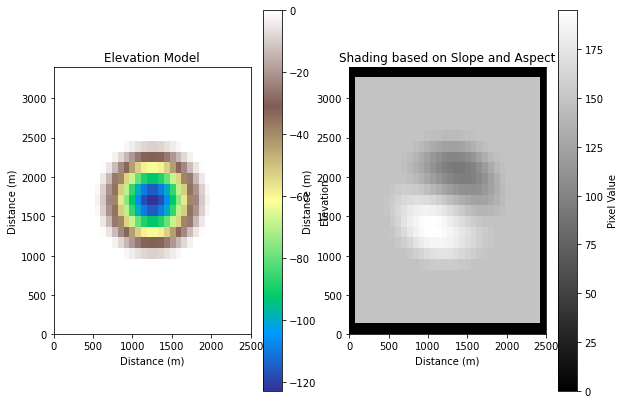

Image saved to TestHoles/hole_mx25_my34_slope39_el36_az141_xrad607_yrad1047.pgm
Label image saved to TestHoles/hole_mx25_my34_slope39_el36_az141_xrad607_yrad1047LABEL.pgm


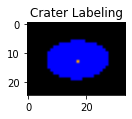

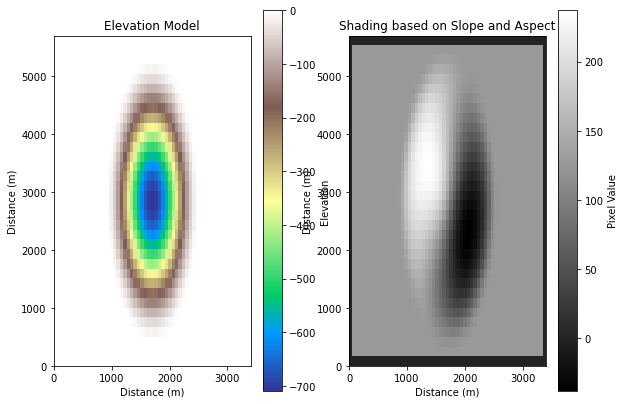

Image saved to TestHoles/hole_mx34_my57_slope8_el30_az61_xrad1480_yrad1349.pgm
Label image saved to TestHoles/hole_mx34_my57_slope8_el30_az61_xrad1480_yrad1349LABEL.pgm


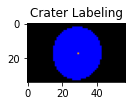

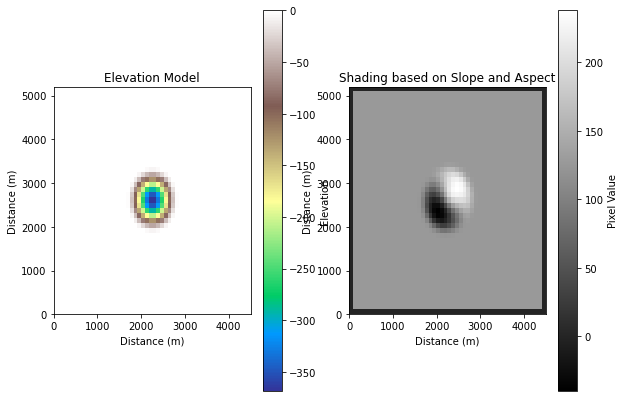

Image saved to TestHoles/hole_mx45_my52_slope15_el30_az313_xrad660_yrad686.pgm
Label image saved to TestHoles/hole_mx45_my52_slope15_el30_az313_xrad660_yrad686LABEL.pgm


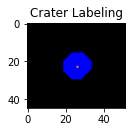

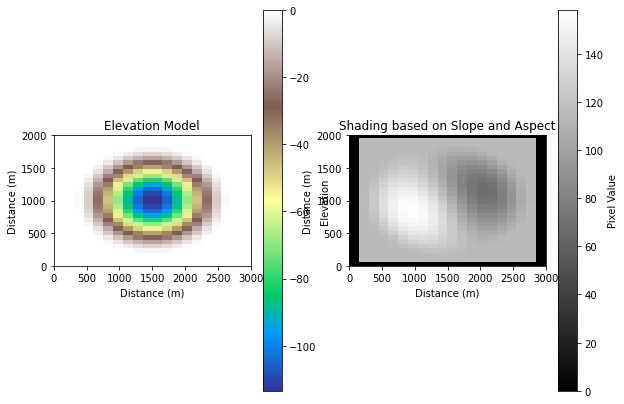

Image saved to TestHoles/hole_mx30_my20_slope41_el27_az121_xrad1262_yrad797.pgm
Label image saved to TestHoles/hole_mx30_my20_slope41_el27_az121_xrad1262_yrad797LABEL.pgm


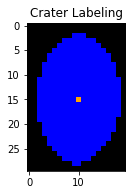

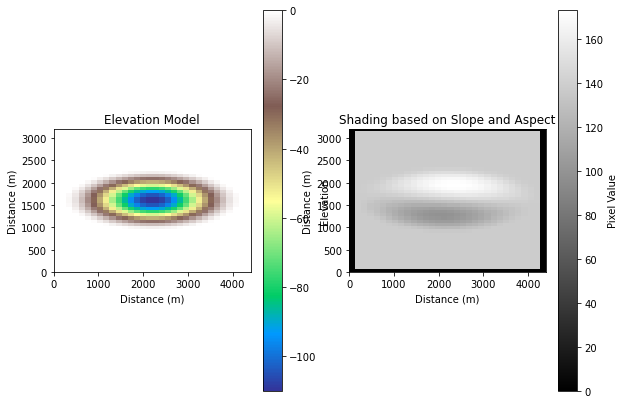

Image saved to TestHoles/hole_mx44_my32_slope42_el33_az346_xrad947_yrad1452.pgm
Label image saved to TestHoles/hole_mx44_my32_slope42_el33_az346_xrad947_yrad1452LABEL.pgm


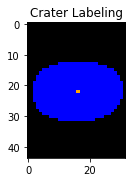

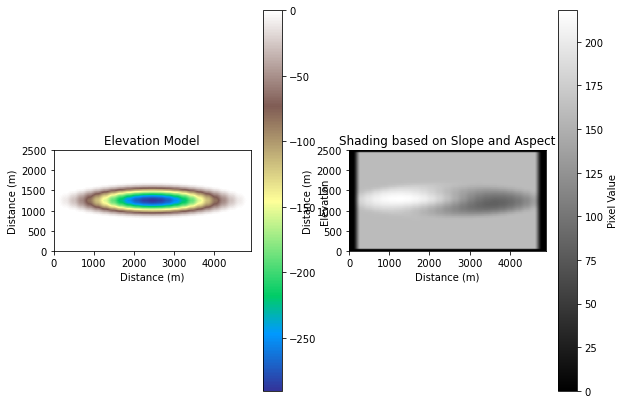

Image saved to TestHoles/hole_mx49_my25_slope19_el39_az79_xrad901_yrad1248.pgm
Label image saved to TestHoles/hole_mx49_my25_slope19_el39_az79_xrad901_yrad1248LABEL.pgm


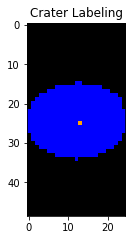

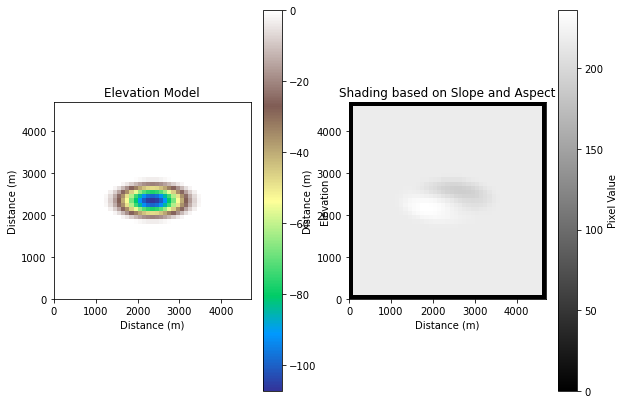

Image saved to TestHoles/hole_mx47_my47_slope43_el59_az119_xrad563_yrad1206.pgm
Label image saved to TestHoles/hole_mx47_my47_slope43_el59_az119_xrad563_yrad1206LABEL.pgm


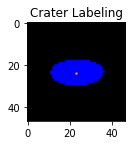

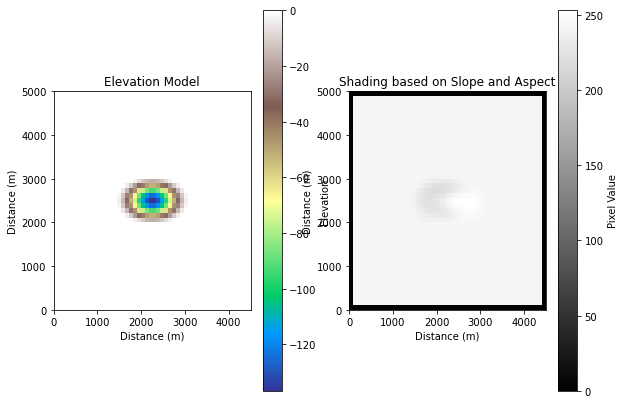

Image saved to TestHoles/hole_mx45_my50_slope36_el73_az259_xrad521_yrad953.pgm
Label image saved to TestHoles/hole_mx45_my50_slope36_el73_az259_xrad521_yrad953LABEL.pgm


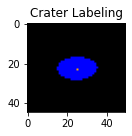

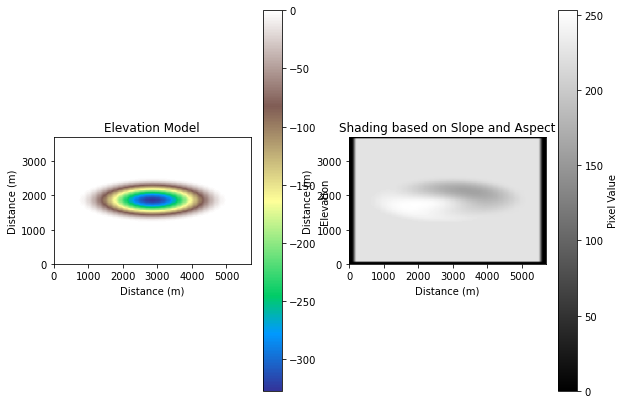

Image saved to TestHoles/hole_mx57_my37_slope17_el62_az124_xrad983_yrad1424.pgm
Label image saved to TestHoles/hole_mx57_my37_slope17_el62_az124_xrad983_yrad1424LABEL.pgm


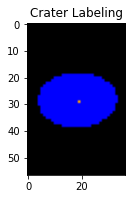

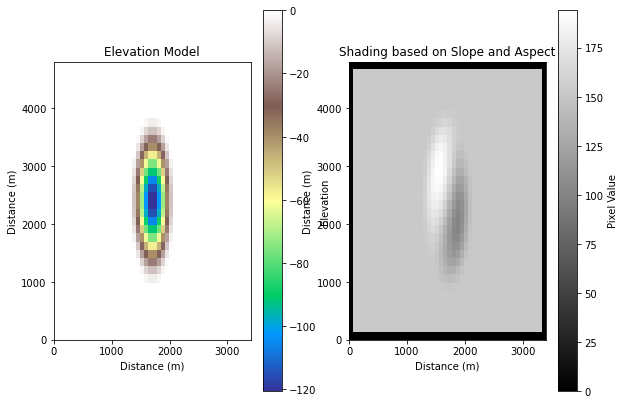

Image saved to TestHoles/hole_mx34_my48_slope39_el37_az37_xrad1068_yrad560.pgm
Label image saved to TestHoles/hole_mx34_my48_slope39_el37_az37_xrad1068_yrad560LABEL.pgm


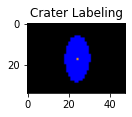

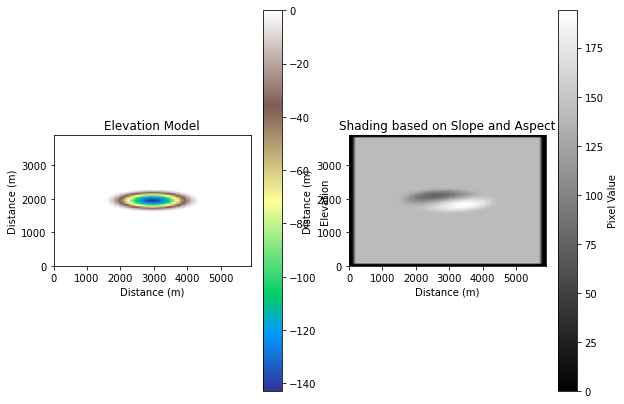

Image saved to TestHoles/hole_mx59_my39_slope35_el34_az232_xrad525_yrad973.pgm
Label image saved to TestHoles/hole_mx59_my39_slope35_el34_az232_xrad525_yrad973LABEL.pgm


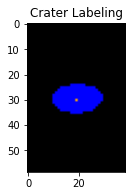

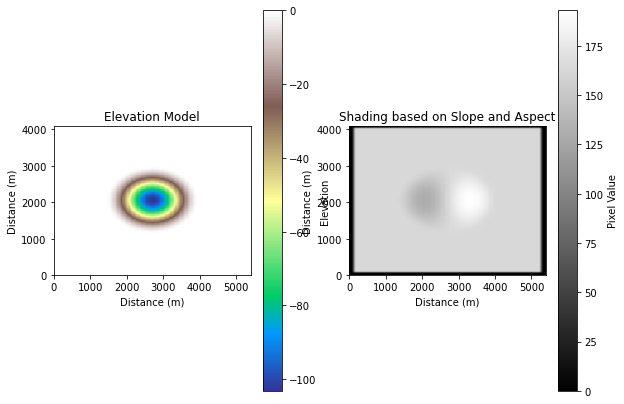

Image saved to TestHoles/hole_mx54_my41_slope44_el40_az270_xrad1215_yrad963.pgm
Label image saved to TestHoles/hole_mx54_my41_slope44_el40_az270_xrad1215_yrad963LABEL.pgm


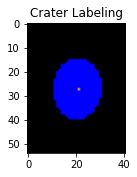

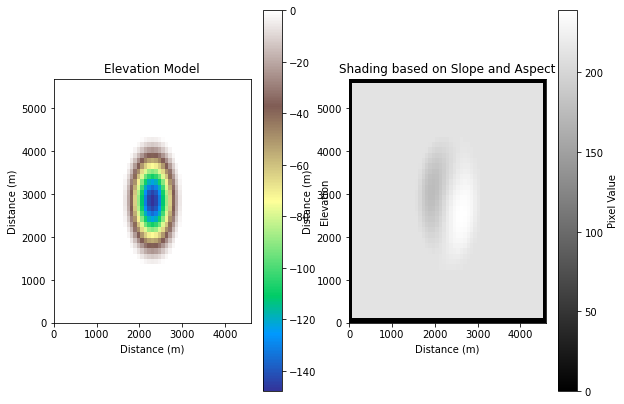

Image saved to TestHoles/hole_mx46_my57_slope34_el57_az243_xrad1288_yrad916.pgm
Label image saved to TestHoles/hole_mx46_my57_slope34_el57_az243_xrad1288_yrad916LABEL.pgm


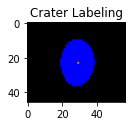

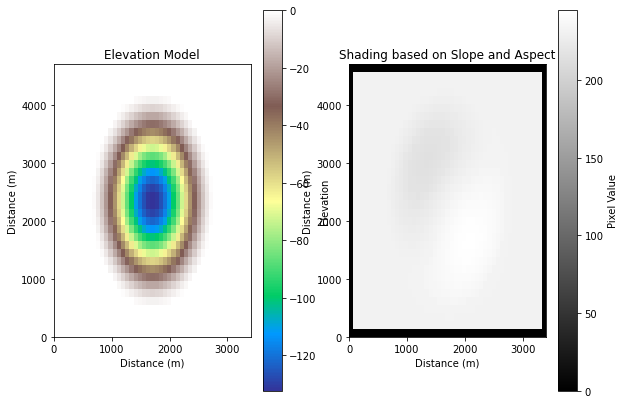

Image saved to TestHoles/hole_mx34_my47_slope37_el66_az225_xrad1382_yrad1490.pgm
Label image saved to TestHoles/hole_mx34_my47_slope37_el66_az225_xrad1382_yrad1490LABEL.pgm


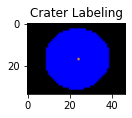

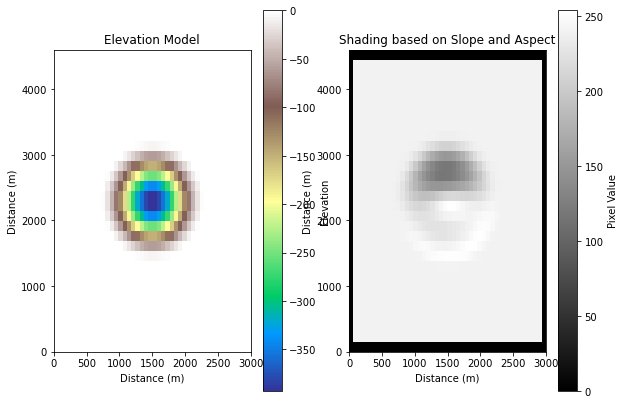

Image saved to TestHoles/hole_mx30_my46_slope14_el71_az199_xrad602_yrad1221.pgm
Label image saved to TestHoles/hole_mx30_my46_slope14_el71_az199_xrad602_yrad1221LABEL.pgm


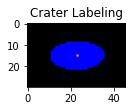

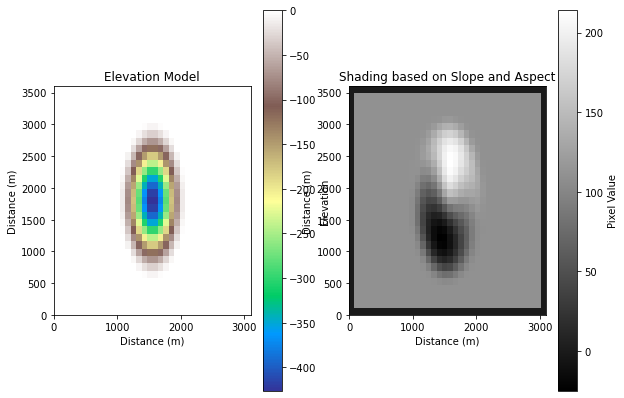

Image saved to TestHoles/hole_mx31_my36_slope13_el26_az347_xrad1091_yrad623.pgm
Label image saved to TestHoles/hole_mx31_my36_slope13_el26_az347_xrad1091_yrad623LABEL.pgm


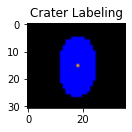

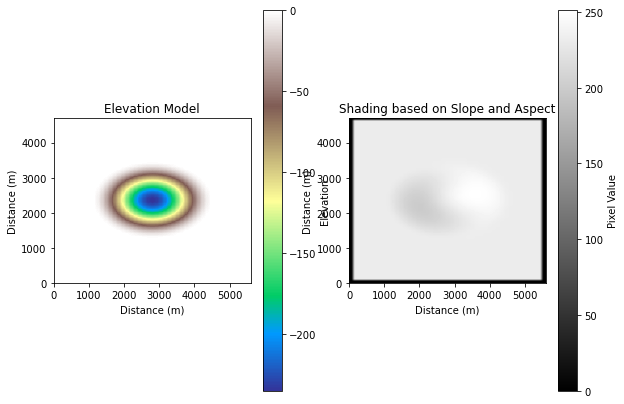

Image saved to TestHoles/hole_mx56_my47_slope23_el66_az289_xrad1309_yrad1442.pgm
Label image saved to TestHoles/hole_mx56_my47_slope23_el66_az289_xrad1309_yrad1442LABEL.pgm


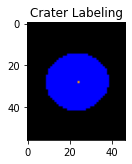

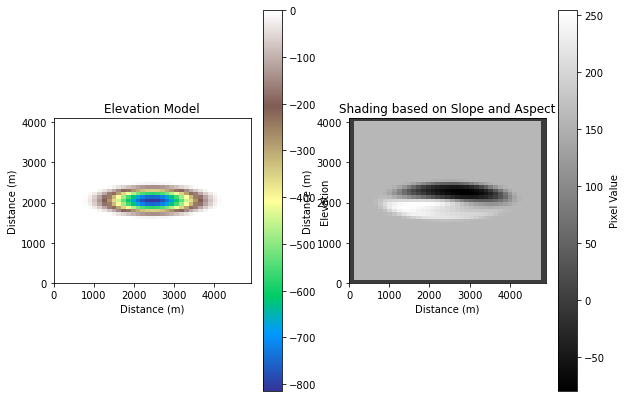

Image saved to TestHoles/hole_mx49_my41_slope7_el39_az140_xrad550_yrad1496.pgm
Label image saved to TestHoles/hole_mx49_my41_slope7_el39_az140_xrad550_yrad1496LABEL.pgm


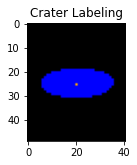

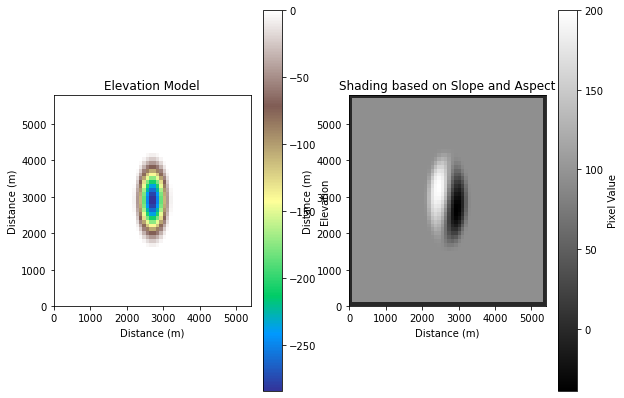

Image saved to TestHoles/hole_mx54_my58_slope19_el22_az55_xrad1286_yrad608.pgm
Label image saved to TestHoles/hole_mx54_my58_slope19_el22_az55_xrad1286_yrad608LABEL.pgm


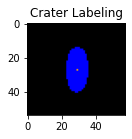

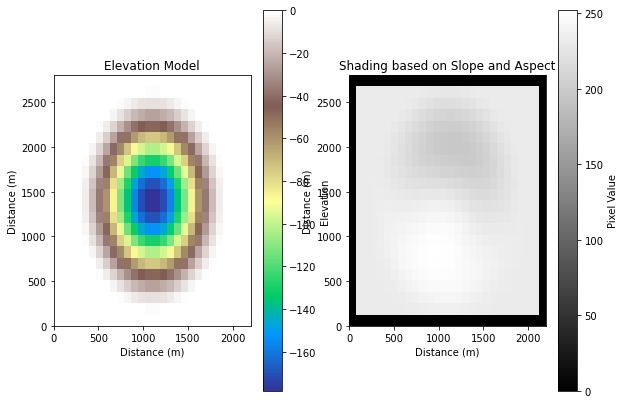

Image saved to TestHoles/hole_mx22_my28_slope29_el66_az166_xrad993_yrad1072.pgm
Label image saved to TestHoles/hole_mx22_my28_slope29_el66_az166_xrad993_yrad1072LABEL.pgm


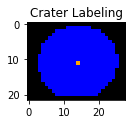

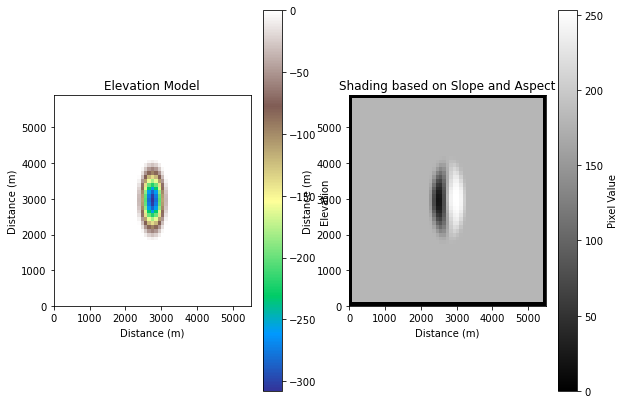

Image saved to TestHoles/hole_mx55_my59_slope18_el45_az273_xrad1123_yrad508.pgm
Label image saved to TestHoles/hole_mx55_my59_slope18_el45_az273_xrad1123_yrad508LABEL.pgm


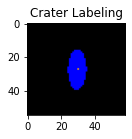

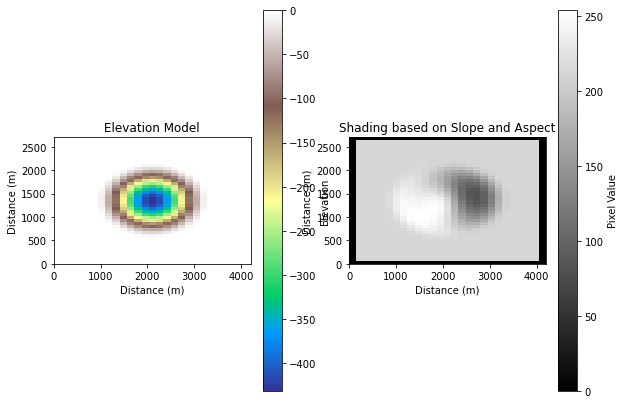

Image saved to TestHoles/hole_mx42_my27_slope13_el57_az119_xrad1251_yrad783.pgm
Label image saved to TestHoles/hole_mx42_my27_slope13_el57_az119_xrad1251_yrad783LABEL.pgm


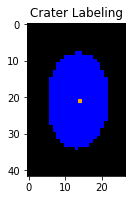

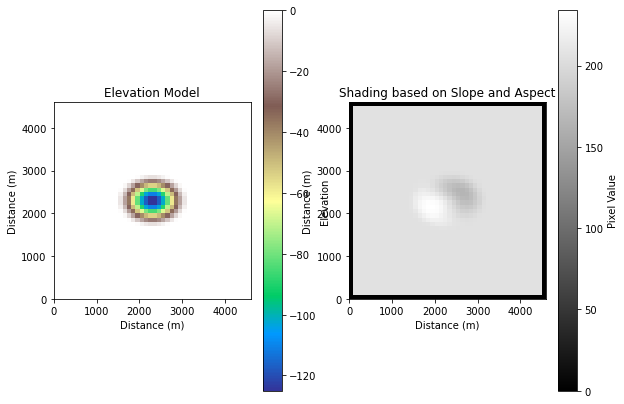

Image saved to TestHoles/hole_mx46_my46_slope38_el54_az115_xrad640_yrad863.pgm
Label image saved to TestHoles/hole_mx46_my46_slope38_el54_az115_xrad640_yrad863LABEL.pgm


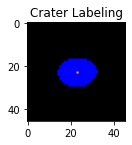

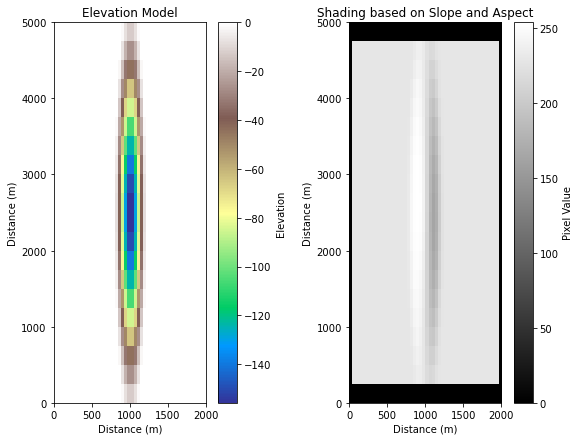

Image saved to TestHoles/hole_mx20_my50_slope32_el64_az83_xrad1169_yrad528.pgm
Label image saved to TestHoles/hole_mx20_my50_slope32_el64_az83_xrad1169_yrad528LABEL.pgm


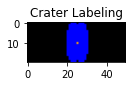

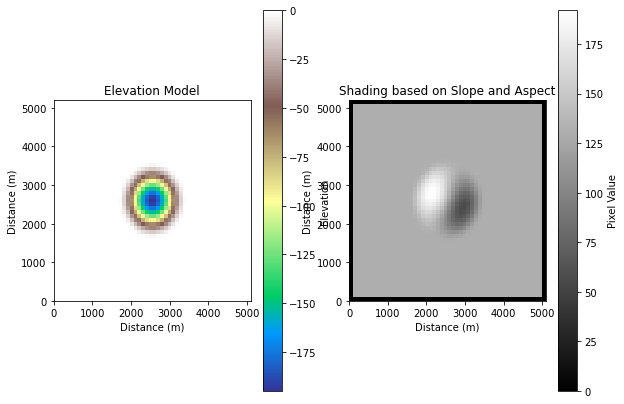

Image saved to TestHoles/hole_mx51_my52_slope27_el31_az65_xrad982_yrad902.pgm
Label image saved to TestHoles/hole_mx51_my52_slope27_el31_az65_xrad982_yrad902LABEL.pgm


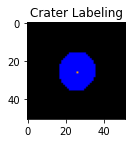

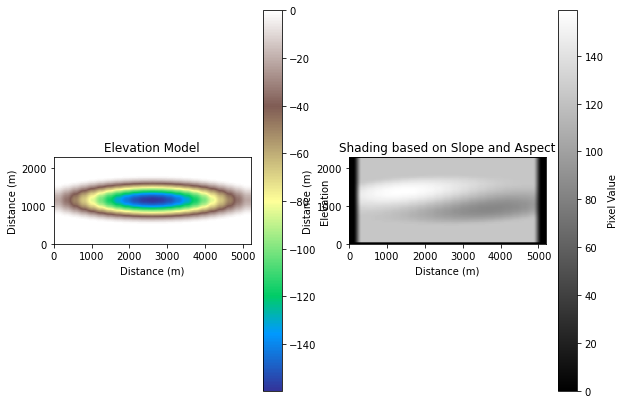

Image saved to TestHoles/hole_mx52_my23_slope32_el29_az46_xrad1465_yrad1445.pgm
Label image saved to TestHoles/hole_mx52_my23_slope32_el29_az46_xrad1465_yrad1445LABEL.pgm


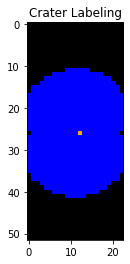

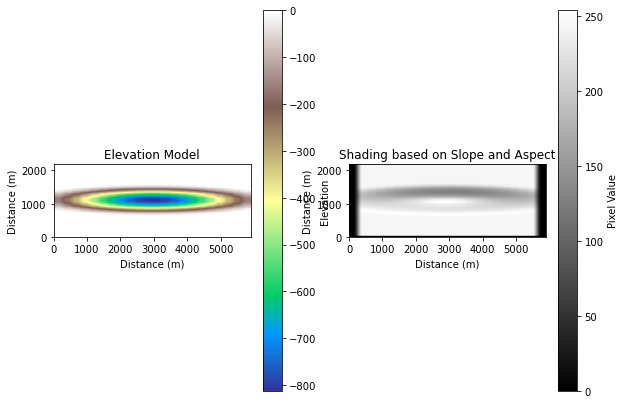

Image saved to TestHoles/hole_mx59_my22_slope7_el74_az171_xrad1303_yrad1490.pgm
Label image saved to TestHoles/hole_mx59_my22_slope7_el74_az171_xrad1303_yrad1490LABEL.pgm


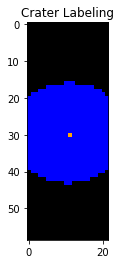

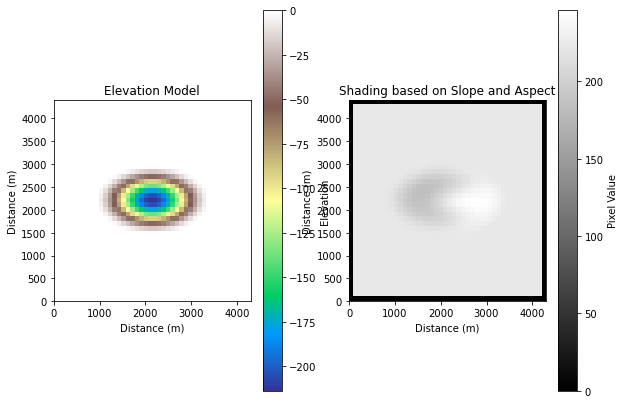

Image saved to TestHoles/hole_mx43_my44_slope25_el61_az263_xrad737_yrad1298.pgm
Label image saved to TestHoles/hole_mx43_my44_slope25_el61_az263_xrad737_yrad1298LABEL.pgm


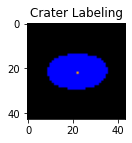

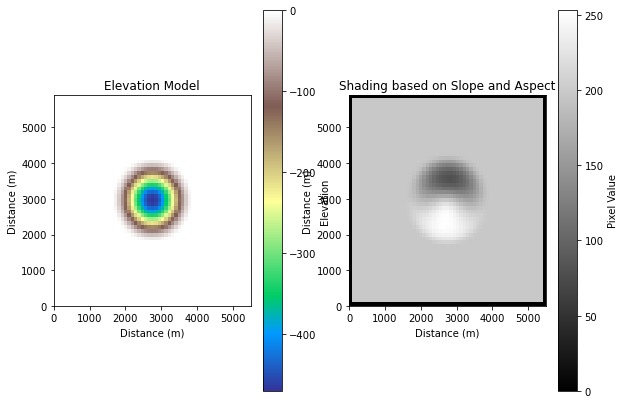

Image saved to TestHoles/hole_mx55_my59_slope12_el51_az174_xrad1138_yrad1230.pgm
Label image saved to TestHoles/hole_mx55_my59_slope12_el51_az174_xrad1138_yrad1230LABEL.pgm


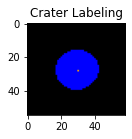

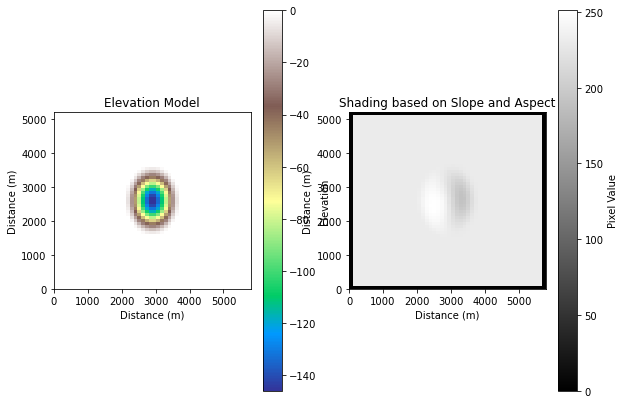

Image saved to TestHoles/hole_mx58_my52_slope34_el65_az106_xrad1194_yrad751.pgm
Label image saved to TestHoles/hole_mx58_my52_slope34_el65_az106_xrad1194_yrad751LABEL.pgm


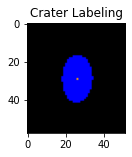

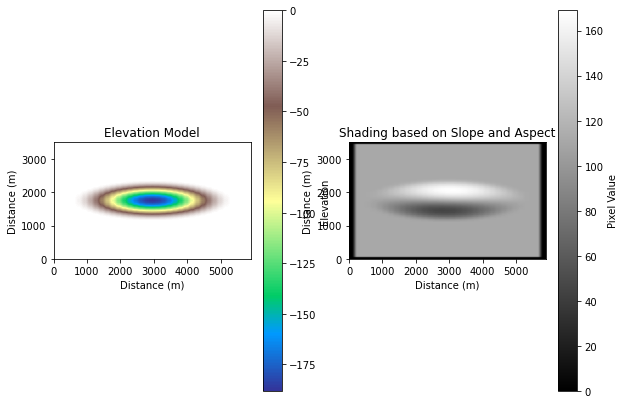

Image saved to TestHoles/hole_mx59_my35_slope28_el26_az352_xrad1030_yrad1435.pgm
Label image saved to TestHoles/hole_mx59_my35_slope28_el26_az352_xrad1030_yrad1435LABEL.pgm


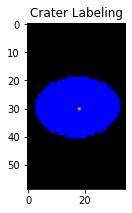

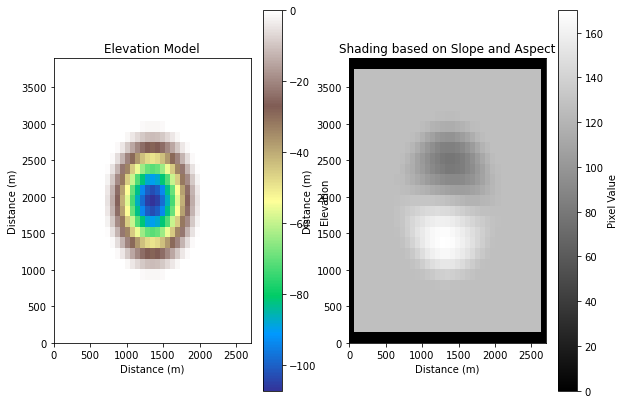

Image saved to TestHoles/hole_mx27_my39_slope43_el30_az170_xrad760_yrad1040.pgm
Label image saved to TestHoles/hole_mx27_my39_slope43_el30_az170_xrad760_yrad1040LABEL.pgm


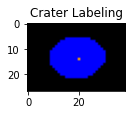

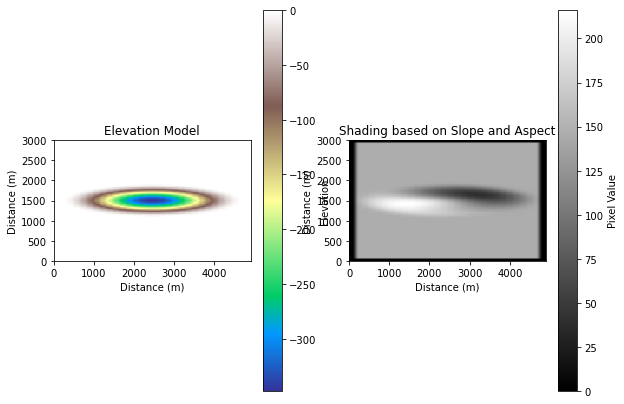

Image saved to TestHoles/hole_mx49_my30_slope16_el35_az114_xrad654_yrad1375.pgm
Label image saved to TestHoles/hole_mx49_my30_slope16_el35_az114_xrad654_yrad1375LABEL.pgm


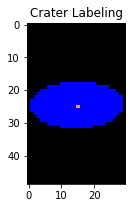

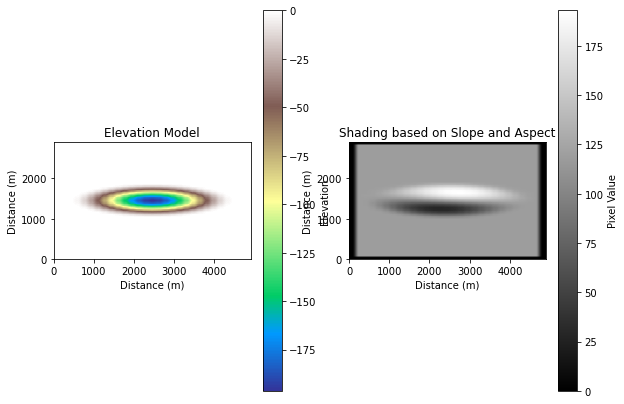

Image saved to TestHoles/hole_mx49_my29_slope27_el28_az341_xrad713_yrad1200.pgm
Label image saved to TestHoles/hole_mx49_my29_slope27_el28_az341_xrad713_yrad1200LABEL.pgm


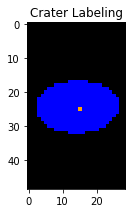

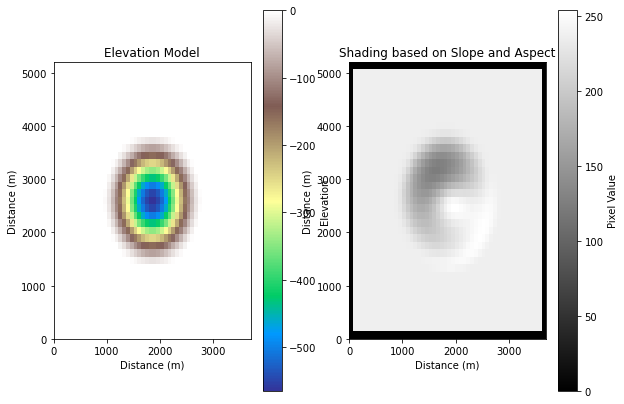

Image saved to TestHoles/hole_mx37_my52_slope10_el69_az228_xrad928_yrad1330.pgm
Label image saved to TestHoles/hole_mx37_my52_slope10_el69_az228_xrad928_yrad1330LABEL.pgm


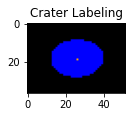

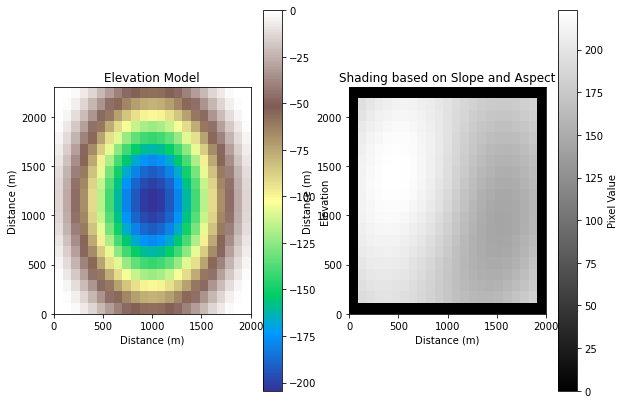

Image saved to TestHoles/hole_mx20_my23_slope26_el48_az70_xrad1478_yrad1312.pgm
Label image saved to TestHoles/hole_mx20_my23_slope26_el48_az70_xrad1478_yrad1312LABEL.pgm


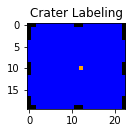

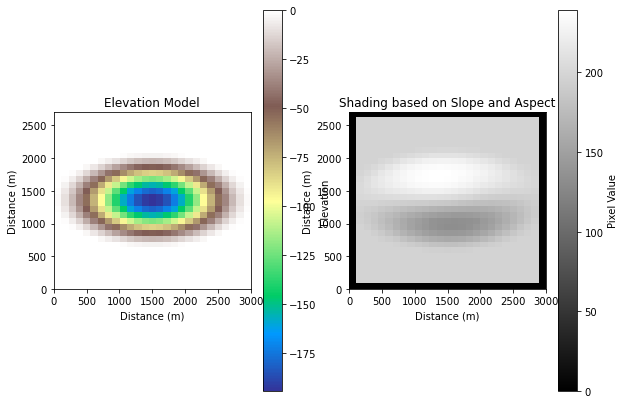

Image saved to TestHoles/hole_mx30_my27_slope27_el51_az13_xrad828_yrad1398.pgm
Label image saved to TestHoles/hole_mx30_my27_slope27_el51_az13_xrad828_yrad1398LABEL.pgm


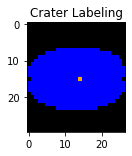

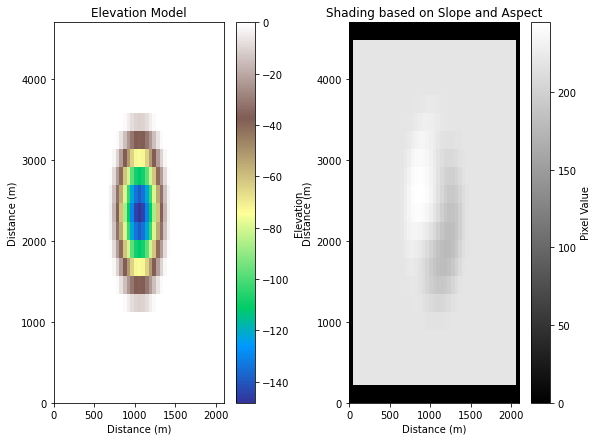

Image saved to TestHoles/hole_mx21_my47_slope34_el60_az66_xrad606_yrad894.pgm
Label image saved to TestHoles/hole_mx21_my47_slope34_el60_az66_xrad606_yrad894LABEL.pgm


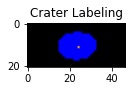

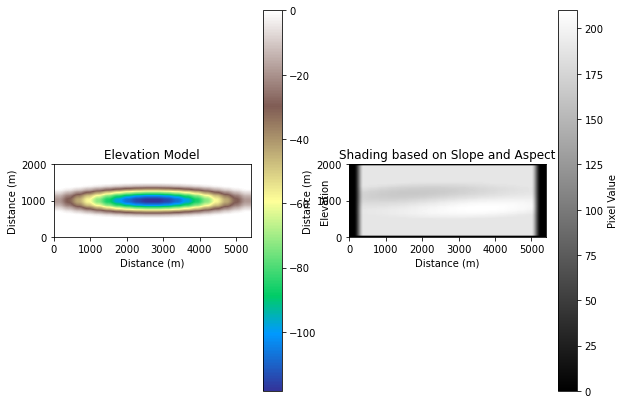

Image saved to TestHoles/hole_mx54_my20_slope40_el48_az212_xrad1383_yrad1285.pgm
Label image saved to TestHoles/hole_mx54_my20_slope40_el48_az212_xrad1383_yrad1285LABEL.pgm


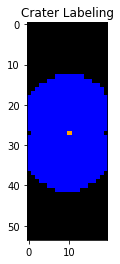

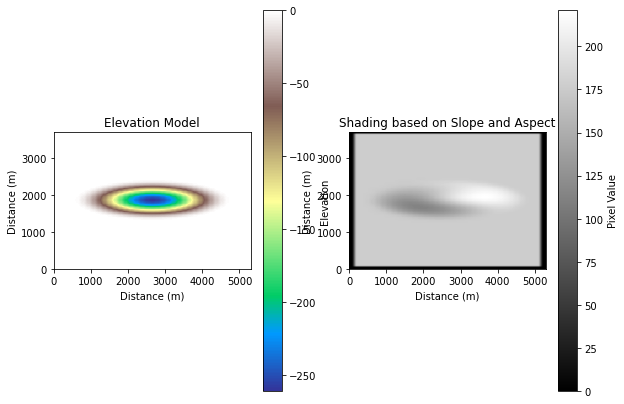

Image saved to TestHoles/hole_mx53_my37_slope21_el44_az289_xrad769_yrad1480.pgm
Label image saved to TestHoles/hole_mx53_my37_slope21_el44_az289_xrad769_yrad1480LABEL.pgm


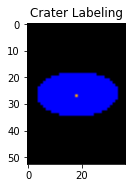

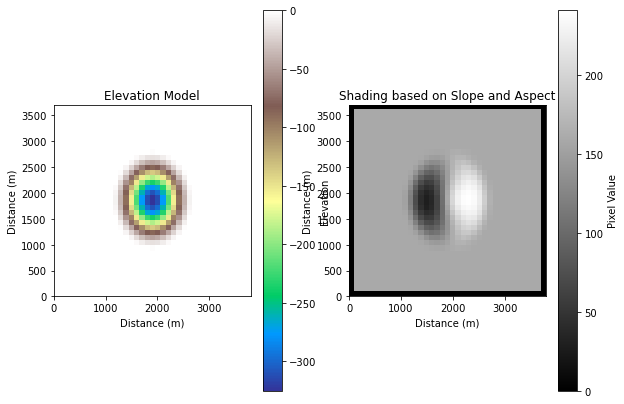

Image saved to TestHoles/hole_mx38_my37_slope17_el39_az273_xrad993_yrad776.pgm
Label image saved to TestHoles/hole_mx38_my37_slope17_el39_az273_xrad993_yrad776LABEL.pgm


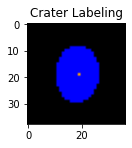

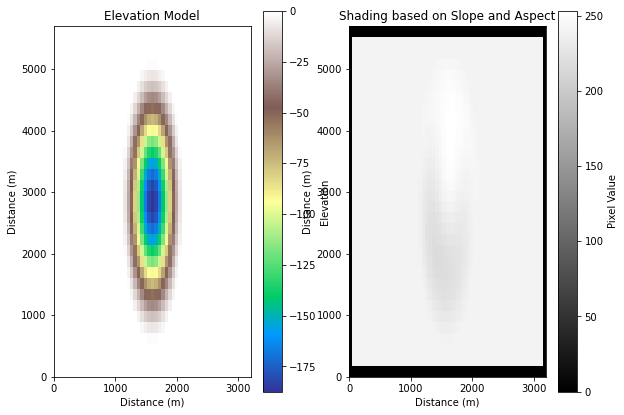

Image saved to TestHoles/hole_mx32_my57_slope28_el72_az347_xrad1320_yrad920.pgm
Label image saved to TestHoles/hole_mx32_my57_slope28_el72_az347_xrad1320_yrad920LABEL.pgm


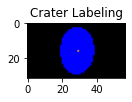

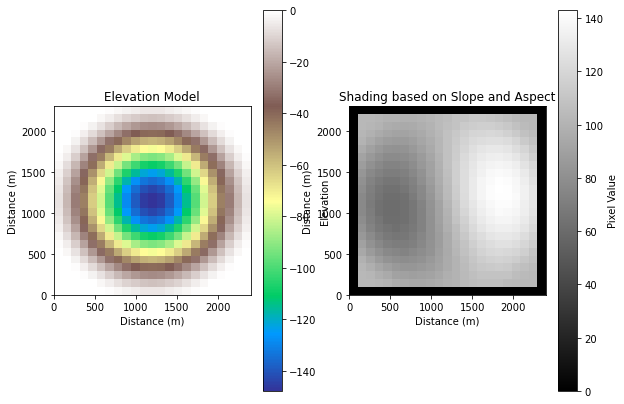

Image saved to TestHoles/hole_mx24_my23_slope34_el24_az279_xrad1312_yrad1277.pgm
Label image saved to TestHoles/hole_mx24_my23_slope34_el24_az279_xrad1312_yrad1277LABEL.pgm


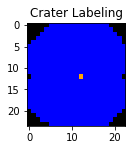

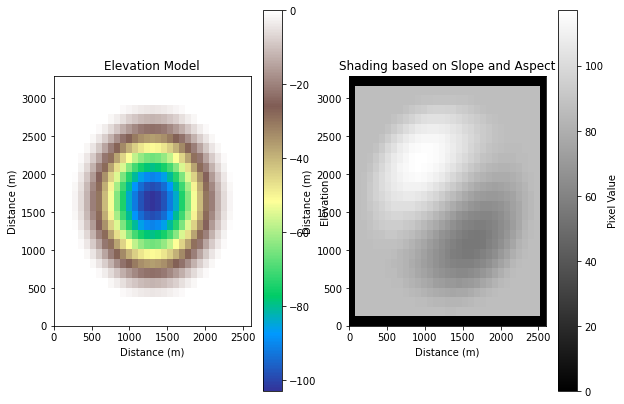

Image saved to TestHoles/hole_mx26_my33_slope44_el20_az44_xrad1090_yrad1416.pgm
Label image saved to TestHoles/hole_mx26_my33_slope44_el20_az44_xrad1090_yrad1416LABEL.pgm


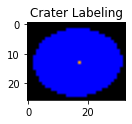

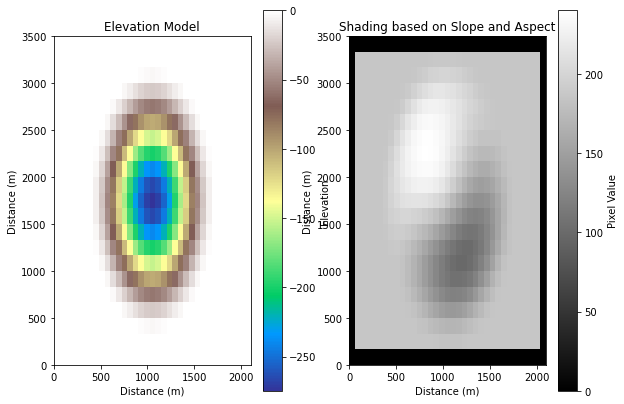

Image saved to TestHoles/hole_mx21_my35_slope20_el47_az40_xrad861_yrad1118.pgm
Label image saved to TestHoles/hole_mx21_my35_slope20_el47_az40_xrad861_yrad1118LABEL.pgm


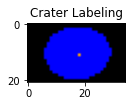

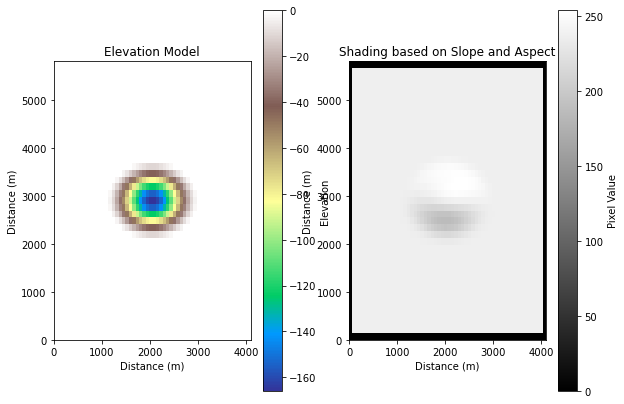

Image saved to TestHoles/hole_mx41_my58_slope31_el69_az338_xrad597_yrad1378.pgm
Label image saved to TestHoles/hole_mx41_my58_slope31_el69_az338_xrad597_yrad1378LABEL.pgm


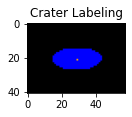

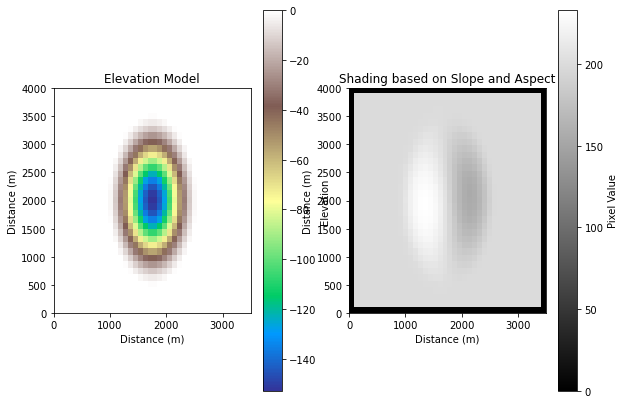

Image saved to TestHoles/hole_mx35_my40_slope33_el52_az98_xrad1360_yrad920.pgm
Label image saved to TestHoles/hole_mx35_my40_slope33_el52_az98_xrad1360_yrad920LABEL.pgm


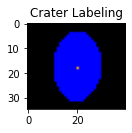

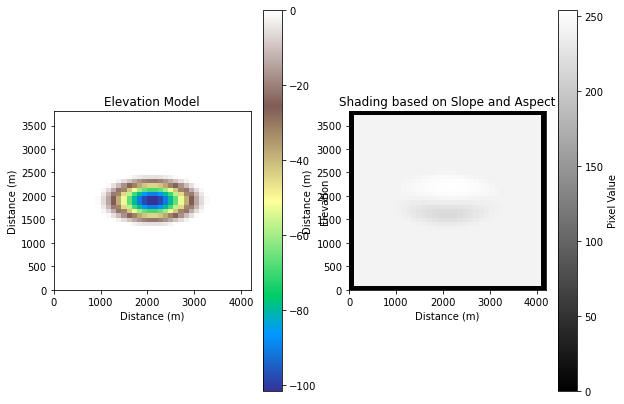

Image saved to TestHoles/hole_mx42_my38_slope44_el72_az355_xrad642_yrad1125.pgm
Label image saved to TestHoles/hole_mx42_my38_slope44_el72_az355_xrad642_yrad1125LABEL.pgm


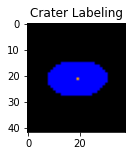

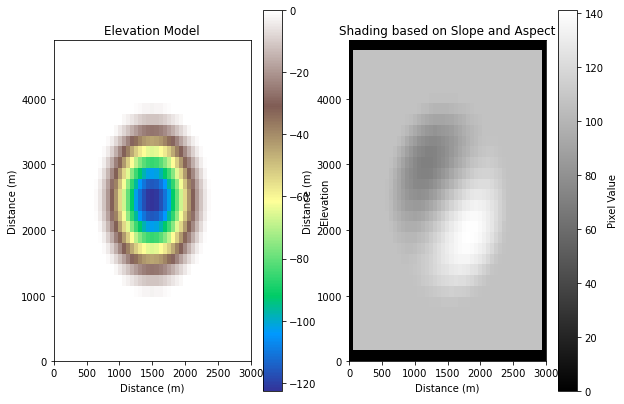

Image saved to TestHoles/hole_mx30_my49_slope39_el25_az237_xrad934_yrad1492.pgm
Label image saved to TestHoles/hole_mx30_my49_slope39_el25_az237_xrad934_yrad1492LABEL.pgm


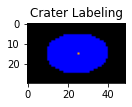

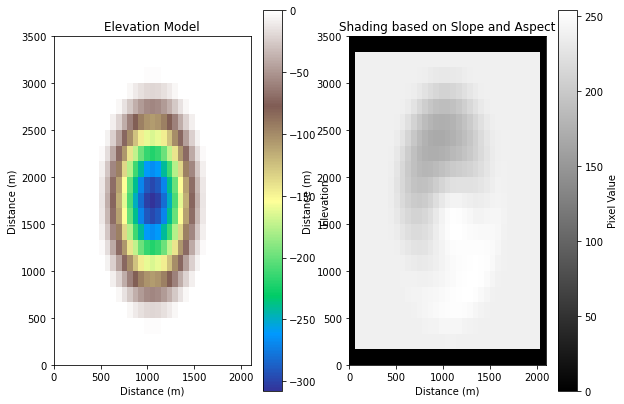

Image saved to TestHoles/hole_mx21_my35_slope18_el70_az209_xrad838_yrad1035.pgm
Label image saved to TestHoles/hole_mx21_my35_slope18_el70_az209_xrad838_yrad1035LABEL.pgm


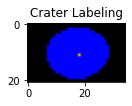

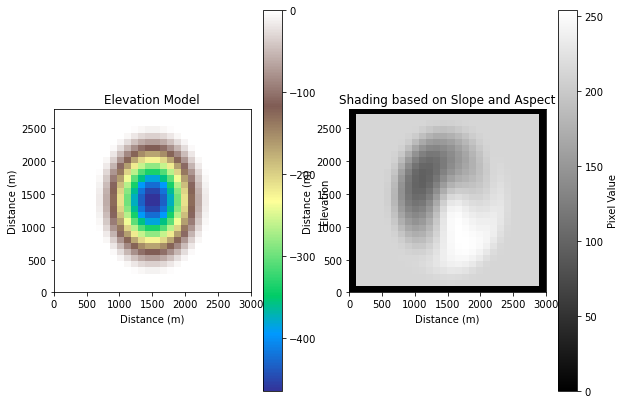

Image saved to TestHoles/hole_mx30_my28_slope12_el57_az215_xrad1272_yrad847.pgm
Label image saved to TestHoles/hole_mx30_my28_slope12_el57_az215_xrad1272_yrad847LABEL.pgm


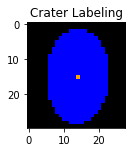

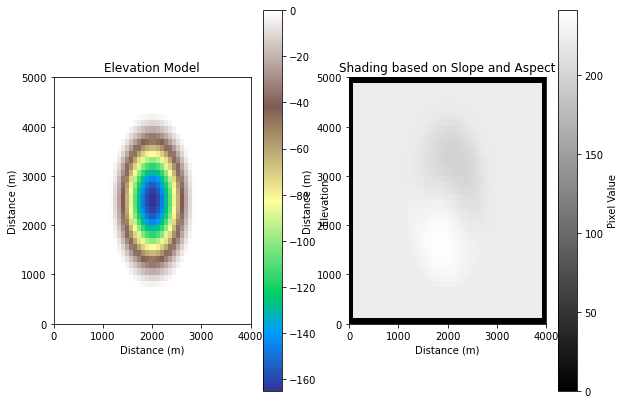

Image saved to TestHoles/hole_mx40_my50_slope31_el61_az165_xrad1496_yrad1128.pgm
Label image saved to TestHoles/hole_mx40_my50_slope31_el61_az165_xrad1496_yrad1128LABEL.pgm


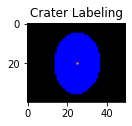

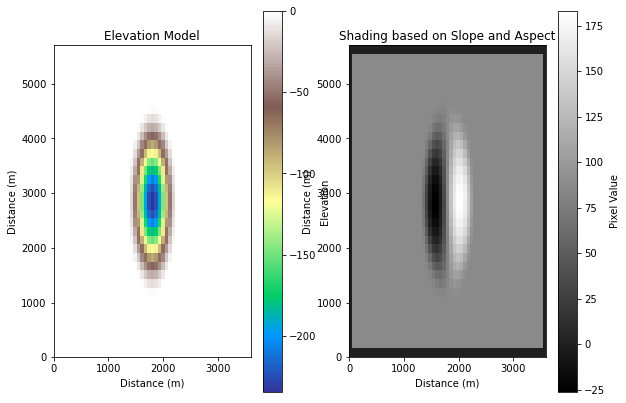

Image saved to TestHoles/hole_mx36_my57_slope23_el20_az272_xrad1113_yrad718.pgm
Label image saved to TestHoles/hole_mx36_my57_slope23_el20_az272_xrad1113_yrad718LABEL.pgm


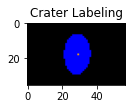

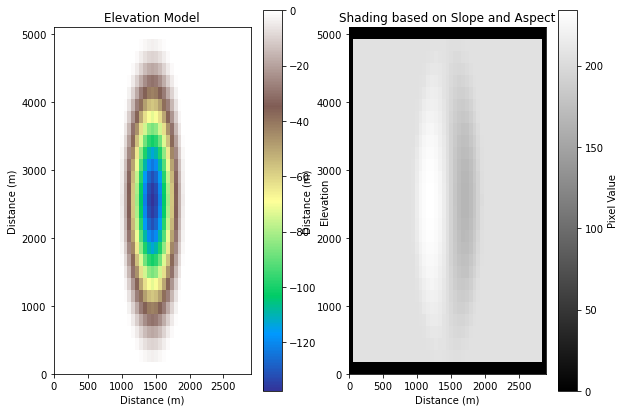

Image saved to TestHoles/hole_mx29_my51_slope36_el54_az91_xrad1446_yrad904.pgm
Label image saved to TestHoles/hole_mx29_my51_slope36_el54_az91_xrad1446_yrad904LABEL.pgm


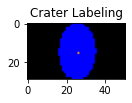

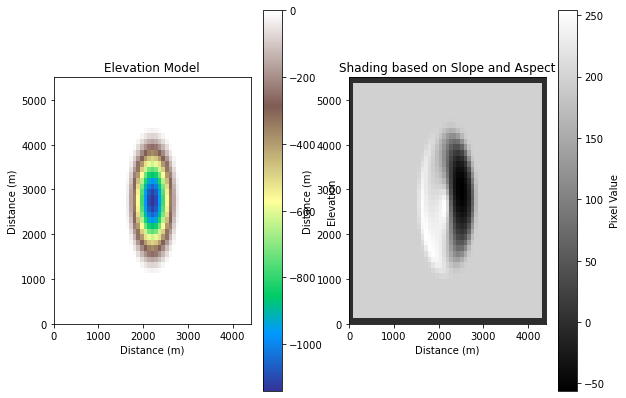

Image saved to TestHoles/hole_mx44_my55_slope5_el51_az113_xrad1383_yrad794.pgm
Label image saved to TestHoles/hole_mx44_my55_slope5_el51_az113_xrad1383_yrad794LABEL.pgm


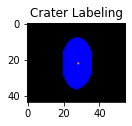

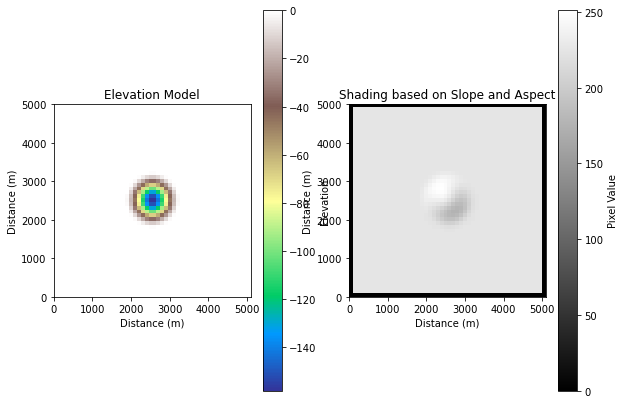

Image saved to TestHoles/hole_mx51_my50_slope32_el62_az34_xrad735_yrad699.pgm
Label image saved to TestHoles/hole_mx51_my50_slope32_el62_az34_xrad735_yrad699LABEL.pgm


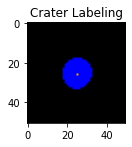

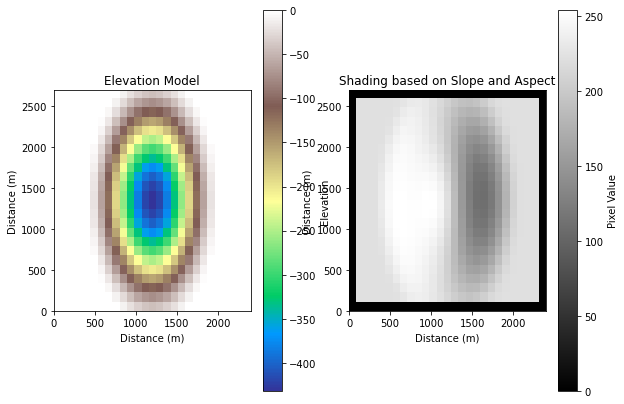

Image saved to TestHoles/hole_mx24_my27_slope13_el61_az95_xrad1444_yrad929.pgm
Label image saved to TestHoles/hole_mx24_my27_slope13_el61_az95_xrad1444_yrad929LABEL.pgm


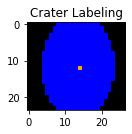

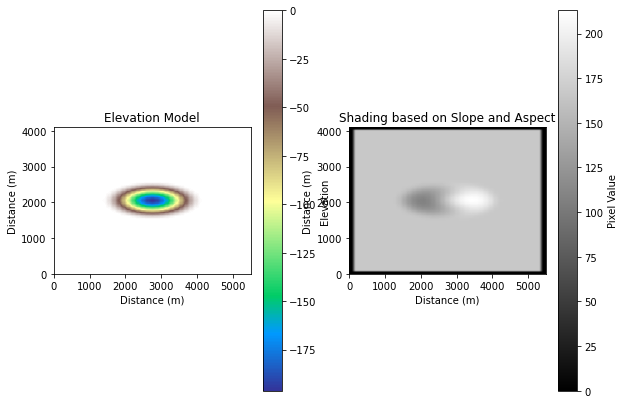

Image saved to TestHoles/hole_mx55_my41_slope27_el41_az273_xrad712_yrad1052.pgm
Label image saved to TestHoles/hole_mx55_my41_slope27_el41_az273_xrad712_yrad1052LABEL.pgm


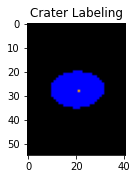

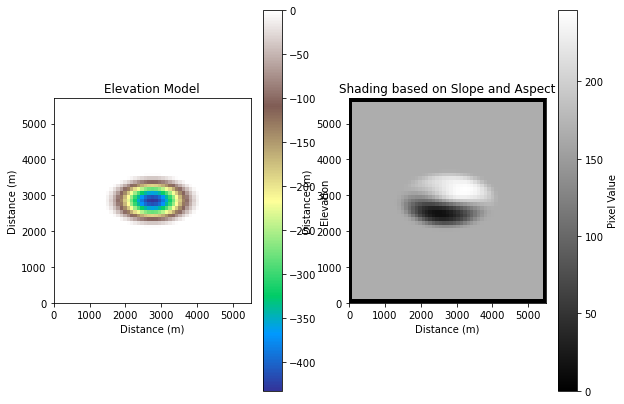

Image saved to TestHoles/hole_mx55_my57_slope13_el41_az325_xrad739_yrad1449.pgm
Label image saved to TestHoles/hole_mx55_my57_slope13_el41_az325_xrad739_yrad1449LABEL.pgm


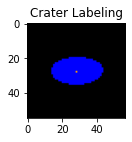

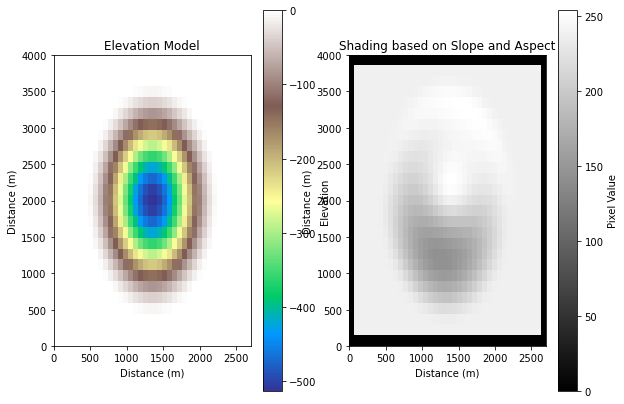

Image saved to TestHoles/hole_mx27_my40_slope11_el70_az343_xrad1089_yrad1345.pgm
Label image saved to TestHoles/hole_mx27_my40_slope11_el70_az343_xrad1089_yrad1345LABEL.pgm


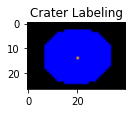

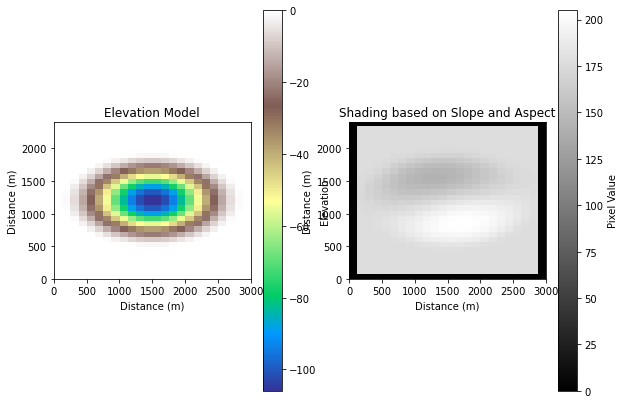

Image saved to TestHoles/hole_mx30_my24_slope43_el44_az201_xrad923_yrad1116.pgm
Label image saved to TestHoles/hole_mx30_my24_slope43_el44_az201_xrad923_yrad1116LABEL.pgm


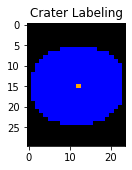

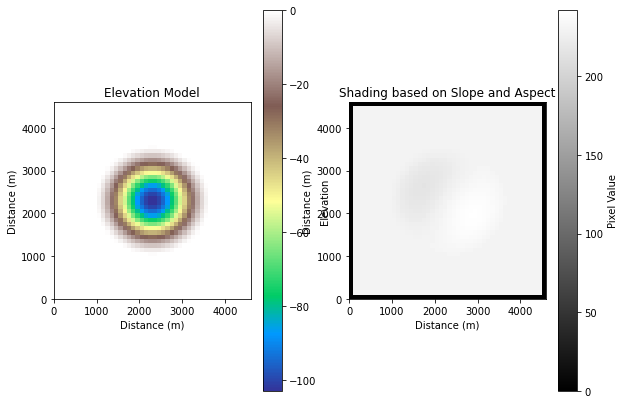

Image saved to TestHoles/hole_mx46_my46_slope44_el65_az241_xrad1307_yrad1375.pgm
Label image saved to TestHoles/hole_mx46_my46_slope44_el65_az241_xrad1307_yrad1375LABEL.pgm


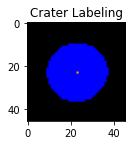

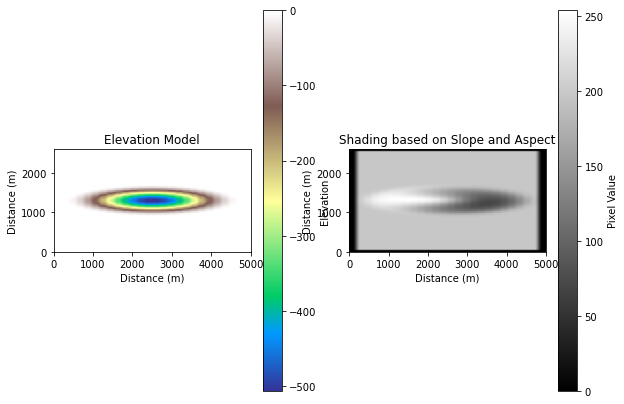

Image saved to TestHoles/hole_mx50_my26_slope11_el51_az80_xrad752_yrad1144.pgm
Label image saved to TestHoles/hole_mx50_my26_slope11_el51_az80_xrad752_yrad1144LABEL.pgm


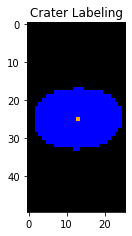

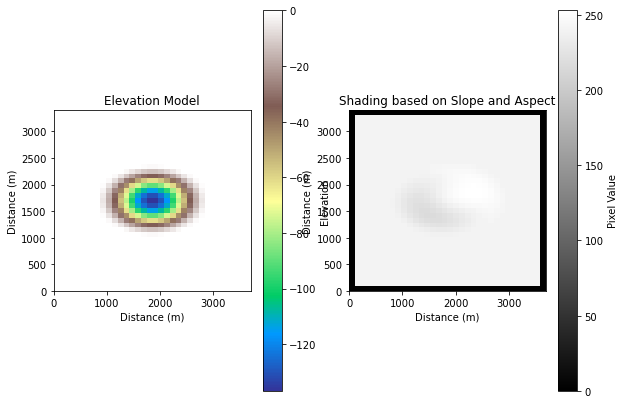

Image saved to TestHoles/hole_mx37_my34_slope36_el72_az302_xrad750_yrad975.pgm
Label image saved to TestHoles/hole_mx37_my34_slope36_el72_az302_xrad750_yrad975LABEL.pgm


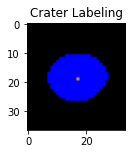

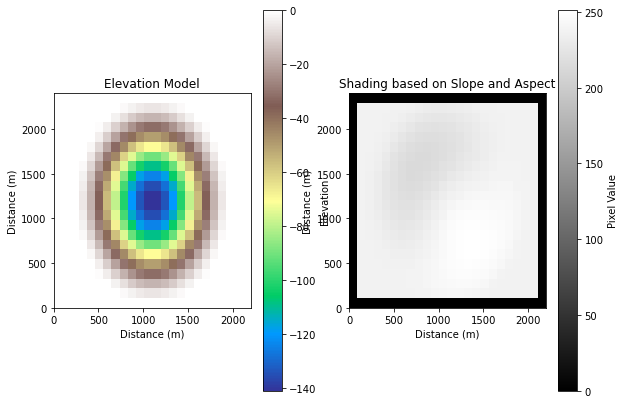

Image saved to TestHoles/hole_mx22_my24_slope35_el69_az219_xrad1093_yrad969.pgm
Label image saved to TestHoles/hole_mx22_my24_slope35_el69_az219_xrad1093_yrad969LABEL.pgm


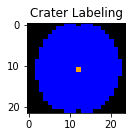

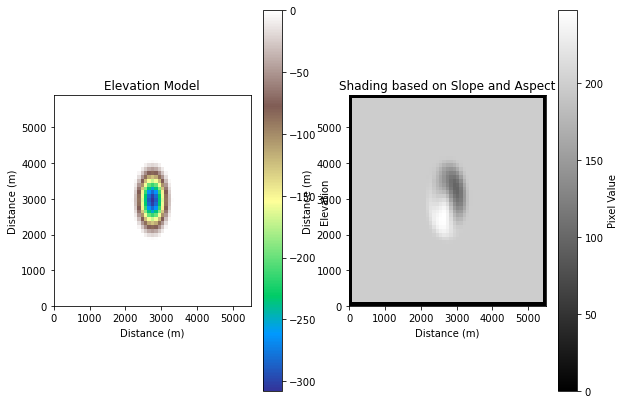

Image saved to TestHoles/hole_mx55_my59_slope18_el51_az150_xrad1073_yrad625.pgm
Label image saved to TestHoles/hole_mx55_my59_slope18_el51_az150_xrad1073_yrad625LABEL.pgm


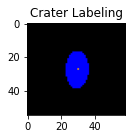

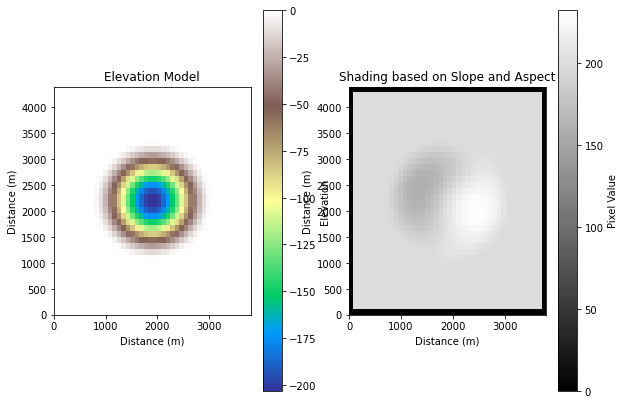

Image saved to TestHoles/hole_mx38_my44_slope26_el52_az253_xrad1002_yrad1349.pgm
Label image saved to TestHoles/hole_mx38_my44_slope26_el52_az253_xrad1002_yrad1349LABEL.pgm


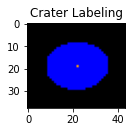

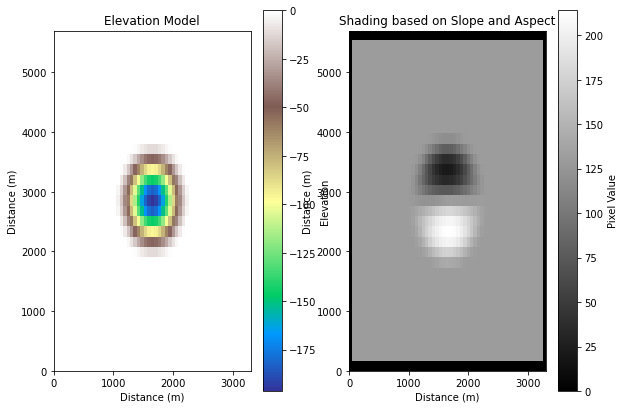

Image saved to TestHoles/hole_mx33_my57_slope27_el31_az184_xrad592_yrad1112.pgm
Label image saved to TestHoles/hole_mx33_my57_slope27_el31_az184_xrad592_yrad1112LABEL.pgm


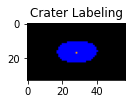

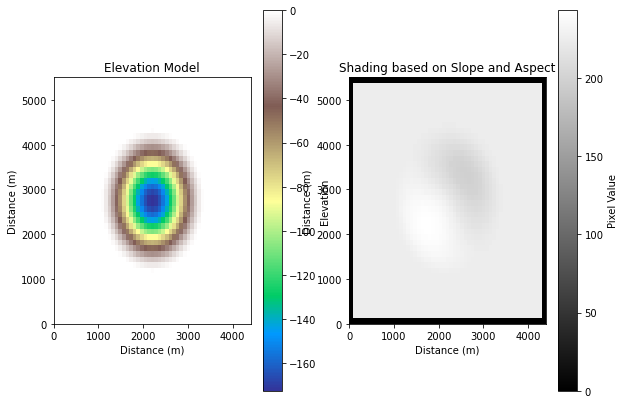

Image saved to TestHoles/hole_mx44_my55_slope30_el62_az130_xrad1303_yrad1478.pgm
Label image saved to TestHoles/hole_mx44_my55_slope30_el62_az130_xrad1303_yrad1478LABEL.pgm


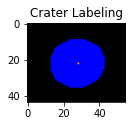

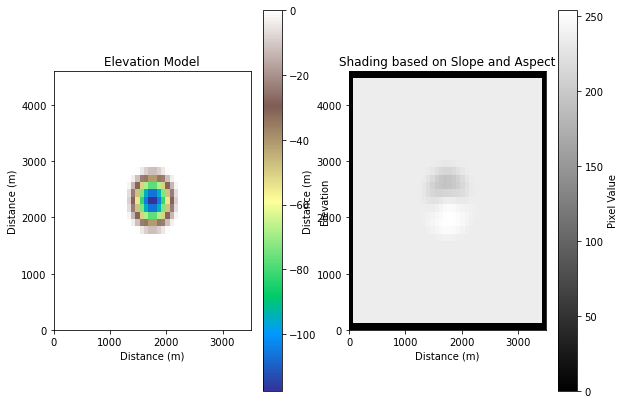

Image saved to TestHoles/hole_mx35_my46_slope40_el68_az188_xrad503_yrad664.pgm
Label image saved to TestHoles/hole_mx35_my46_slope40_el68_az188_xrad503_yrad664LABEL.pgm


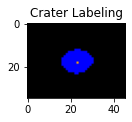

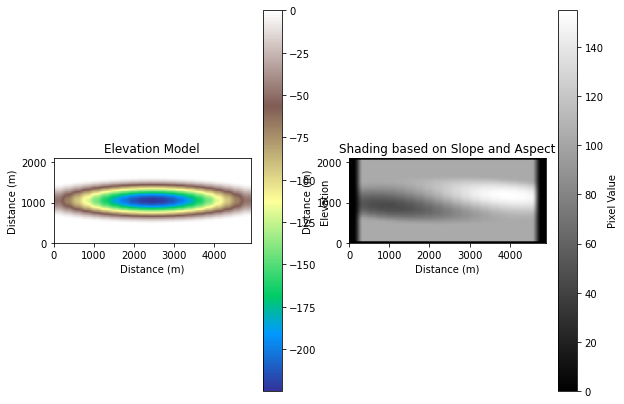

Image saved to TestHoles/hole_mx49_my21_slope24_el24_az295_xrad1369_yrad1443.pgm
Label image saved to TestHoles/hole_mx49_my21_slope24_el24_az295_xrad1369_yrad1443LABEL.pgm


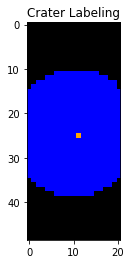

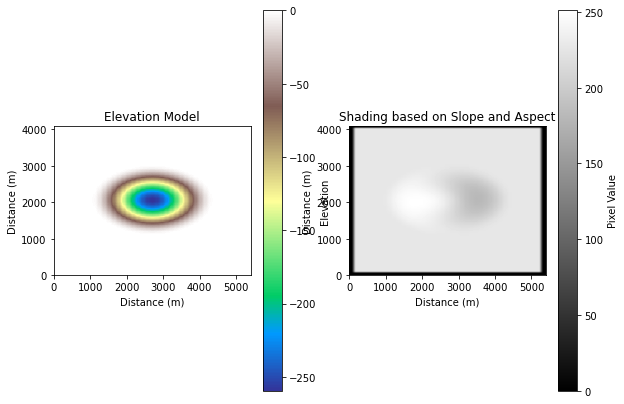

Image saved to TestHoles/hole_mx54_my41_slope21_el63_az96_xrad1258_yrad1274.pgm
Label image saved to TestHoles/hole_mx54_my41_slope21_el63_az96_xrad1258_yrad1274LABEL.pgm


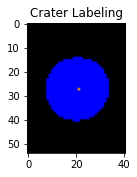

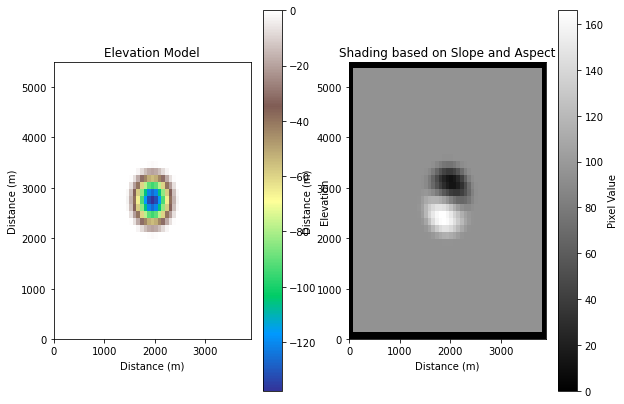

Image saved to TestHoles/hole_mx39_my55_slope36_el22_az155_xrad531_yrad775.pgm
Label image saved to TestHoles/hole_mx39_my55_slope36_el22_az155_xrad531_yrad775LABEL.pgm


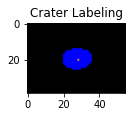

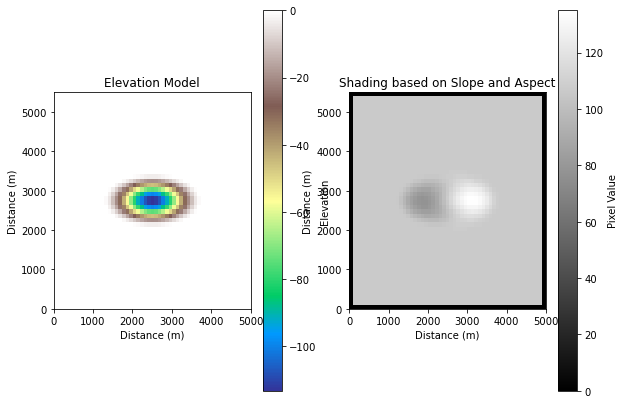

Image saved to TestHoles/hole_mx50_my55_slope41_el25_az272_xrad618_yrad1384.pgm
Label image saved to TestHoles/hole_mx50_my55_slope41_el25_az272_xrad618_yrad1384LABEL.pgm


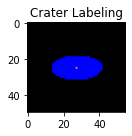

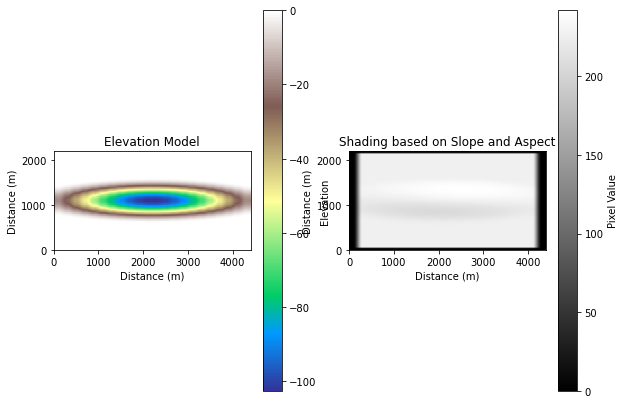

Image saved to TestHoles/hole_mx44_my22_slope44_el63_az342_xrad995_yrad1451.pgm
Label image saved to TestHoles/hole_mx44_my22_slope44_el63_az342_xrad995_yrad1451LABEL.pgm


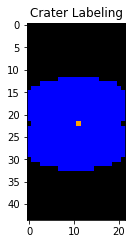

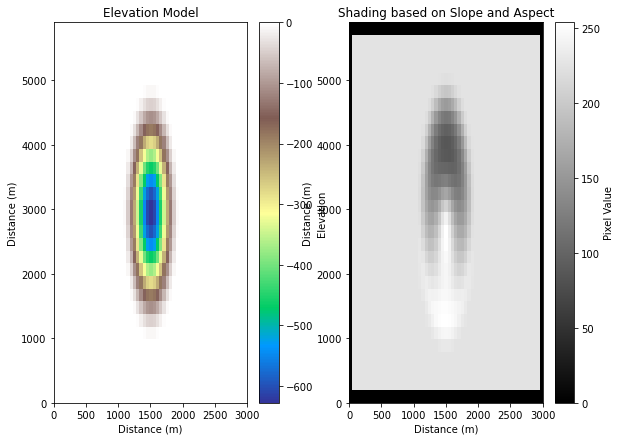

Image saved to TestHoles/hole_mx30_my59_slope9_el63_az177_xrad1029_yrad856.pgm
Label image saved to TestHoles/hole_mx30_my59_slope9_el63_az177_xrad1029_yrad856LABEL.pgm


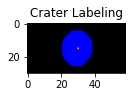

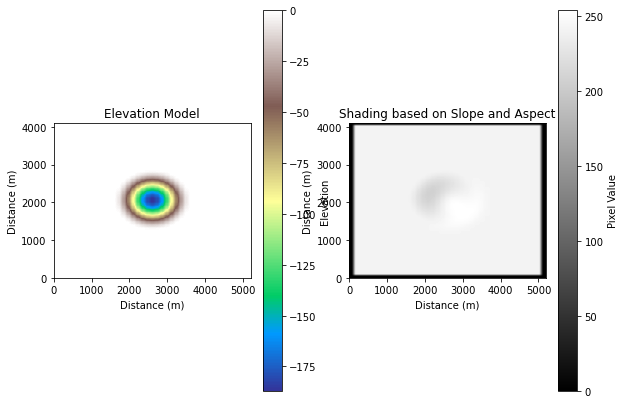

Image saved to TestHoles/hole_mx52_my41_slope28_el73_az230_xrad1014_yrad800.pgm
Label image saved to TestHoles/hole_mx52_my41_slope28_el73_az230_xrad1014_yrad800LABEL.pgm


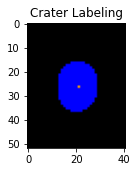

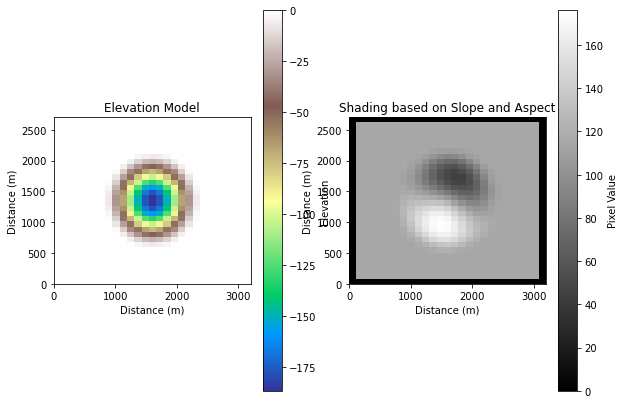

Image saved to TestHoles/hole_mx32_my27_slope28_el27_az166_xrad963_yrad679.pgm
Label image saved to TestHoles/hole_mx32_my27_slope28_el27_az166_xrad963_yrad679LABEL.pgm


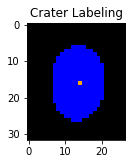

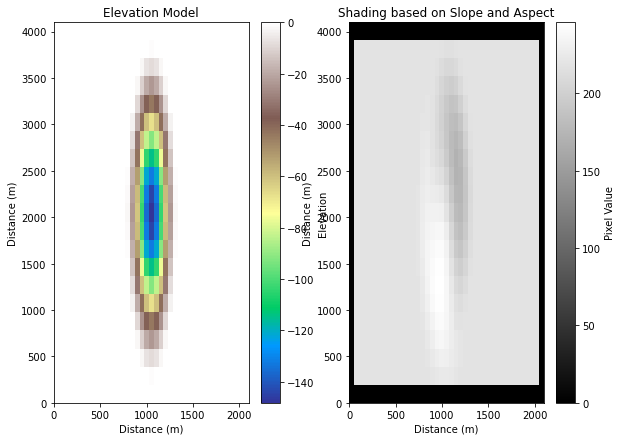

Image saved to TestHoles/hole_mx21_my41_slope34_el60_az145_xrad946_yrad540.pgm
Label image saved to TestHoles/hole_mx21_my41_slope34_el60_az145_xrad946_yrad540LABEL.pgm


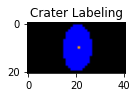

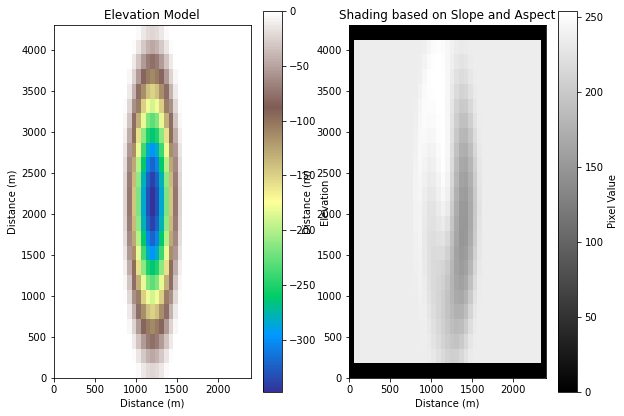

Image saved to TestHoles/hole_mx24_my43_slope16_el68_az42_xrad1378_yrad718.pgm
Label image saved to TestHoles/hole_mx24_my43_slope16_el68_az42_xrad1378_yrad718LABEL.pgm


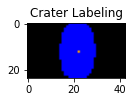

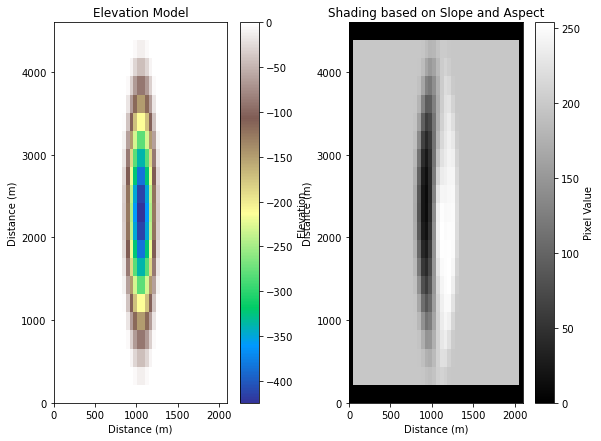

Image saved to TestHoles/hole_mx21_my46_slope13_el51_az257_xrad1008_yrad549.pgm
Label image saved to TestHoles/hole_mx21_my46_slope13_el51_az257_xrad1008_yrad549LABEL.pgm


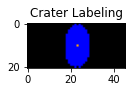

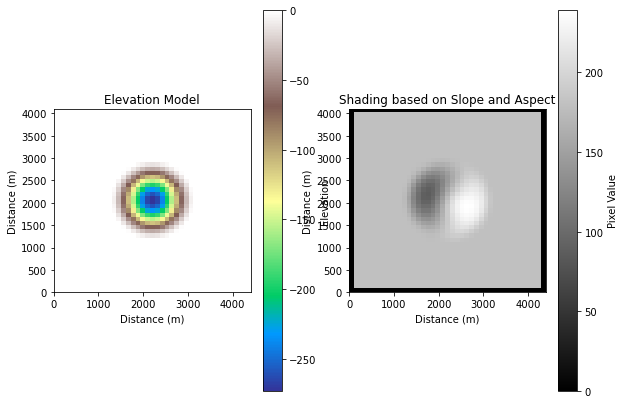

Image saved to TestHoles/hole_mx44_my41_slope20_el45_az251_xrad981_yrad889.pgm
Label image saved to TestHoles/hole_mx44_my41_slope20_el45_az251_xrad981_yrad889LABEL.pgm


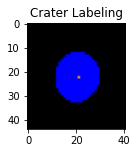

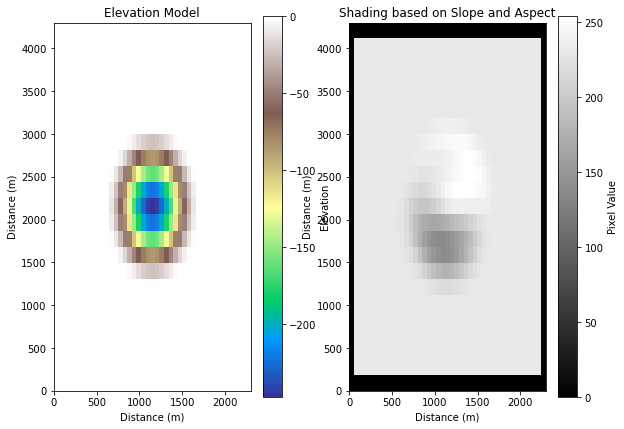

Image saved to TestHoles/hole_mx23_my43_slope22_el65_az325_xrad500_yrad1034.pgm
Label image saved to TestHoles/hole_mx23_my43_slope22_el65_az325_xrad500_yrad1034LABEL.pgm


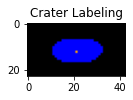

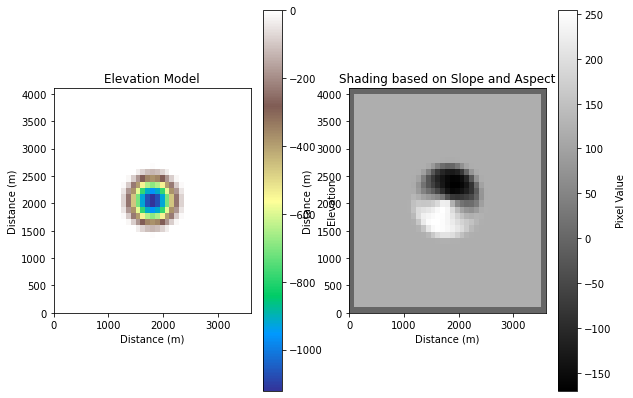

Image saved to TestHoles/hole_mx36_my41_slope5_el28_az158_xrad573_yrad723.pgm
Label image saved to TestHoles/hole_mx36_my41_slope5_el28_az158_xrad573_yrad723LABEL.pgm


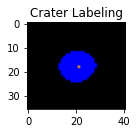

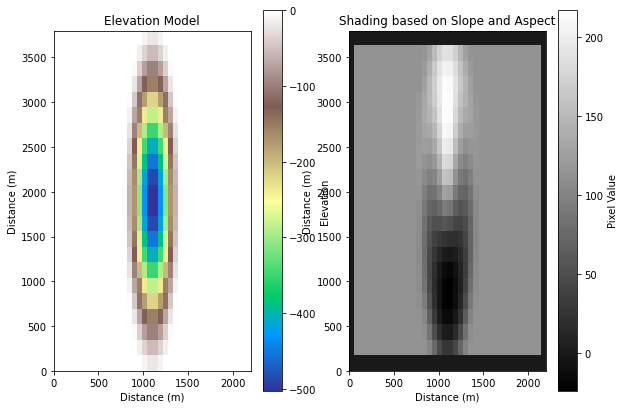

Image saved to TestHoles/hole_mx22_my38_slope11_el27_az2_xrad1201_yrad577.pgm
Label image saved to TestHoles/hole_mx22_my38_slope11_el27_az2_xrad1201_yrad577LABEL.pgm


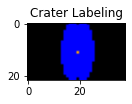

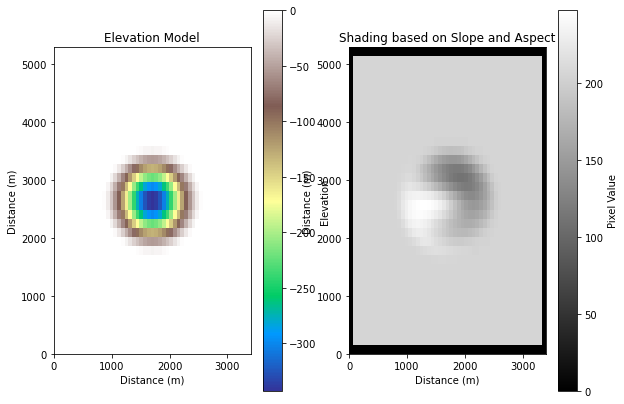

Image saved to TestHoles/hole_mx34_my53_slope16_el54_az110_xrad605_yrad1362.pgm
Label image saved to TestHoles/hole_mx34_my53_slope16_el54_az110_xrad605_yrad1362LABEL.pgm


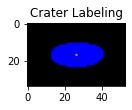

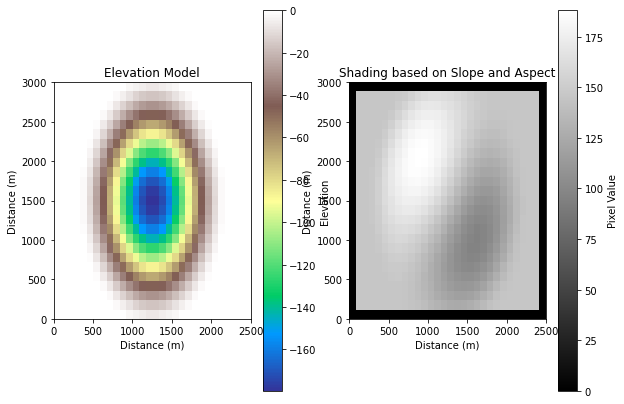

Image saved to TestHoles/hole_mx25_my30_slope29_el35_az44_xrad1368_yrad1127.pgm
Label image saved to TestHoles/hole_mx25_my30_slope29_el35_az44_xrad1368_yrad1127LABEL.pgm


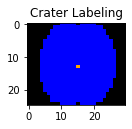

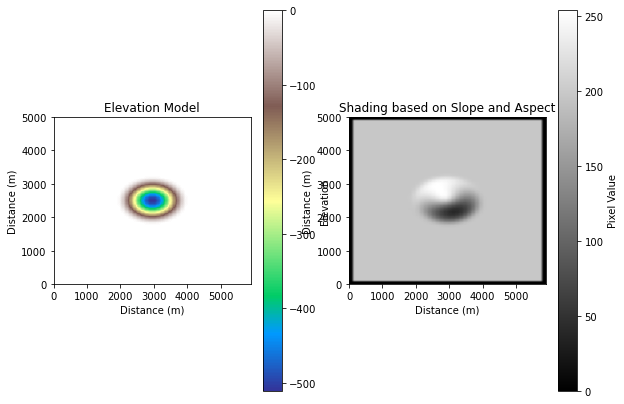

Image saved to TestHoles/hole_mx59_my50_slope11_el51_az24_xrad865_yrad911.pgm
Label image saved to TestHoles/hole_mx59_my50_slope11_el51_az24_xrad865_yrad911LABEL.pgm


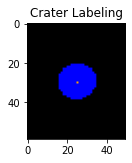

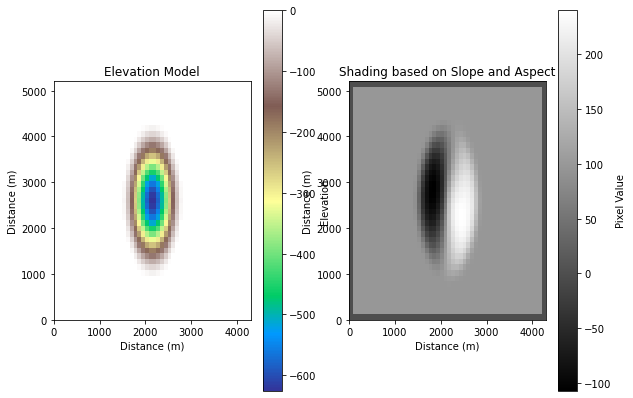

Image saved to TestHoles/hole_mx43_my52_slope9_el23_az250_xrad1436_yrad815.pgm
Label image saved to TestHoles/hole_mx43_my52_slope9_el23_az250_xrad1436_yrad815LABEL.pgm


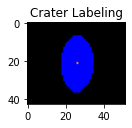

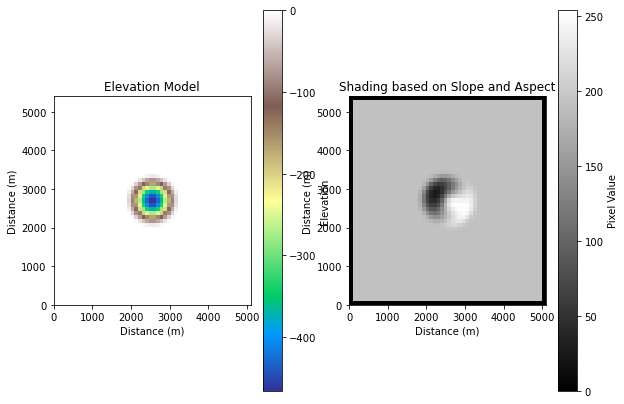

Image saved to TestHoles/hole_mx51_my54_slope12_el49_az244_xrad679_yrad772.pgm
Label image saved to TestHoles/hole_mx51_my54_slope12_el49_az244_xrad679_yrad772LABEL.pgm


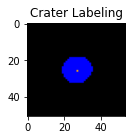

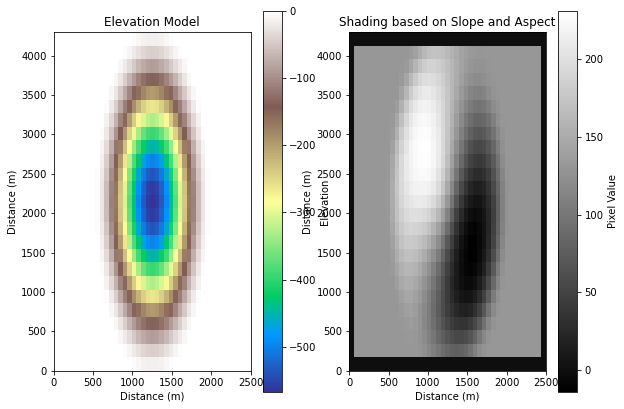

Image saved to TestHoles/hole_mx25_my43_slope10_el31_az56_xrad1338_yrad1266.pgm
Label image saved to TestHoles/hole_mx25_my43_slope10_el31_az56_xrad1338_yrad1266LABEL.pgm


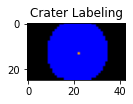

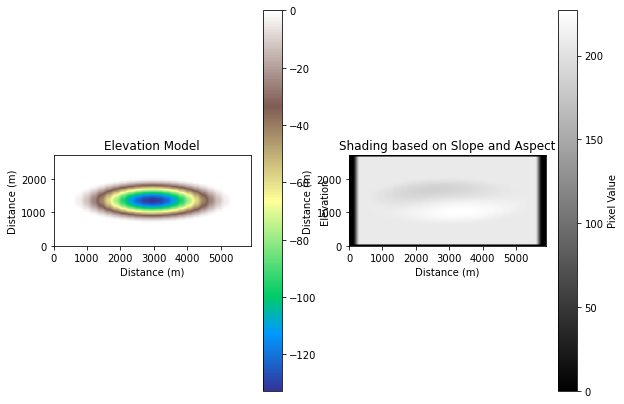

Image saved to TestHoles/hole_mx59_my27_slope37_el55_az195_xrad1482_yrad1123.pgm
Label image saved to TestHoles/hole_mx59_my27_slope37_el55_az195_xrad1482_yrad1123LABEL.pgm


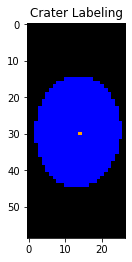

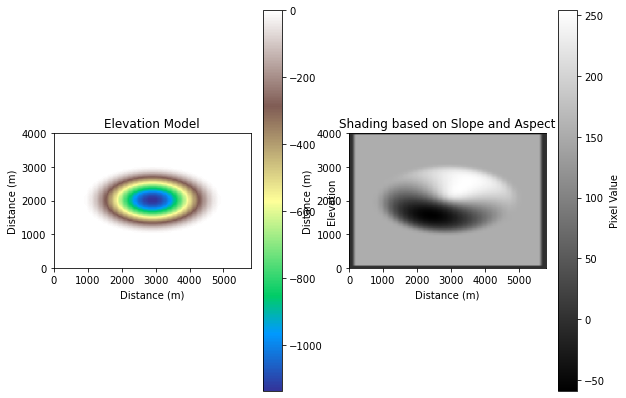

Image saved to TestHoles/hole_mx58_my40_slope5_el37_az332_xrad1470_yrad1426.pgm
Label image saved to TestHoles/hole_mx58_my40_slope5_el37_az332_xrad1470_yrad1426LABEL.pgm


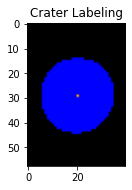

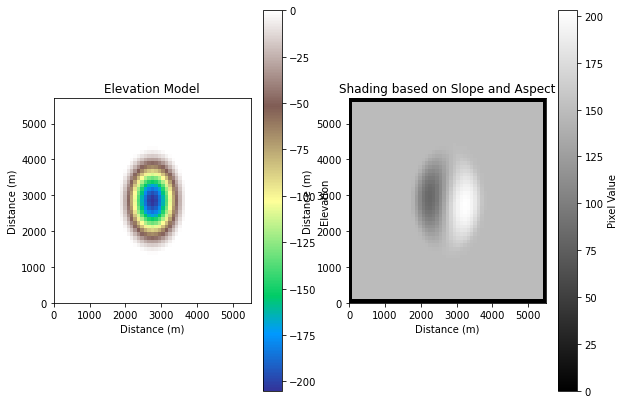

Image saved to TestHoles/hole_mx55_my57_slope26_el36_az258_xrad1470_yrad1029.pgm
Label image saved to TestHoles/hole_mx55_my57_slope26_el36_az258_xrad1470_yrad1029LABEL.pgm


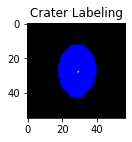

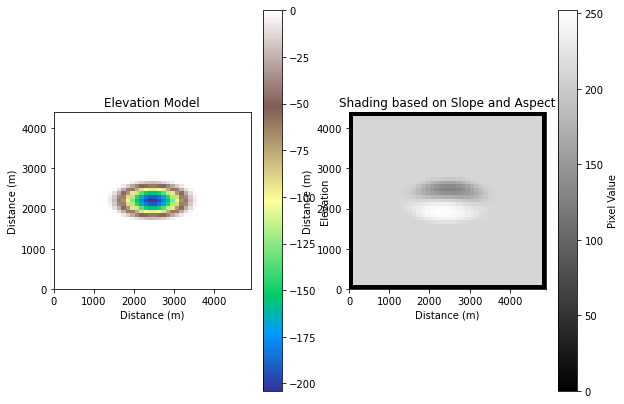

Image saved to TestHoles/hole_mx49_my44_slope26_el56_az167_xrad630_yrad1071.pgm
Label image saved to TestHoles/hole_mx49_my44_slope26_el56_az167_xrad630_yrad1071LABEL.pgm


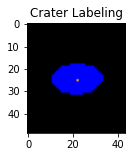

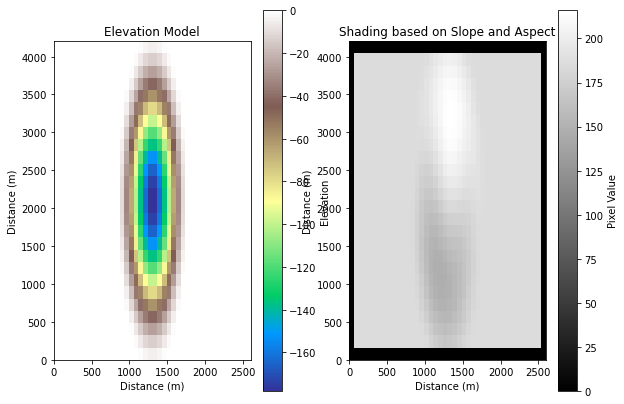

Image saved to TestHoles/hole_mx26_my42_slope29_el47_az351_xrad1400_yrad766.pgm
Label image saved to TestHoles/hole_mx26_my42_slope29_el47_az351_xrad1400_yrad766LABEL.pgm


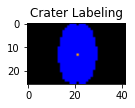

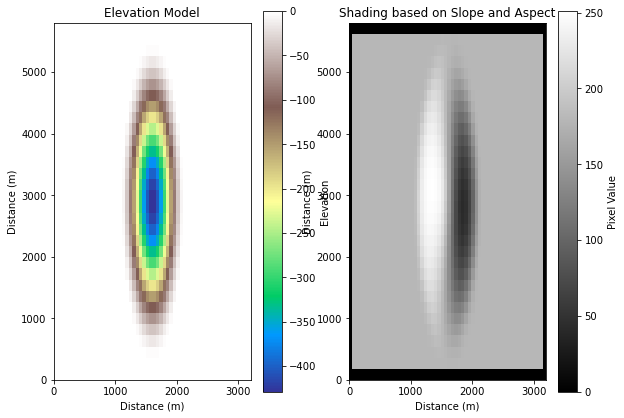

Image saved to TestHoles/hole_mx32_my58_slope13_el45_az82_xrad1431_yrad928.pgm
Label image saved to TestHoles/hole_mx32_my58_slope13_el45_az82_xrad1431_yrad928LABEL.pgm


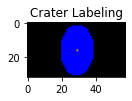

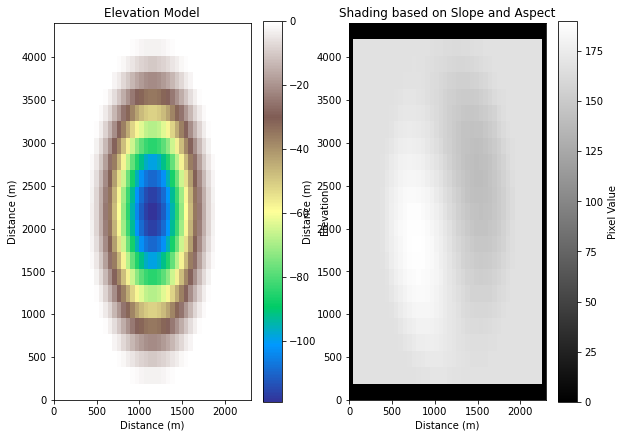

Image saved to TestHoles/hole_mx23_my44_slope40_el41_az107_xrad1105_yrad1498.pgm
Label image saved to TestHoles/hole_mx23_my44_slope40_el41_az107_xrad1105_yrad1498LABEL.pgm


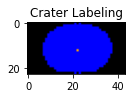

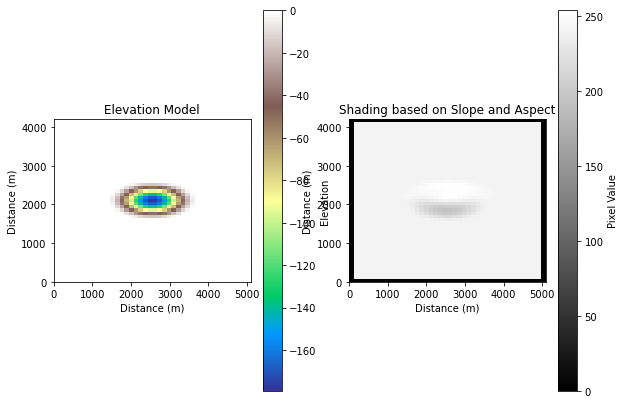

Image saved to TestHoles/hole_mx51_my42_slope29_el73_az354_xrad623_yrad960.pgm
Label image saved to TestHoles/hole_mx51_my42_slope29_el73_az354_xrad623_yrad960LABEL.pgm


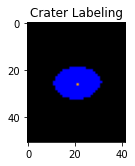

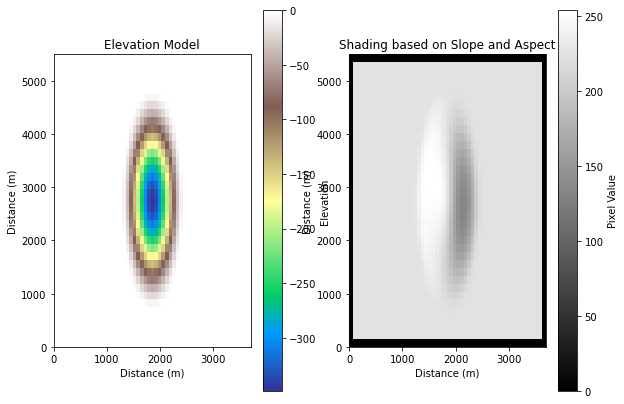

Image saved to TestHoles/hole_mx37_my55_slope16_el62_az76_xrad1424_yrad883.pgm
Label image saved to TestHoles/hole_mx37_my55_slope16_el62_az76_xrad1424_yrad883LABEL.pgm


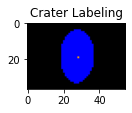

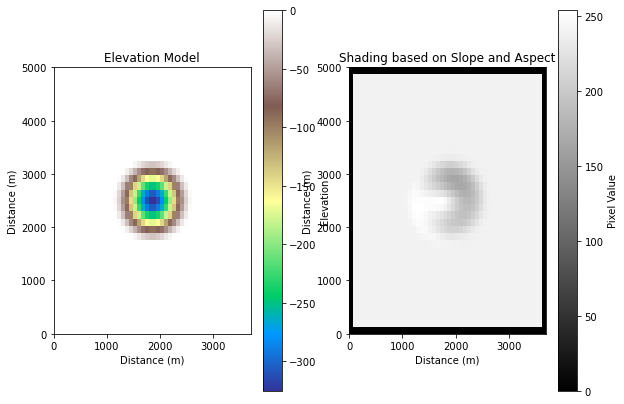

Image saved to TestHoles/hole_mx37_my50_slope17_el71_az110_xrad621_yrad1029.pgm
Label image saved to TestHoles/hole_mx37_my50_slope17_el71_az110_xrad621_yrad1029LABEL.pgm


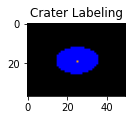

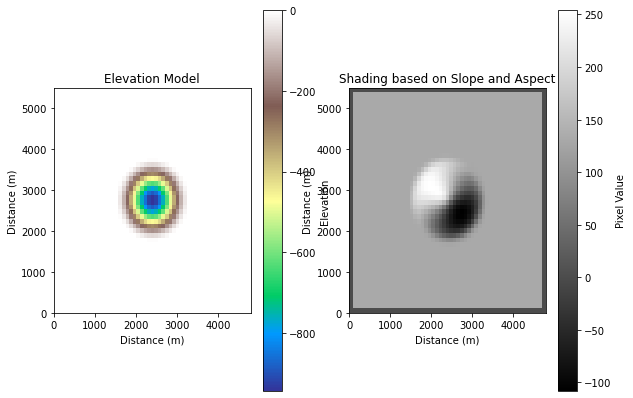

Image saved to TestHoles/hole_mx48_my55_slope6_el31_az50_xrad891_yrad1031.pgm
Label image saved to TestHoles/hole_mx48_my55_slope6_el31_az50_xrad891_yrad1031LABEL.pgm


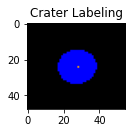

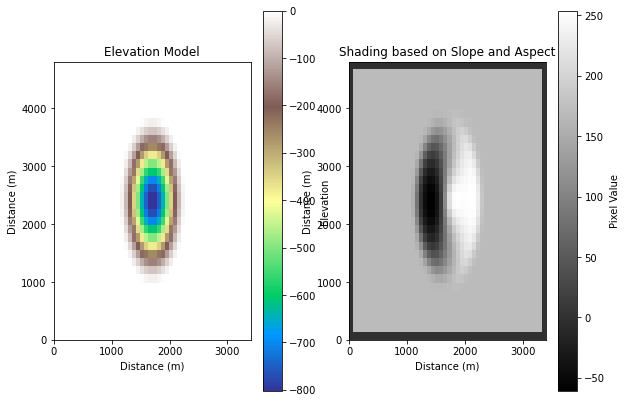

Image saved to TestHoles/hole_mx34_my48_slope7_el42_az272_xrad1057_yrad826.pgm
Label image saved to TestHoles/hole_mx34_my48_slope7_el42_az272_xrad1057_yrad826LABEL.pgm


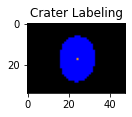

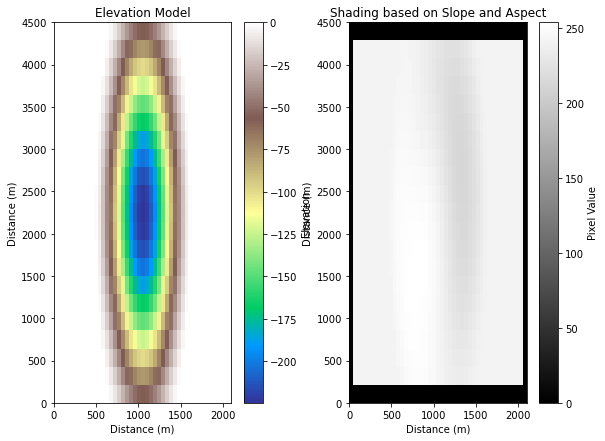

Image saved to TestHoles/hole_mx21_my45_slope24_el72_az118_xrad1498_yrad1253.pgm
Label image saved to TestHoles/hole_mx21_my45_slope24_el72_az118_xrad1498_yrad1253LABEL.pgm


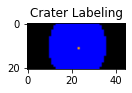

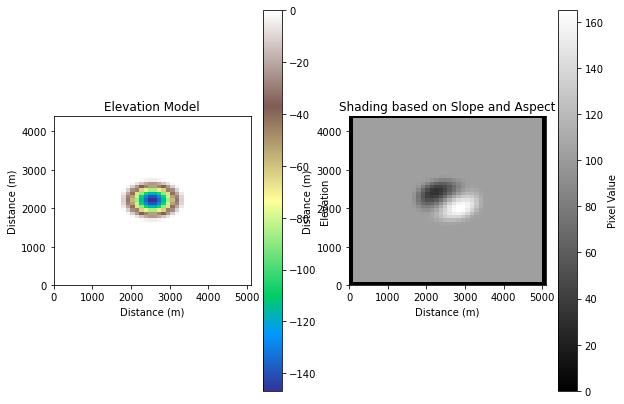

Image saved to TestHoles/hole_mx51_my44_slope34_el24_az230_xrad676_yrad787.pgm
Label image saved to TestHoles/hole_mx51_my44_slope34_el24_az230_xrad676_yrad787LABEL.pgm


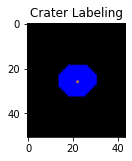

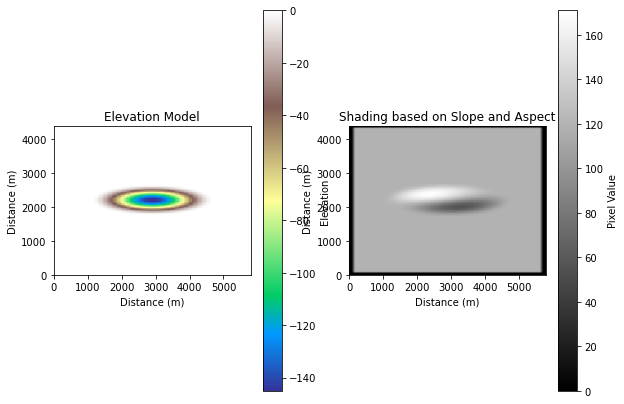

Image saved to TestHoles/hole_mx58_my44_slope34_el28_az51_xrad576_yrad1375.pgm
Label image saved to TestHoles/hole_mx58_my44_slope34_el28_az51_xrad576_yrad1375LABEL.pgm


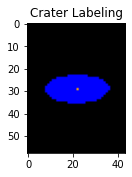

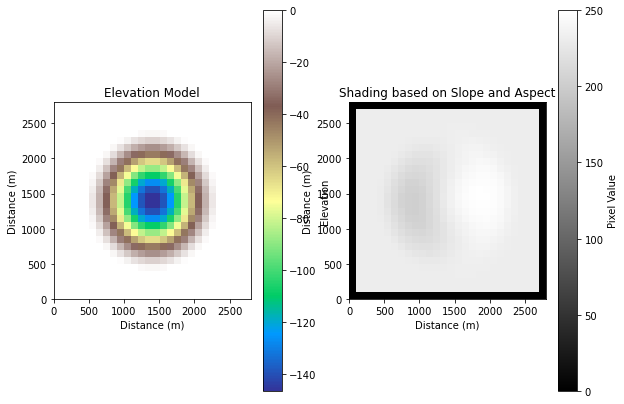

Image saved to TestHoles/hole_mx28_my28_slope34_el66_az276_xrad1027_yrad967.pgm
Label image saved to TestHoles/hole_mx28_my28_slope34_el66_az276_xrad1027_yrad967LABEL.pgm


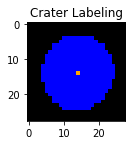

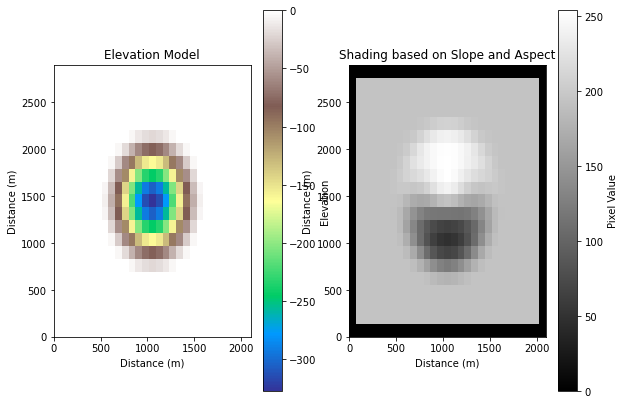

Image saved to TestHoles/hole_mx21_my29_slope17_el50_az1_xrad595_yrad777.pgm
Label image saved to TestHoles/hole_mx21_my29_slope17_el50_az1_xrad595_yrad777LABEL.pgm


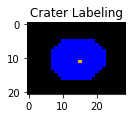

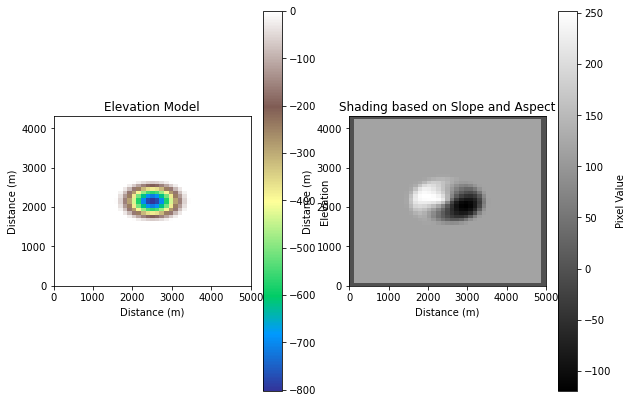

Image saved to TestHoles/hole_mx50_my43_slope7_el28_az67_xrad671_yrad846.pgm
Label image saved to TestHoles/hole_mx50_my43_slope7_el28_az67_xrad671_yrad846LABEL.pgm


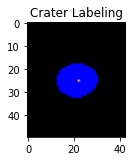

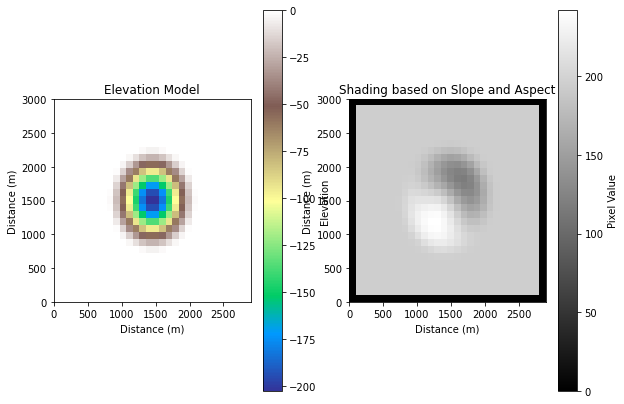

Image saved to TestHoles/hole_mx29_my30_slope26_el50_az145_xrad772_yrad693.pgm
Label image saved to TestHoles/hole_mx29_my30_slope26_el50_az145_xrad772_yrad693LABEL.pgm


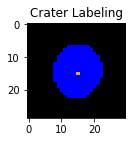

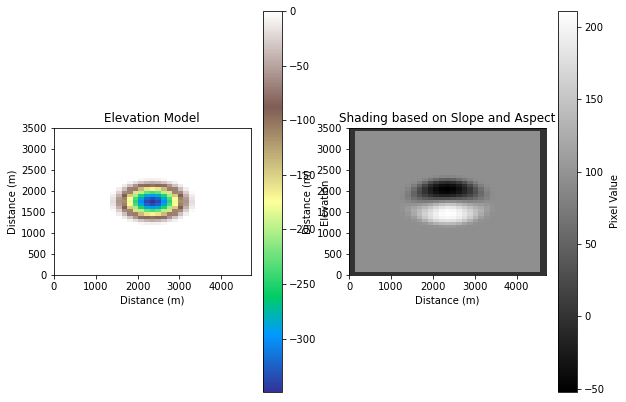

Image saved to TestHoles/hole_mx47_my35_slope16_el22_az182_xrad781_yrad820.pgm
Label image saved to TestHoles/hole_mx47_my35_slope16_el22_az182_xrad781_yrad820LABEL.pgm


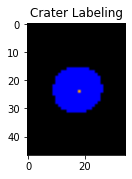

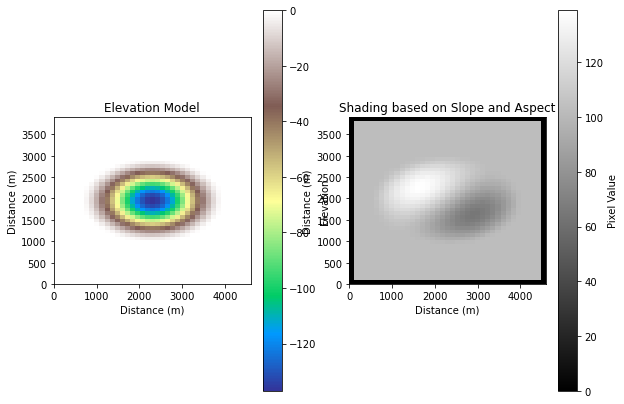

Image saved to TestHoles/hole_mx46_my39_slope36_el24_az55_xrad1182_yrad1426.pgm
Label image saved to TestHoles/hole_mx46_my39_slope36_el24_az55_xrad1182_yrad1426LABEL.pgm


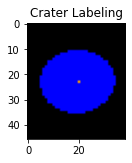

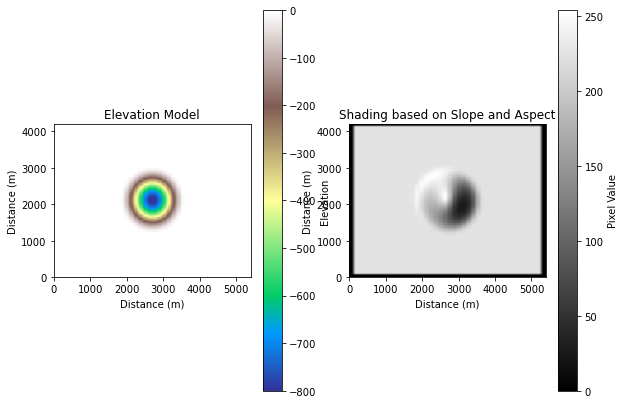

Image saved to TestHoles/hole_mx54_my42_slope7_el62_az48_xrad1183_yrad692.pgm
Label image saved to TestHoles/hole_mx54_my42_slope7_el62_az48_xrad1183_yrad692LABEL.pgm


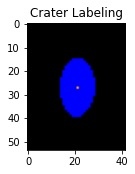

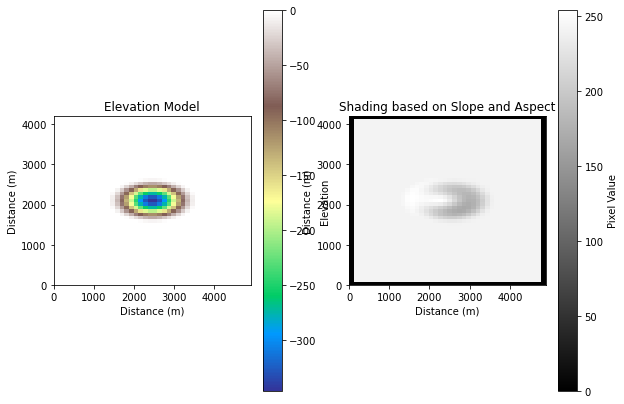

Image saved to TestHoles/hole_mx49_my42_slope16_el72_az78_xrad655_yrad956.pgm
Label image saved to TestHoles/hole_mx49_my42_slope16_el72_az78_xrad655_yrad956LABEL.pgm


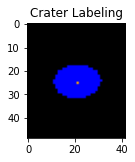

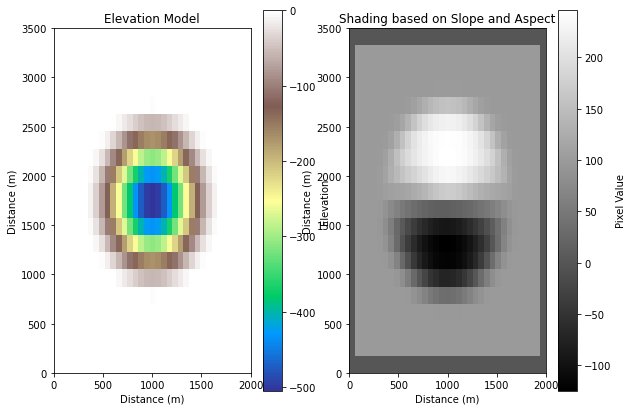

Image saved to TestHoles/hole_mx20_my35_slope11_el23_az358_xrad573_yrad1216.pgm
Label image saved to TestHoles/hole_mx20_my35_slope11_el23_az358_xrad573_yrad1216LABEL.pgm


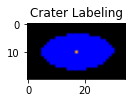

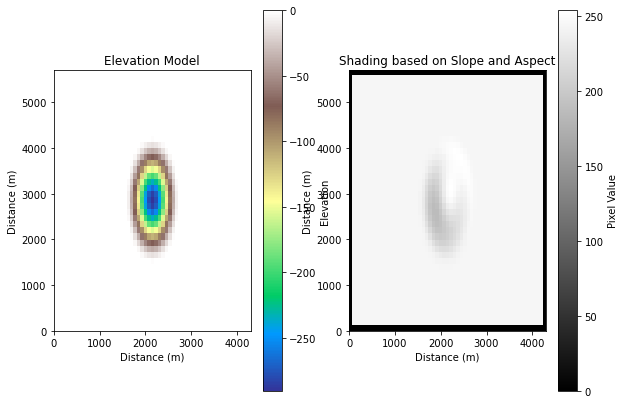

Image saved to TestHoles/hole_mx43_my57_slope19_el74_az318_xrad1046_yrad781.pgm
Label image saved to TestHoles/hole_mx43_my57_slope19_el74_az318_xrad1046_yrad781LABEL.pgm


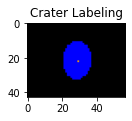

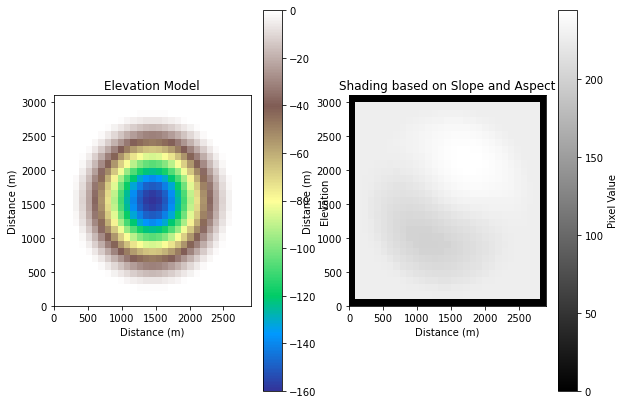

Image saved to TestHoles/hole_mx29_my31_slope32_el63_az330_xrad1267_yrad1323.pgm
Label image saved to TestHoles/hole_mx29_my31_slope32_el63_az330_xrad1267_yrad1323LABEL.pgm


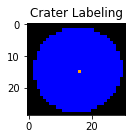

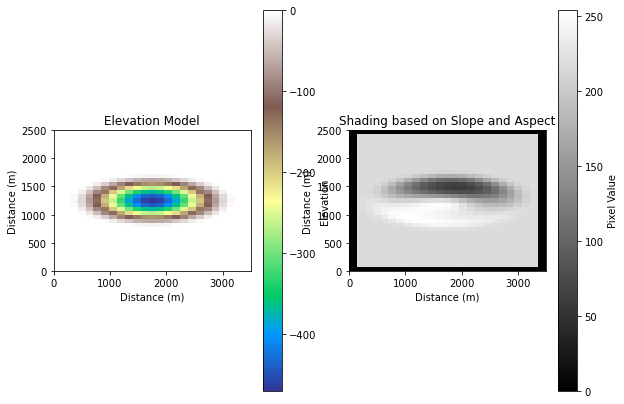

Image saved to TestHoles/hole_mx35_my25_slope12_el59_az159_xrad660_yrad1078.pgm
Label image saved to TestHoles/hole_mx35_my25_slope12_el59_az159_xrad660_yrad1078LABEL.pgm


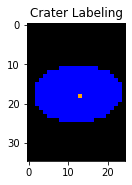

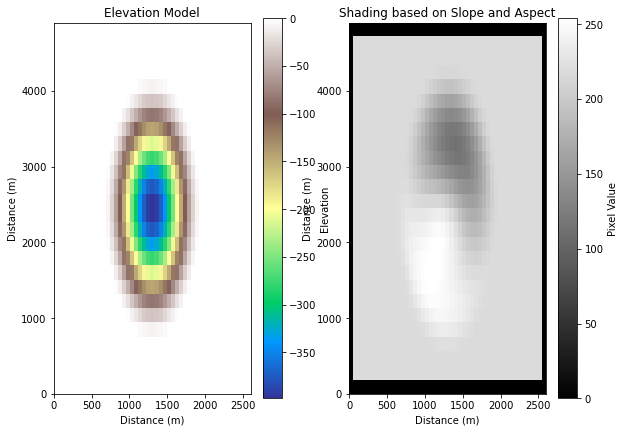

Image saved to TestHoles/hole_mx26_my49_slope14_el59_az152_xrad934_yrad1203.pgm
Label image saved to TestHoles/hole_mx26_my49_slope14_el59_az152_xrad934_yrad1203LABEL.pgm


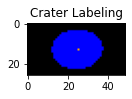

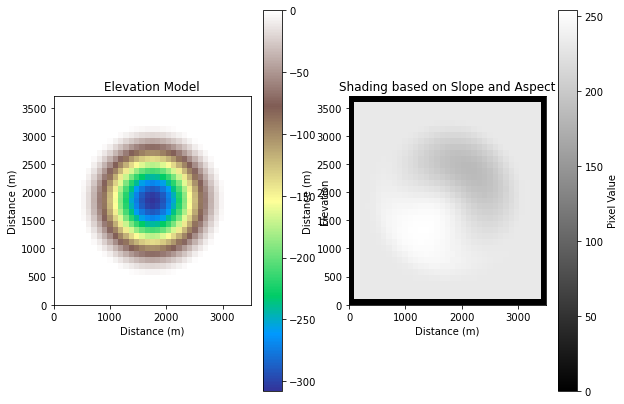

Image saved to TestHoles/hole_mx35_my37_slope18_el66_az140_xrad1313_yrad1421.pgm
Label image saved to TestHoles/hole_mx35_my37_slope18_el66_az140_xrad1313_yrad1421LABEL.pgm


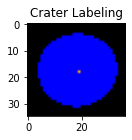

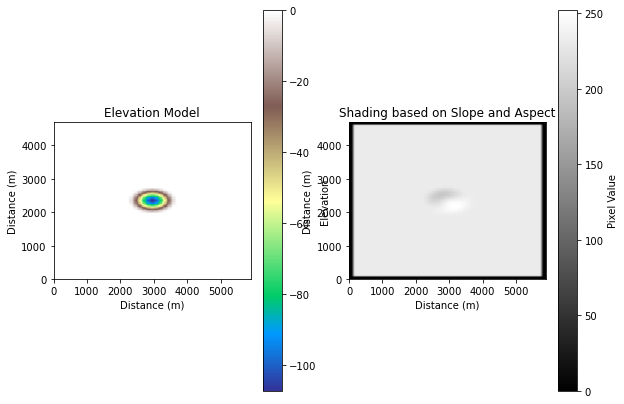

Image saved to TestHoles/hole_mx59_my47_slope43_el66_az219_xrad507_yrad584.pgm
Label image saved to TestHoles/hole_mx59_my47_slope43_el66_az219_xrad507_yrad584LABEL.pgm


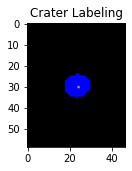

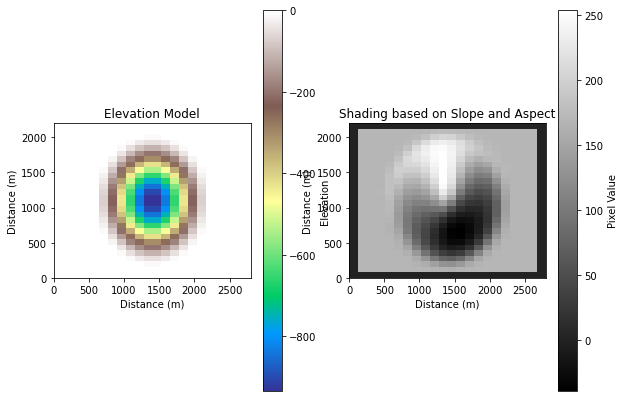

Image saved to TestHoles/hole_mx28_my22_slope6_el42_az15_xrad1227_yrad665.pgm
Label image saved to TestHoles/hole_mx28_my22_slope6_el42_az15_xrad1227_yrad665LABEL.pgm


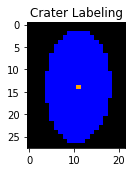

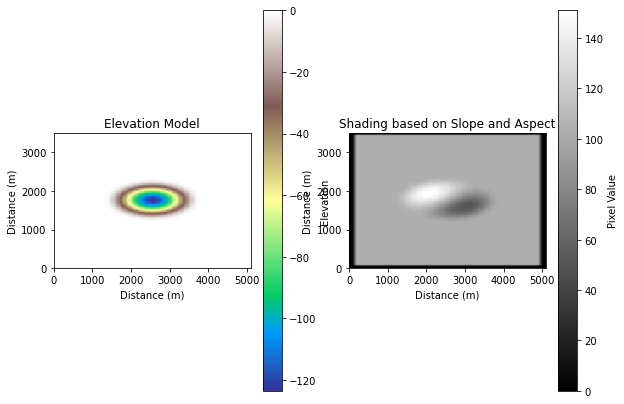

Image saved to TestHoles/hole_mx51_my35_slope39_el24_az52_xrad781_yrad858.pgm
Label image saved to TestHoles/hole_mx51_my35_slope39_el24_az52_xrad781_yrad858LABEL.pgm


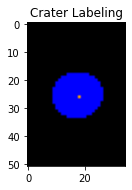

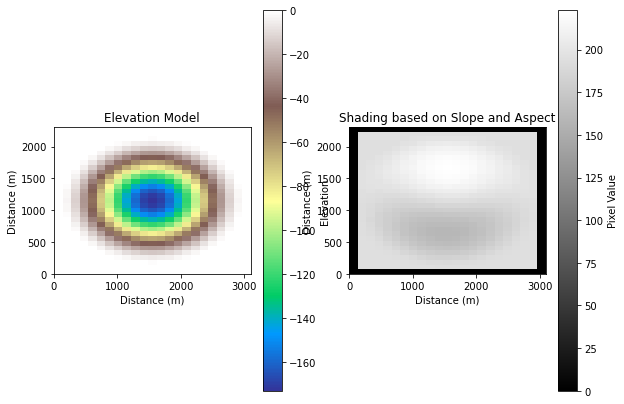

Image saved to TestHoles/hole_mx31_my23_slope30_el50_az358_xrad1360_yrad1089.pgm
Label image saved to TestHoles/hole_mx31_my23_slope30_el50_az358_xrad1360_yrad1089LABEL.pgm


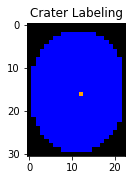

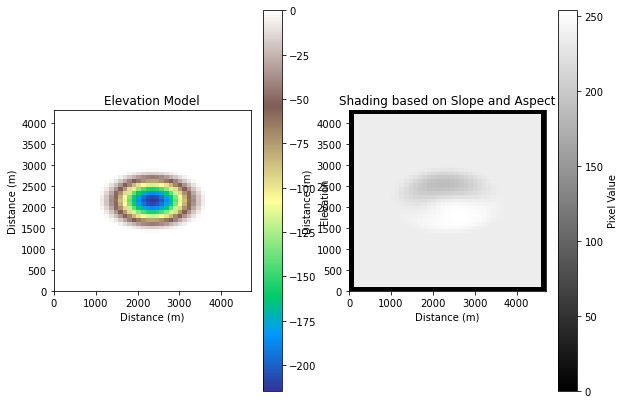

Image saved to TestHoles/hole_mx47_my43_slope25_el68_az199_xrad852_yrad1247.pgm
Label image saved to TestHoles/hole_mx47_my43_slope25_el68_az199_xrad852_yrad1247LABEL.pgm


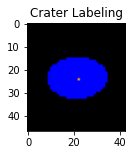

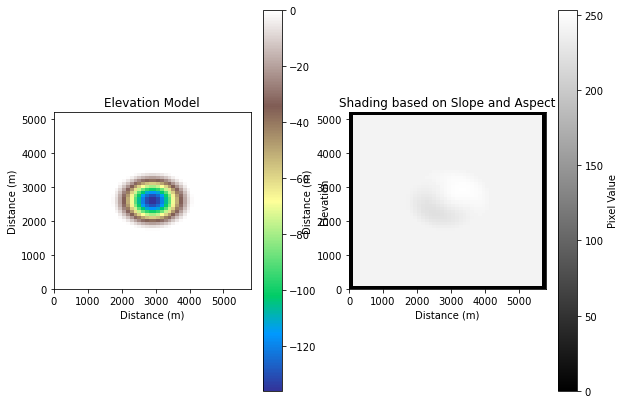

Image saved to TestHoles/hole_mx58_my52_slope36_el72_az314_xrad1002_yrad1119.pgm
Label image saved to TestHoles/hole_mx58_my52_slope36_el72_az314_xrad1002_yrad1119LABEL.pgm


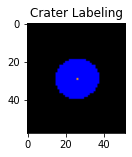

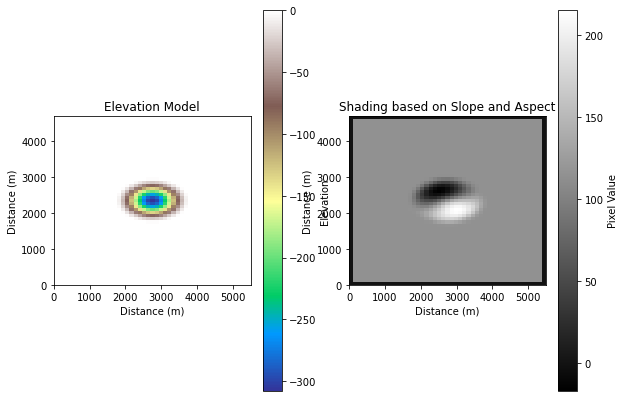

Image saved to TestHoles/hole_mx55_my47_slope18_el27_az210_xrad738_yrad892.pgm
Label image saved to TestHoles/hole_mx55_my47_slope18_el27_az210_xrad738_yrad892LABEL.pgm


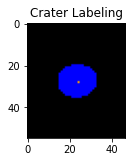

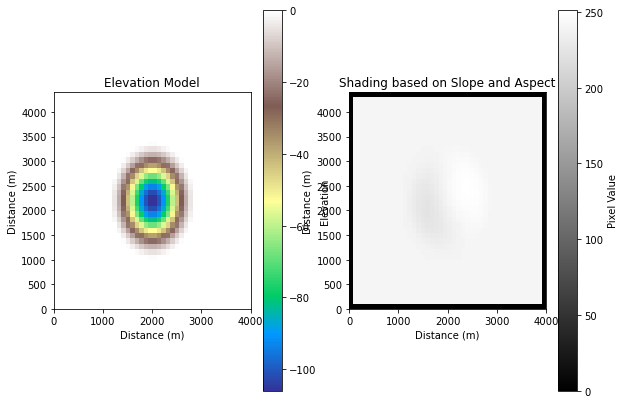

Image saved to TestHoles/hole_mx40_my44_slope43_el71_az294_xrad1097_yrad978.pgm
Label image saved to TestHoles/hole_mx40_my44_slope43_el71_az294_xrad1097_yrad978LABEL.pgm


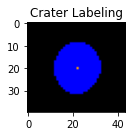

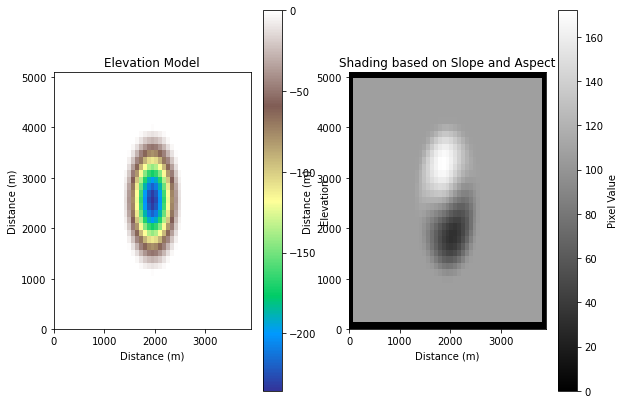

Image saved to TestHoles/hole_mx39_my51_slope23_el25_az13_xrad1154_yrad814.pgm
Label image saved to TestHoles/hole_mx39_my51_slope23_el25_az13_xrad1154_yrad814LABEL.pgm


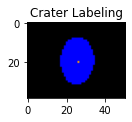

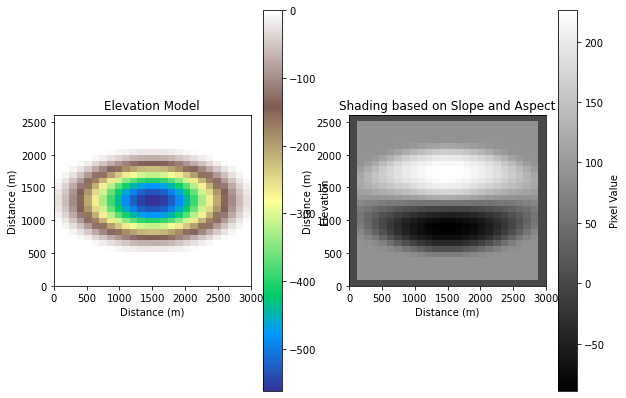

Image saved to TestHoles/hole_mx30_my26_slope10_el21_az1_xrad973_yrad1454.pgm
Label image saved to TestHoles/hole_mx30_my26_slope10_el21_az1_xrad973_yrad1454LABEL.pgm


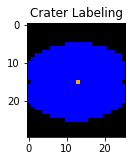

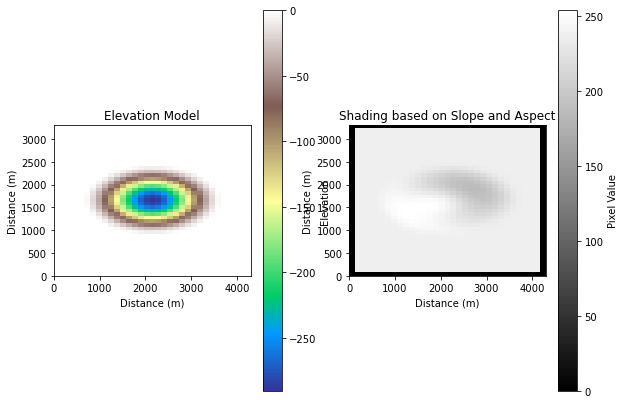

Image saved to TestHoles/hole_mx43_my33_slope19_el69_az123_xrad1013_yrad1186.pgm
Label image saved to TestHoles/hole_mx43_my33_slope19_el69_az123_xrad1013_yrad1186LABEL.pgm


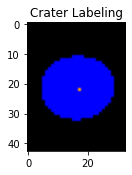

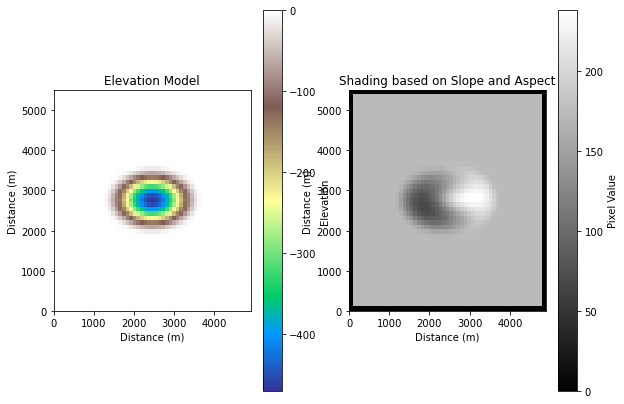

Image saved to TestHoles/hole_mx49_my55_slope12_el43_az278_xrad794_yrad1416.pgm
Label image saved to TestHoles/hole_mx49_my55_slope12_el43_az278_xrad794_yrad1416LABEL.pgm


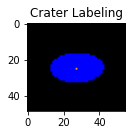

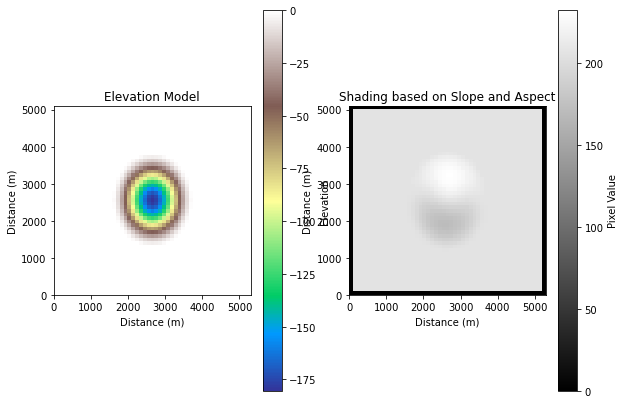

Image saved to TestHoles/hole_mx53_my51_slope29_el54_az355_xrad1349_yrad1062.pgm
Label image saved to TestHoles/hole_mx53_my51_slope29_el54_az355_xrad1349_yrad1062LABEL.pgm


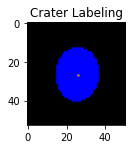

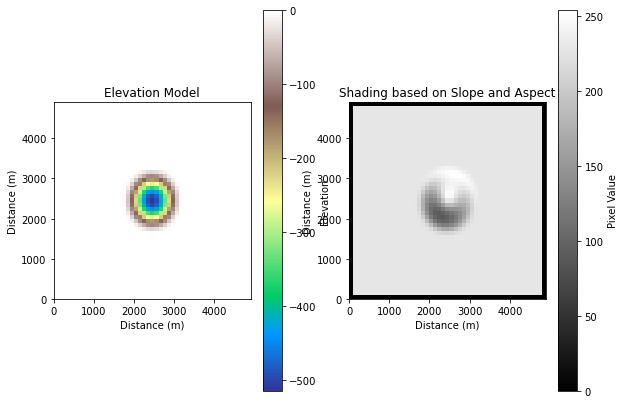

Image saved to TestHoles/hole_mx49_my49_slope11_el64_az339_xrad835_yrad742.pgm
Label image saved to TestHoles/hole_mx49_my49_slope11_el64_az339_xrad835_yrad742LABEL.pgm


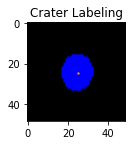

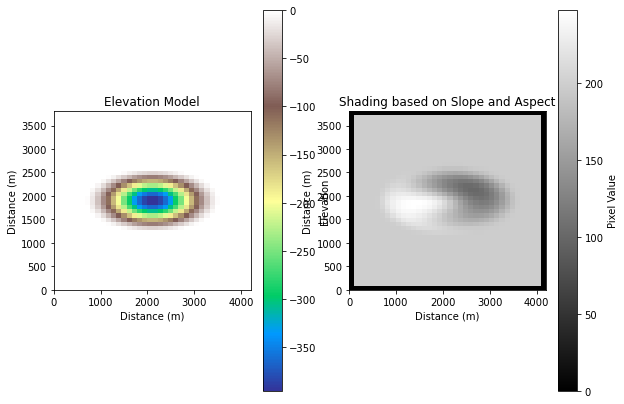

Image saved to TestHoles/hole_mx42_my38_slope14_el51_az108_xrad780_yrad1318.pgm
Label image saved to TestHoles/hole_mx42_my38_slope14_el51_az108_xrad780_yrad1318LABEL.pgm


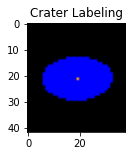

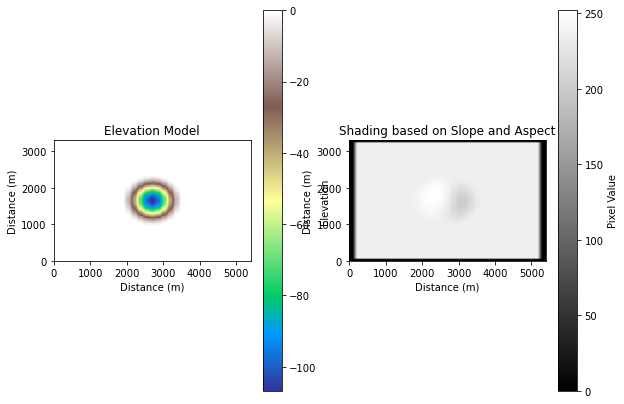

Image saved to TestHoles/hole_mx54_my33_slope43_el68_az64_xrad1163_yrad509.pgm
Label image saved to TestHoles/hole_mx54_my33_slope43_el68_az64_xrad1163_yrad509LABEL.pgm


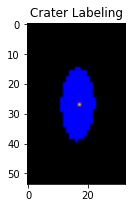

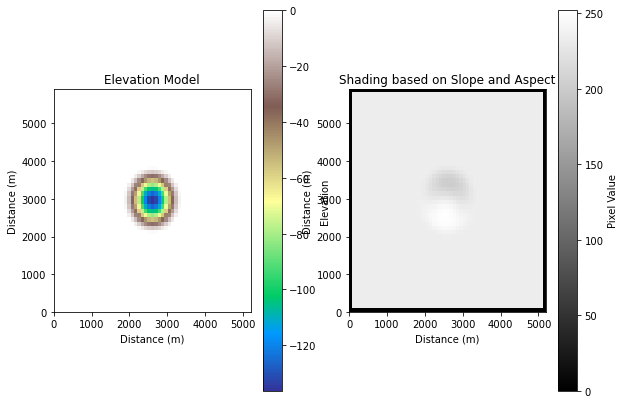

Image saved to TestHoles/hole_mx52_my59_slope36_el67_az169_xrad799_yrad887.pgm
Label image saved to TestHoles/hole_mx52_my59_slope36_el67_az169_xrad799_yrad887LABEL.pgm


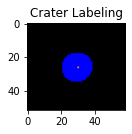

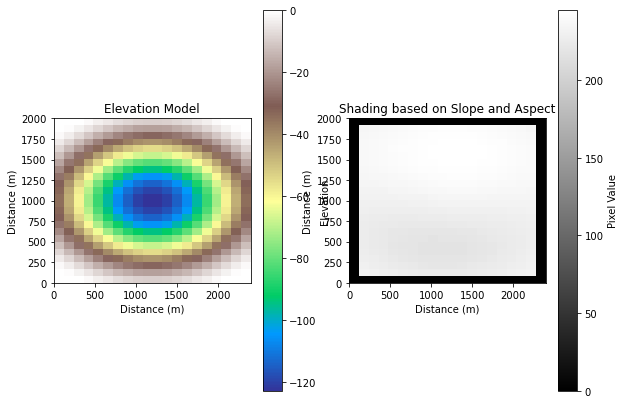

Image saved to TestHoles/hole_mx24_my20_slope39_el67_az353_xrad1402_yrad1469.pgm
Label image saved to TestHoles/hole_mx24_my20_slope39_el67_az353_xrad1402_yrad1469LABEL.pgm


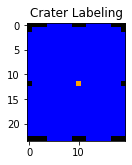

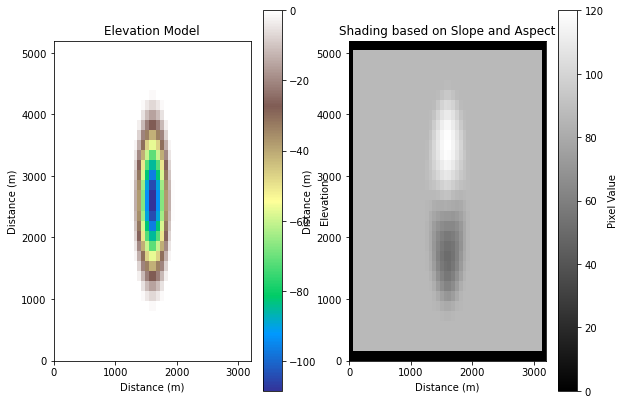

Image saved to TestHoles/hole_mx32_my52_slope42_el20_az1_xrad1131_yrad581.pgm
Label image saved to TestHoles/hole_mx32_my52_slope42_el20_az1_xrad1131_yrad581LABEL.pgm


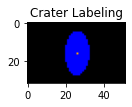

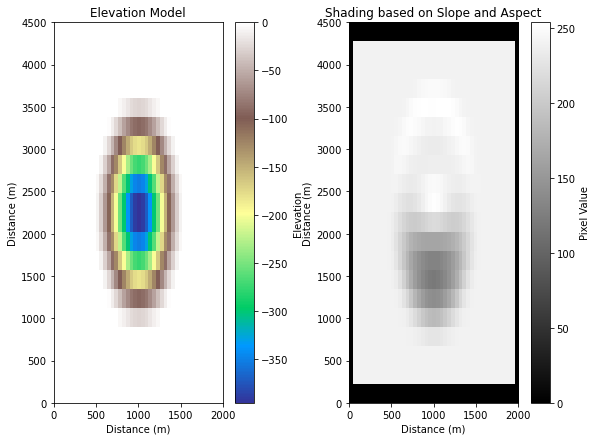

Image saved to TestHoles/hole_mx20_my45_slope14_el71_az358_xrad660_yrad1220.pgm
Label image saved to TestHoles/hole_mx20_my45_slope14_el71_az358_xrad660_yrad1220LABEL.pgm


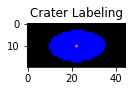

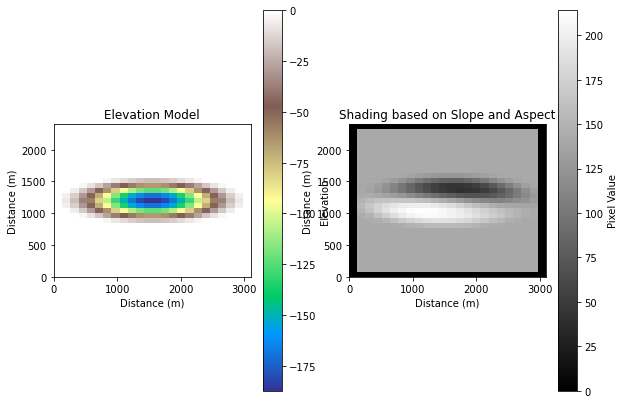

Image saved to TestHoles/hole_mx31_my24_slope28_el34_az145_xrad503_yrad1194.pgm
Label image saved to TestHoles/hole_mx31_my24_slope28_el34_az145_xrad503_yrad1194LABEL.pgm


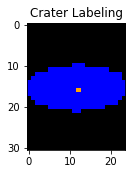

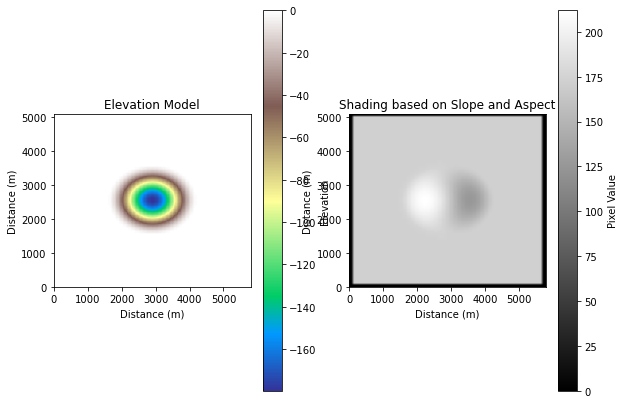

Image saved to TestHoles/hole_mx58_my51_slope29_el43_az91_xrad1193_yrad1167.pgm
Label image saved to TestHoles/hole_mx58_my51_slope29_el43_az91_xrad1193_yrad1167LABEL.pgm


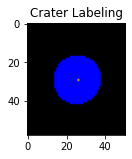

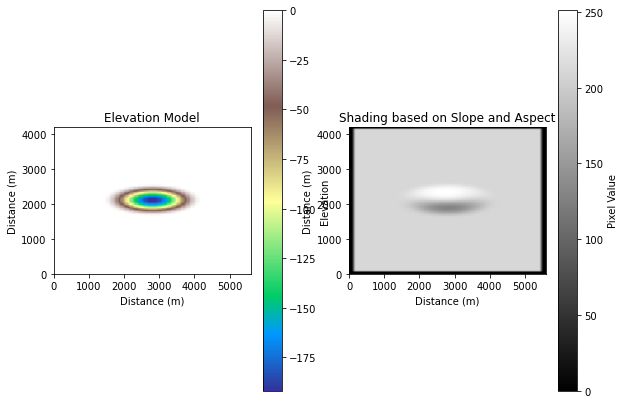

Image saved to TestHoles/hole_mx56_my42_slope27_el56_az6_xrad598_yrad1055.pgm
Label image saved to TestHoles/hole_mx56_my42_slope27_el56_az6_xrad598_yrad1055LABEL.pgm


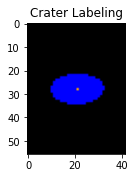

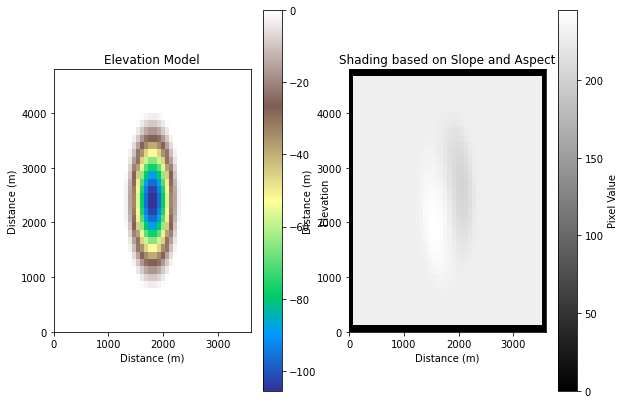

Image saved to TestHoles/hole_mx36_my48_slope43_el64_az129_xrad1291_yrad725.pgm
Label image saved to TestHoles/hole_mx36_my48_slope43_el64_az129_xrad1291_yrad725LABEL.pgm


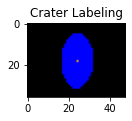

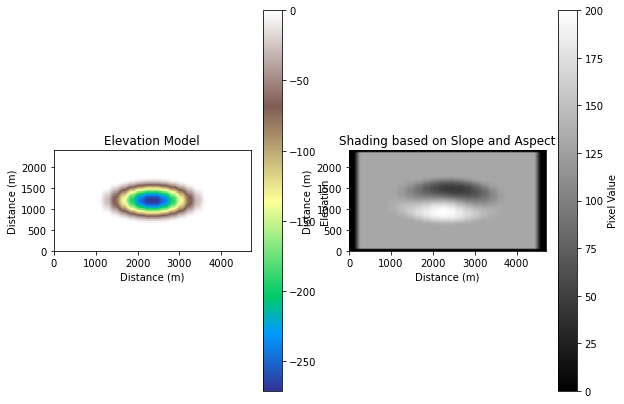

Image saved to TestHoles/hole_mx47_my24_slope20_el31_az172_xrad1096_yrad690.pgm
Label image saved to TestHoles/hole_mx47_my24_slope20_el31_az172_xrad1096_yrad690LABEL.pgm


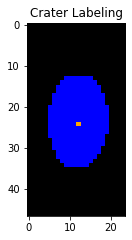

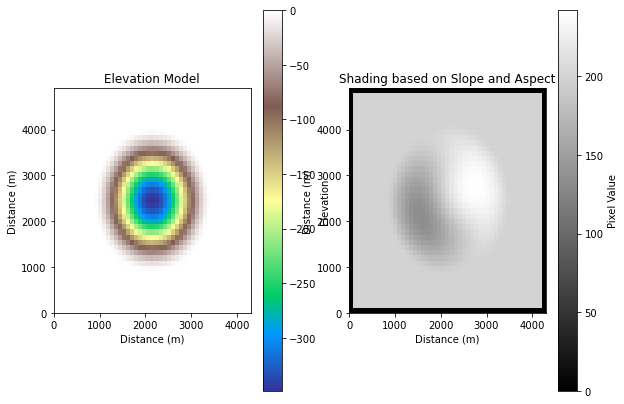

Image saved to TestHoles/hole_mx43_my49_slope16_el52_az293_xrad1398_yrad1467.pgm
Label image saved to TestHoles/hole_mx43_my49_slope16_el52_az293_xrad1398_yrad1467LABEL.pgm


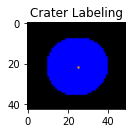

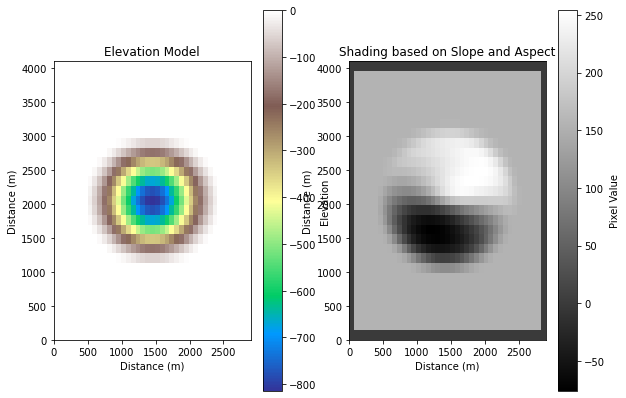

Image saved to TestHoles/hole_mx29_my41_slope7_el38_az328_xrad723_yrad1455.pgm
Label image saved to TestHoles/hole_mx29_my41_slope7_el38_az328_xrad723_yrad1455LABEL.pgm


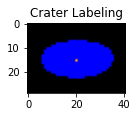

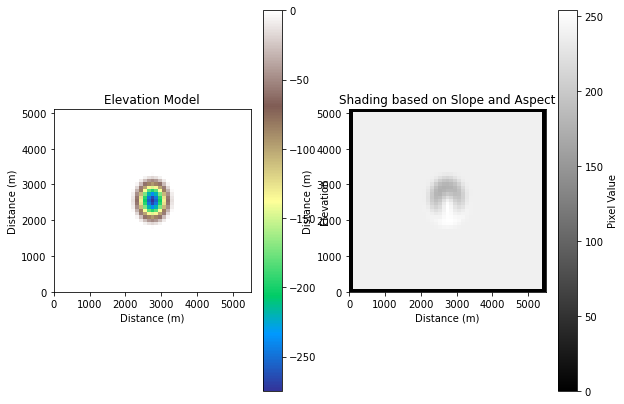

Image saved to TestHoles/hole_mx55_my51_slope20_el70_az186_xrad835_yrad582.pgm
Label image saved to TestHoles/hole_mx55_my51_slope20_el70_az186_xrad835_yrad582LABEL.pgm


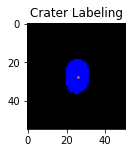

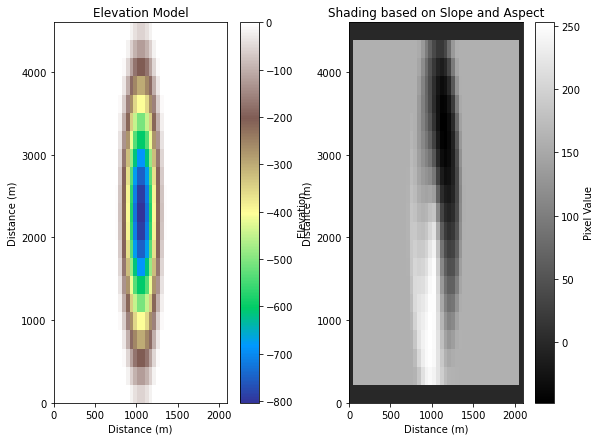

Image saved to TestHoles/hole_mx21_my46_slope7_el39_az151_xrad1206_yrad687.pgm
Label image saved to TestHoles/hole_mx21_my46_slope7_el39_az151_xrad1206_yrad687LABEL.pgm


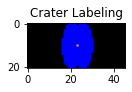

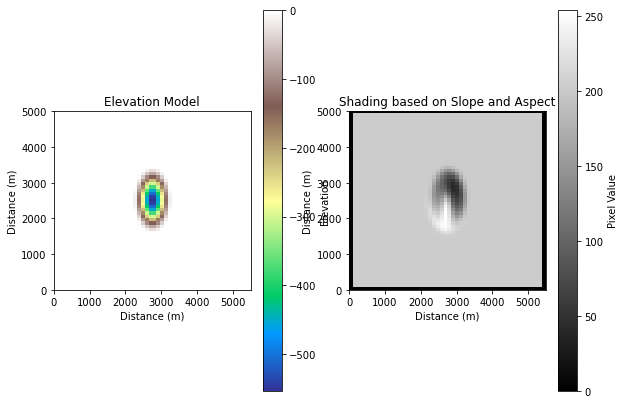

Image saved to TestHoles/hole_mx55_my50_slope10_el53_az162_xrad1063_yrad505.pgm
Label image saved to TestHoles/hole_mx55_my50_slope10_el53_az162_xrad1063_yrad505LABEL.pgm


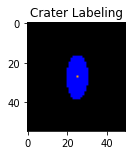

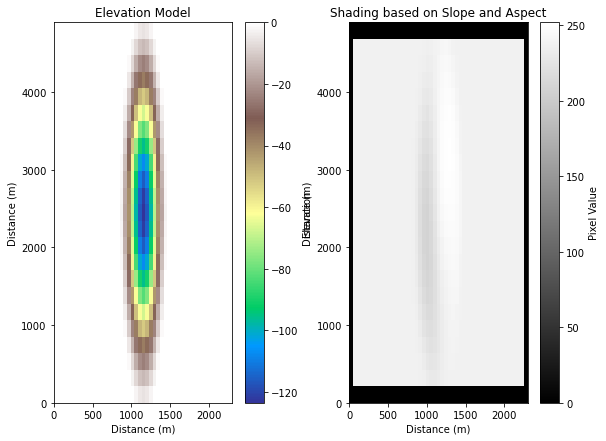

Image saved to TestHoles/hole_mx23_my49_slope39_el69_az305_xrad1272_yrad659.pgm
Label image saved to TestHoles/hole_mx23_my49_slope39_el69_az305_xrad1272_yrad659LABEL.pgm


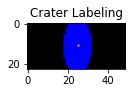

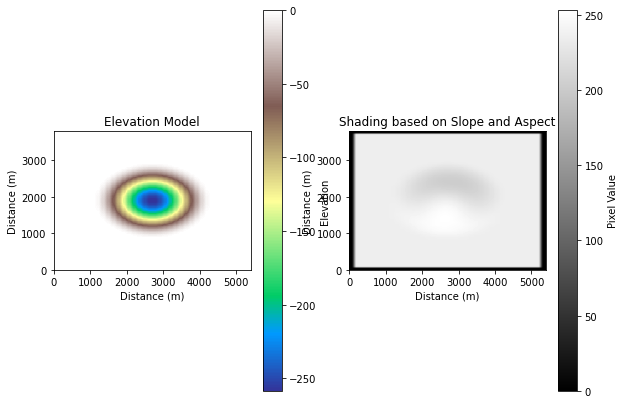

Image saved to TestHoles/hole_mx54_my38_slope21_el68_az174_xrad1488_yrad1136.pgm
Label image saved to TestHoles/hole_mx54_my38_slope21_el68_az174_xrad1488_yrad1136LABEL.pgm


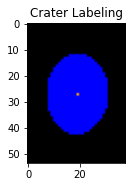

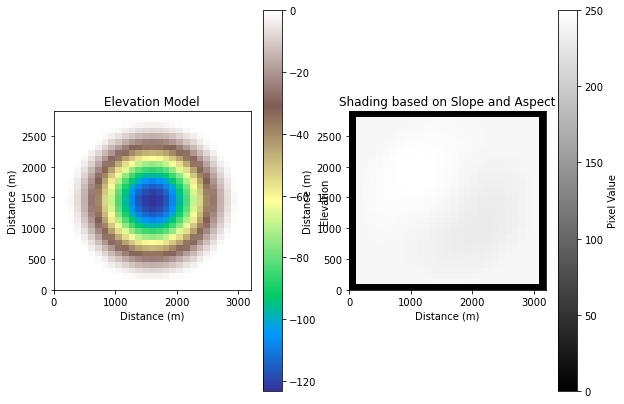

Image saved to TestHoles/hole_mx32_my29_slope39_el72_az46_xrad1492_yrad1292.pgm
Label image saved to TestHoles/hole_mx32_my29_slope39_el72_az46_xrad1492_yrad1292LABEL.pgm


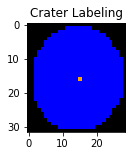

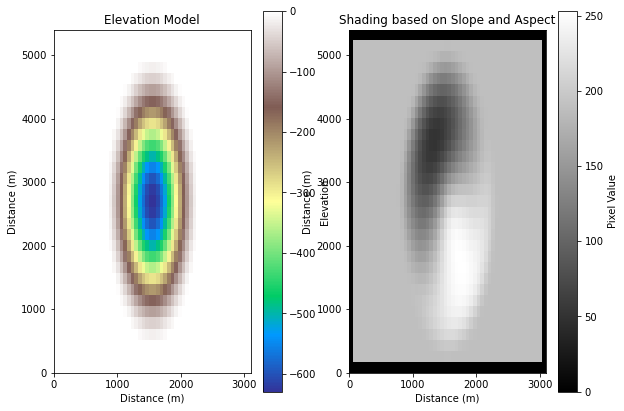

Image saved to TestHoles/hole_mx31_my54_slope9_el48_az213_xrad1334_yrad1290.pgm
Label image saved to TestHoles/hole_mx31_my54_slope9_el48_az213_xrad1334_yrad1290LABEL.pgm


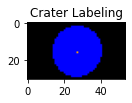

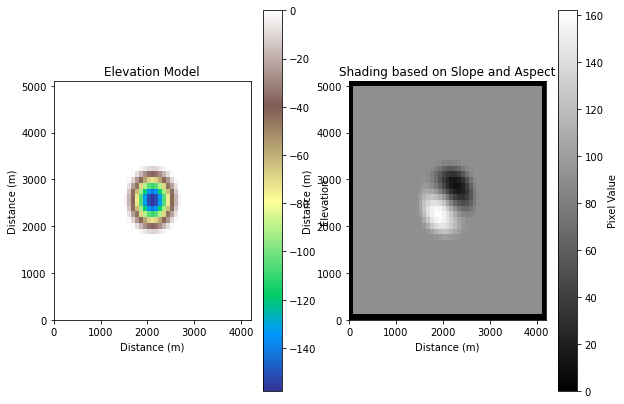

Image saved to TestHoles/hole_mx42_my51_slope32_el21_az138_xrad662_yrad770.pgm
Label image saved to TestHoles/hole_mx42_my51_slope32_el21_az138_xrad662_yrad770LABEL.pgm


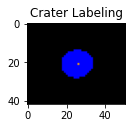

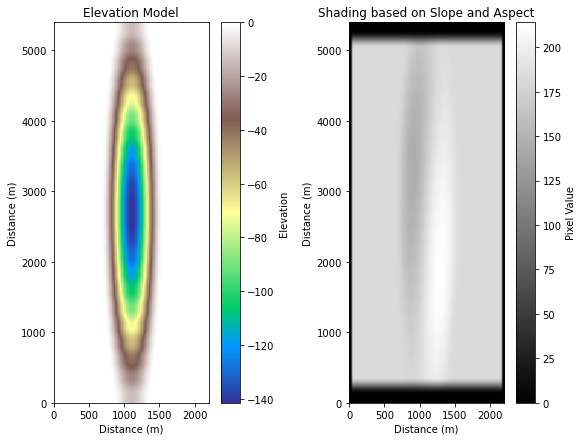

Image saved to TestHoles/hole_mx22_my54_slope35_el46_az238_xrad1325_yrad1050.pgm
Label image saved to TestHoles/hole_mx22_my54_slope35_el46_az238_xrad1325_yrad1050LABEL.pgm


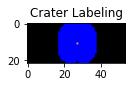

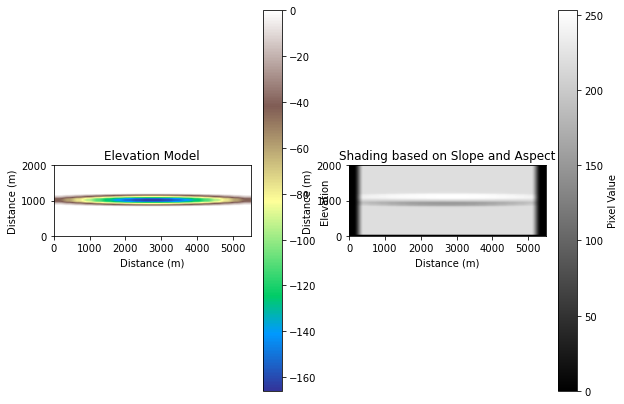

Image saved to TestHoles/hole_mx55_my20_slope31_el60_az355_xrad553_yrad1453.pgm
Label image saved to TestHoles/hole_mx55_my20_slope31_el60_az355_xrad553_yrad1453LABEL.pgm


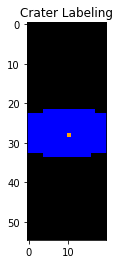

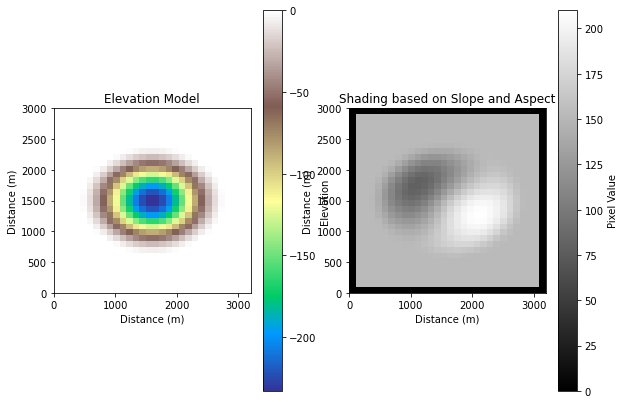

Image saved to TestHoles/hole_mx32_my30_slope23_el37_az241_xrad946_yrad1115.pgm
Label image saved to TestHoles/hole_mx32_my30_slope23_el37_az241_xrad946_yrad1115LABEL.pgm


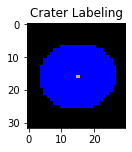

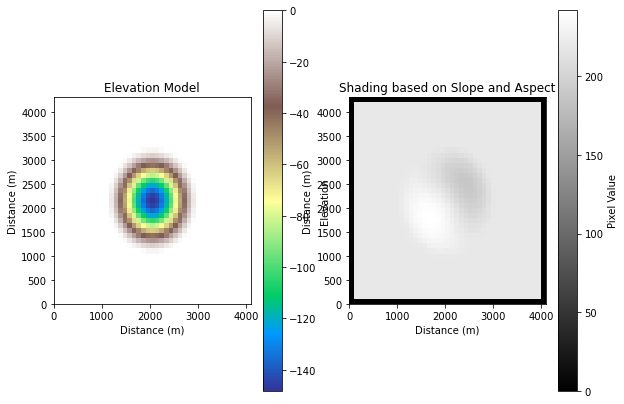

Image saved to TestHoles/hole_mx41_my43_slope34_el60_az130_xrad1093_yrad1028.pgm
Label image saved to TestHoles/hole_mx41_my43_slope34_el60_az130_xrad1093_yrad1028LABEL.pgm


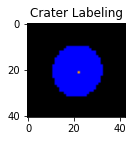

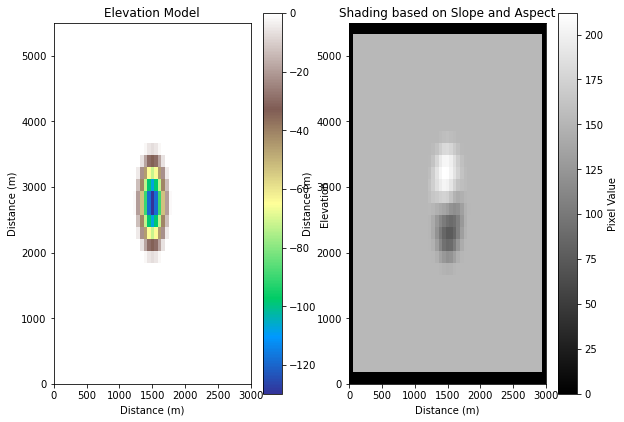

Image saved to TestHoles/hole_mx30_my55_slope37_el37_az11_xrad527_yrad538.pgm
Label image saved to TestHoles/hole_mx30_my55_slope37_el37_az11_xrad527_yrad538LABEL.pgm


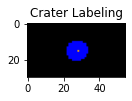

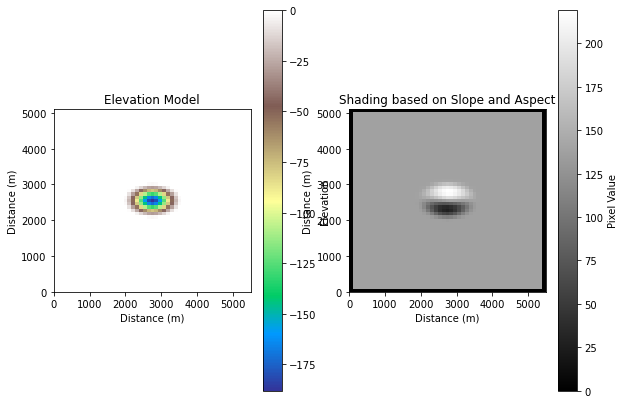

Image saved to TestHoles/hole_mx55_my51_slope28_el33_az355_xrad539_yrad767.pgm
Label image saved to TestHoles/hole_mx55_my51_slope28_el33_az355_xrad539_yrad767LABEL.pgm


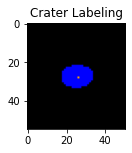

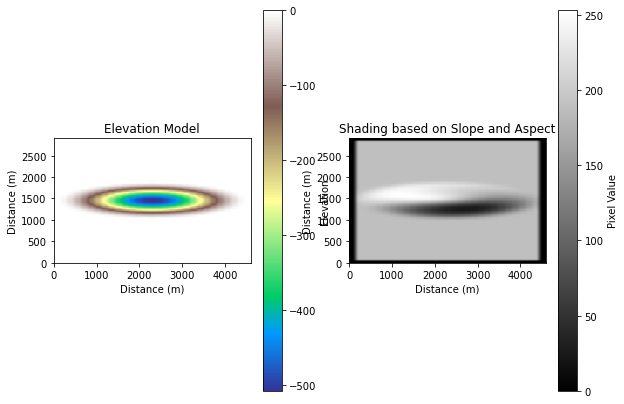

Image saved to TestHoles/hole_mx46_my29_slope11_el48_az44_xrad678_yrad1421.pgm
Label image saved to TestHoles/hole_mx46_my29_slope11_el48_az44_xrad678_yrad1421LABEL.pgm


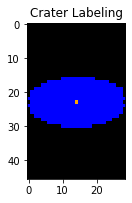

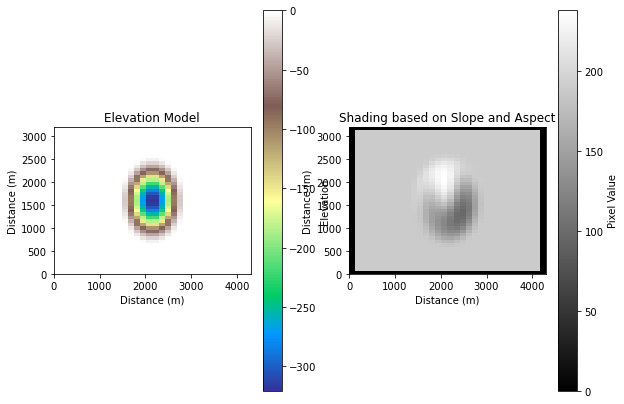

Image saved to TestHoles/hole_mx43_my32_slope17_el48_az15_xrad1326_yrad551.pgm
Label image saved to TestHoles/hole_mx43_my32_slope17_el48_az15_xrad1326_yrad551LABEL.pgm


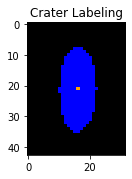

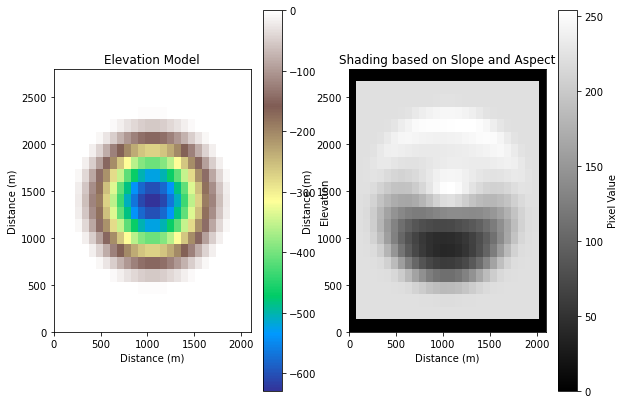

Image saved to TestHoles/hole_mx21_my28_slope9_el61_az354_xrad737_yrad1192.pgm
Label image saved to TestHoles/hole_mx21_my28_slope9_el61_az354_xrad737_yrad1192LABEL.pgm


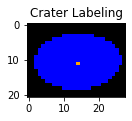

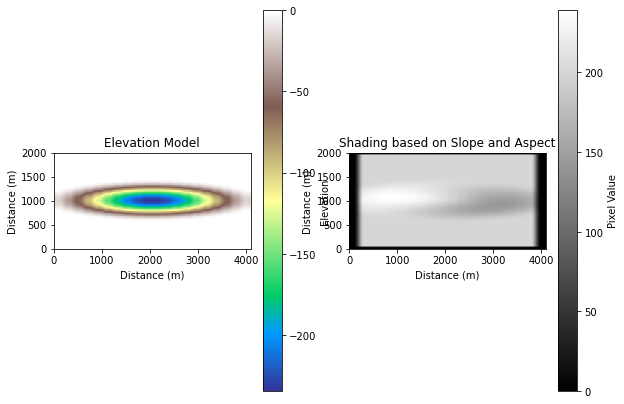

Image saved to TestHoles/hole_mx41_my20_slope23_el52_az74_xrad875_yrad1145.pgm
Label image saved to TestHoles/hole_mx41_my20_slope23_el52_az74_xrad875_yrad1145LABEL.pgm


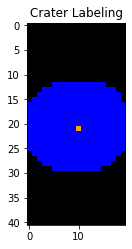

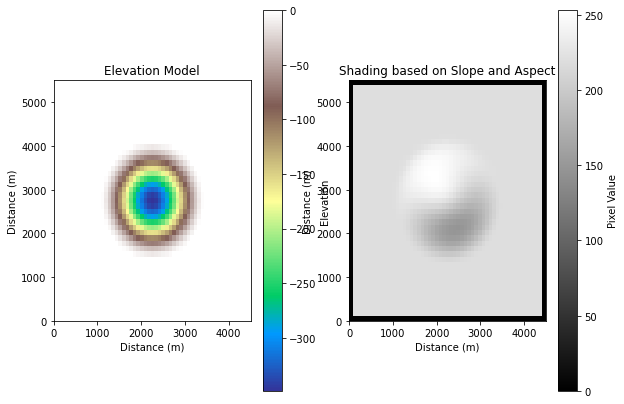

Image saved to TestHoles/hole_mx45_my55_slope16_el60_az29_xrad1137_yrad1482.pgm
Label image saved to TestHoles/hole_mx45_my55_slope16_el60_az29_xrad1137_yrad1482LABEL.pgm


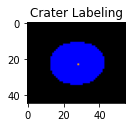

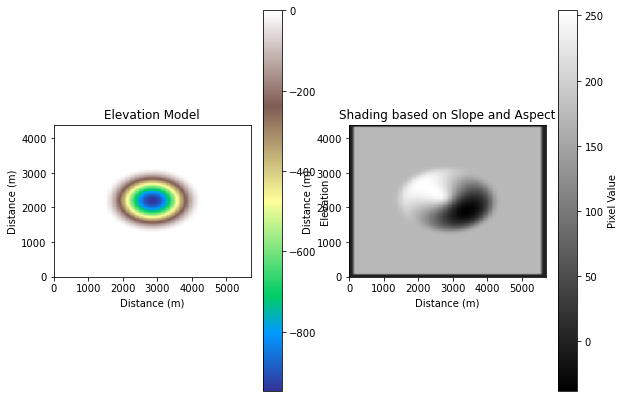

Image saved to TestHoles/hole_mx57_my44_slope6_el43_az50_xrad1235_yrad1110.pgm
Label image saved to TestHoles/hole_mx57_my44_slope6_el43_az50_xrad1235_yrad1110LABEL.pgm


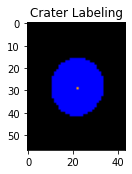

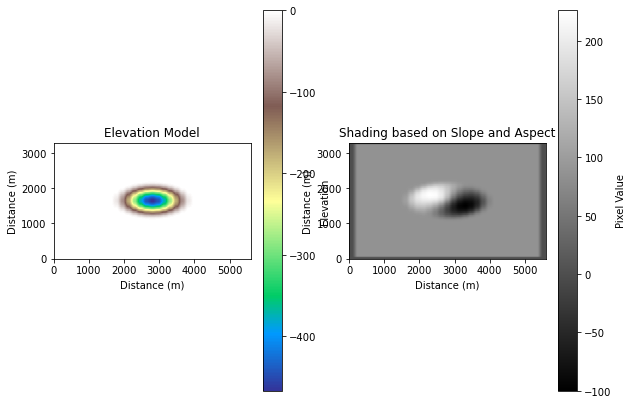

Image saved to TestHoles/hole_mx56_my33_slope12_el20_az54_xrad919_yrad685.pgm
Label image saved to TestHoles/hole_mx56_my33_slope12_el20_az54_xrad919_yrad685LABEL.pgm


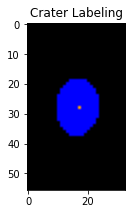

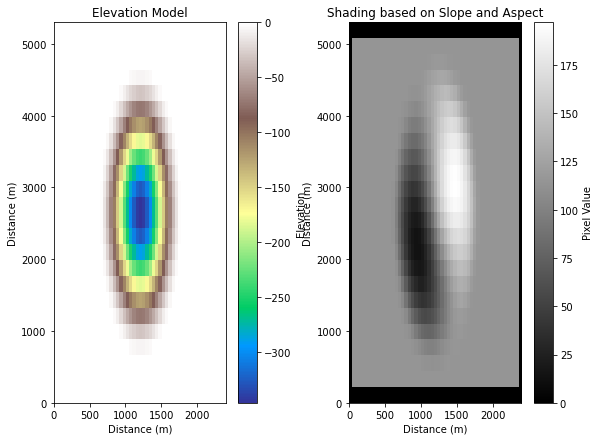

Image saved to TestHoles/hole_mx24_my53_slope16_el27_az291_xrad931_yrad1271.pgm
Label image saved to TestHoles/hole_mx24_my53_slope16_el27_az291_xrad931_yrad1271LABEL.pgm


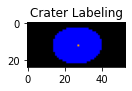

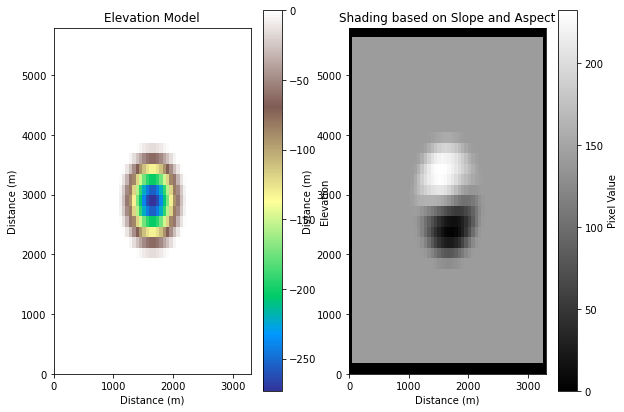

Image saved to TestHoles/hole_mx33_my58_slope20_el34_az23_xrad586_yrad1067.pgm
Label image saved to TestHoles/hole_mx33_my58_slope20_el34_az23_xrad586_yrad1067LABEL.pgm


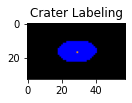

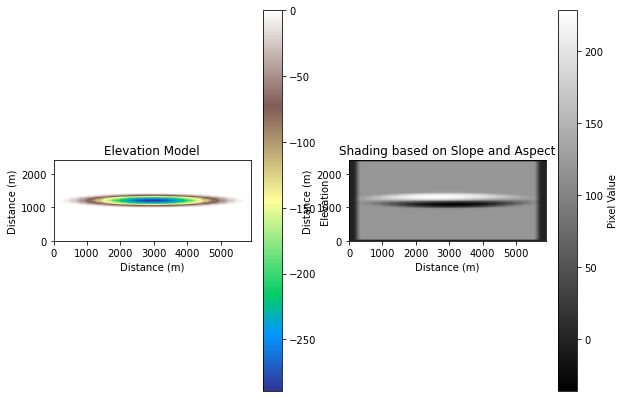

Image saved to TestHoles/hole_mx59_my24_slope19_el28_az14_xrad570_yrad1174.pgm
Label image saved to TestHoles/hole_mx59_my24_slope19_el28_az14_xrad570_yrad1174LABEL.pgm


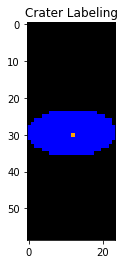

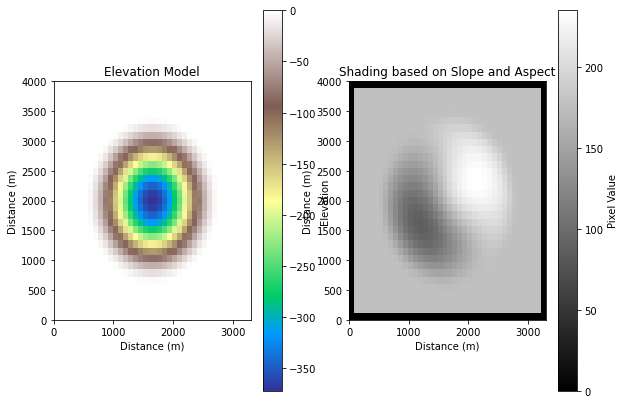

Image saved to TestHoles/hole_mx33_my40_slope15_el44_az299_xrad1169_yrad1355.pgm
Label image saved to TestHoles/hole_mx33_my40_slope15_el44_az299_xrad1169_yrad1355LABEL.pgm


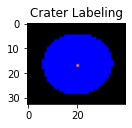

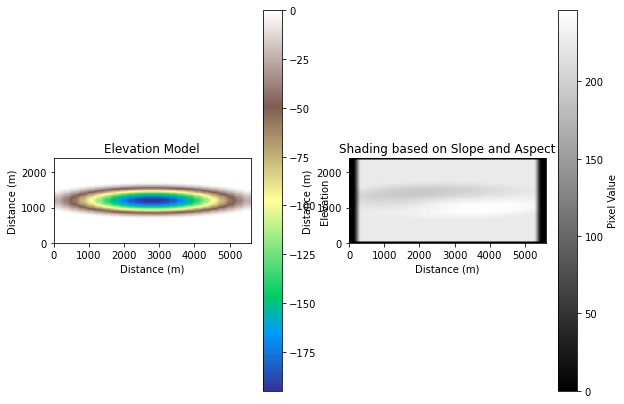

Image saved to TestHoles/hole_mx56_my24_slope27_el62_az219_xrad1243_yrad1488.pgm
Label image saved to TestHoles/hole_mx56_my24_slope27_el62_az219_xrad1243_yrad1488LABEL.pgm


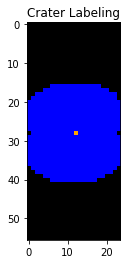

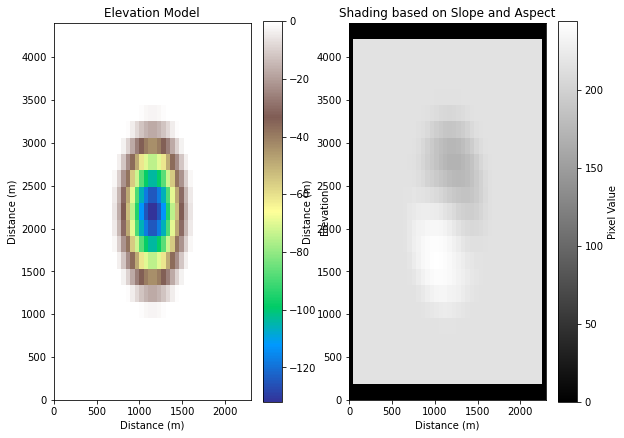

Image saved to TestHoles/hole_mx23_my44_slope37_el58_az148_xrad655_yrad974.pgm
Label image saved to TestHoles/hole_mx23_my44_slope37_el58_az148_xrad655_yrad974LABEL.pgm


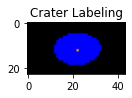

In [39]:
for i in range(0,200):
    mx_rand = 20 + int(random.random() * 40)
    my_rand = 20 + int(random.random() * 40)
    slope_rand = 5 + int(random.random() * 40)
    az_rand = int(random.random() * 360)
    elev_rand = 20 + int(random.random() * 55)
    xrad_rand = 500 + int(random.random() * 1000)
    yrad_rand = 500 + int(random.random() * 1000)
    make_hole(mx = mx_rand, my = my_rand, max_slope_deg = slope_rand, sun_elevation_deg = elev_rand,
              sun_azimuth_deg = az_rand,radius_x = xrad_rand, radius_y = yrad_rand, output_dir='TestHoles')